# Projeto Anti Fraude Veicular

Código escrito por Bruno Santos

## Imports iniciais

In [2]:
!pip install imbalanced-learn

In [3]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.6 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from lightgbm import LGBMClassifier
import shap

In [5]:
!git clone https://github.com/Neurolake/challenge-data-scientist.git

Cloning into 'challenge-data-scientist'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 140 (delta 21), reused 18 (delta 14), pack-reused 91 (from 2)
Receiving objects: 100% (140/140), 254.40 MiB | 17.05 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [6]:
file_path = '/content/challenge-data-scientist/datasets/base_antifraude.gz'

In [7]:
df = pd.read_csv(file_path, compression='gzip', sep='\t', low_memory=False)

In [8]:
print("Dimensão da base:", df.shape)

Dimensão da base: (47732, 205)


A dimensão da base bate com a informação dada: há 47732 linhas e 205 colunas na base

In [9]:
df.head(5)

id                         documento  \
0  4db9c75f6a31c73414ad84fdd101b5d7  d92fa549809f55b4ea13caa1b108896f   
1  9b07d4001632189d19de964894501e34  1af133c98723189f24bbfcb75abfcf92   
2  d55b6a81203f5a5ae6f362c483f36ff1  9e95be945b56ff10dc43df22381c9002   
3  f6bb36049c3b42a62dfa88c46e0f79d2  50502098d83c37b5fa60241bc4bd6641   
4  2755ed6330b4980ea24faa1081183dc7  aad24a7552d24b46188103f4249f17e7   

   mes_ref  alvo  vlr_financiado      VAR1  VAR2  VAR3      VAR4  VAR5  ...  \
0   202307   0.0        17820.60  0.166667   0.0   0.0  1.000000   NaN  ...   
1   202307   0.0        18513.56  0.166667   0.0   0.0  0.027211   NaN  ...   
2   202307   0.0        22943.80  0.000000   0.0   0.0  0.013605   NaN  ...   
3   202307   0.0        19177.58  0.083333   0.0   0.0  0.020408   NaN  ...   
4   202307   0.0        16644.85  0.000000   0.0   0.0  0.000000   NaN  ...   

     VAR191  VAR192    VAR193  VAR194    VAR195  VAR196    VAR197    VAR198  \
0  0.609314     0.0  0.095790     NaN  0.066331     NaN  0.666667  0.135065   
1       NaN     NaN       NaN     NaN       NaN     NaN  0.666667       NaN   
2       NaN     NaN       NaN     NaN       NaN     NaN  0.333333       NaN   
3       NaN     NaN       NaN     NaN       NaN     NaN  0.833333       NaN   
4  0.045513     NaN  0.532964     NaN       NaN     NaN  0.500000       NaN   

     VAR199  VAR200  
0   SUDESTE     0.0  
1     NORTE     0.0  
2       SUL     0.0  
3     NORTE     0.0  
4  NORDESTE     0.0  

[5 rows x 205 columns]

## Análise inicial do dataset

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47732 entries, 0 to 47731
Columns: 205 entries, id to VAR200
dtypes: float64(190), int64(1), object(14)
memory usage: 74.7+ MB


In [11]:
# Verificando a proporção de cada resposta da coluna alvo
df['alvo'].value_counts(normalize=True)

alvo
0.0    0.958393
1.0    0.041607
Name: proportion, dtype: float64

Como a base está muito desbalanceada, a métrica de acurácia (para determinar o quão "bom" o modelo é) não é o melhor nem o único ponto a ser analisado.

In [12]:
# Vendo meses únicos e contagem por mês
print("\nAmostras por mes_ref (top):")
print(df['mes_ref'].value_counts().sort_index())


Amostras por mes_ref (top):
mes_ref
202307    8392
202308    9533
202309    8592
202310    8533
202311    6484
202312    6198
Name: count, dtype: int64


In [13]:
# Verificando as colunas que possuem texto
text_cols = df.select_dtypes(include=['object']).columns
print("Colunas com valores de texto:", text_cols.tolist())

Colunas com valores de texto: ['id', 'documento', 'VAR31', 'VAR41', 'VAR52', 'VAR100', 'VAR103', 'VAR104', 'VAR112', 'VAR119', 'VAR122', 'VAR175', 'VAR185', 'VAR199']


In [14]:
# Verificando a quantidade de valores únicos de texto dessas colunas
for col in text_cols:
    print(f"{col}: {df[col].nunique()} categorias")

id: 47732 categorias
documento: 47607 categorias
VAR31: 2 categorias
VAR41: 4 categorias
VAR52: 11 categorias
VAR100: 5 categorias
VAR103: 5 categorias
VAR104: 2 categorias
VAR112: 5 categorias
VAR119: 19 categorias
VAR122: 2 categorias
VAR175: 11 categorias
VAR185: 4 categorias
VAR199: 5 categorias


In [15]:
# Separando as colunas de texto que começam com 'VAR' poois id e documento são muitas e são campos chave
var_text_cols = [col for col in text_cols if col.startswith('VAR')]
print("Colunas de texto que começam com VAR:", var_text_cols)

# Mostrando os valores únicos e contagem para cada coluna
for col in var_text_cols:
    print(f"\n=== {col} ===")
    unique_vals = df[col].unique()
    print("Valores únicos:", unique_vals)
    print("Contagem de cada valor:")
    print(df[col].value_counts(dropna=False))

Colunas de texto que começam com VAR: ['VAR31', 'VAR41', 'VAR52', 'VAR100', 'VAR103', 'VAR104', 'VAR112', 'VAR119', 'VAR122', 'VAR175', 'VAR185', 'VAR199']

=== VAR31 ===
Valores únicos: ['N' nan 'S']
Contagem de cada valor:
VAR31
NaN    23734
N      23638
S        360
Name: count, dtype: int64

=== VAR41 ===
Valores únicos: ['ALTA' 'ALTISSIMA' 'MEDIA' 'BAIXISSIMA' nan]
Contagem de cada valor:
VAR41
ALTISSIMA     16822
ALTA          12378
MEDIA          9852
NaN            4861
BAIXISSIMA     3819
Name: count, dtype: int64

=== VAR52 ===
Valores únicos: ['F' nan 'A' 'B' 'E' 'D' 'C' 'K' 'I' 'G' 'J' 'H']
Contagem de cada valor:
VAR52
A      19139
NaN    14987
B       7219
C       2657
D       1307
E        753
F        512
K        492
G        282
H        210
I        121
J         53
Name: count, dtype: int64

=== VAR100 ===
Valores únicos: ['LONGE' 'PROXIMO' 'MUITO PROXIMO' 'MUITO LONGE' 'MEDIO' nan]
Contagem de cada valor:
VAR100
MEDIO            15777
PROXIMO          13895
LONGE  

Com essa resposta, é possível atuar de melhor forma nos dados presentes em colunas de texto para realizar uma substituição

In [16]:
# Missing
missing = df.isna().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'missing_count': missing, 'missing_percent': missing_percent})
print(missing_df.head(30))  # top 30 piores missing

        missing_count  missing_percent
VAR87           47676            99.88
VAR24           47406            99.32
VAR157          47263            99.02
VAR121          47258            99.01
VAR148          46926            98.31
VAR60           46891            98.24
VAR21           46855            98.16
VAR178          46855            98.16
VAR72           46628            97.69
VAR27           46508            97.44
VAR74           46503            97.43
VAR169          46499            97.42
VAR118          46410            97.23
VAR137          46296            96.99
VAR47           46244            96.88
VAR53           46244            96.88
VAR143          46231            96.86
VAR55           46089            96.56
VAR162          46089            96.56
VAR77           46032            96.44
VAR85           45902            96.17
VAR151          45863            96.08
VAR171          45844            96.04
VAR120          45838            96.03
VAR192          45838    

In [17]:
# Estatísticas básicas de numéricos
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols.remove('alvo')
df[num_cols].describe().T

count           mean          std           min  \
mes_ref         47732.0  202309.288653     1.646360  2.023070e+05   
vlr_financiado  47594.0   19183.781266  5535.485493  2.427880e+03   
VAR1            26947.0       0.201139     0.253286  0.000000e+00   
VAR2            26947.0       0.156529     0.293852  0.000000e+00   
VAR3            40926.0       0.031447     0.174525  0.000000e+00   
...                 ...            ...          ...           ...   
VAR195           2238.0       0.293470     0.222681  3.038740e-07   
VAR196           7704.0       0.308971     0.201970  1.120454e-06   
VAR197          35629.0       0.489437     0.180096  0.000000e+00   
VAR198           3838.0       0.259947     0.189631  6.222729e-05   
VAR200          44930.0       0.054422     0.165324  0.000000e+00   

                          25%            50%            75%            max  
mes_ref         202308.000000  202309.000000  202311.000000  202312.000000  
vlr_financiado   15742.620000   18836.810000   22276.500000   91283.650000  
VAR1                 0.000000       0.083333       0.333333       1.000000  
VAR2                 0.000000       0.000000       0.000000       1.000000  
VAR3                 0.000000       0.000000       0.000000       1.000000  
...                       ...            ...            ...            ...  
VAR195               0.107887       0.240976       0.450916       1.000000  
VAR196               0.163283       0.277927       0.409290       1.000001  
VAR197               0.333333       0.500000       0.500000       1.000000  
VAR198               0.130120       0.211768       0.336232       1.000062  
VAR200               0.000000       0.000000       0.000000       1.000000  

[190 rows x 8 columns]

Como são muitas colunas, e muitas com um alto percentual de informações faltantes, primeiro será feito o tratamento de dados e depois a Análise Exploratória completa da base correlacionando com a coluna alvo.

## Tratamento de dados

Como não se tem a informação se é uma base de dados de propostas aprovadas por exemplo, as colunas de id e documento serão apagadas. A coluna de documento por exemplo poderia ser últil caso exsitisse a informação de quantos financiamentos foram feitos nos últimos 6 meses, já que a base possui uma coluna de mês.

In [18]:
# Apagando colunas id e documento
df.drop(columns=['id', 'documento'], inplace=True)

In [19]:
# Tratando colunas de S/N/nan
bin_cols = ['VAR31', 'VAR104', 'VAR122']

for col in bin_cols:
    df[col] = df[col].map({'N':0, 'S':1})
    df[col] = df[col].fillna(-1)

In [20]:
for col in bin_cols:
    check_bin_cols = df[col].unique()
    print("Valores únicos:", check_bin_cols)
    print("Contagem de cada valor:")
    print(df[col].value_counts(dropna=False))

Valores únicos: [ 0. -1.  1.]
Contagem de cada valor:
VAR31
-1.0    23734
 0.0    23638
 1.0      360
Name: count, dtype: int64
Valores únicos: [ 1. -1.  0.]
Contagem de cada valor:
VAR104
 1.0    22757
-1.0    19505
 0.0     5470
Name: count, dtype: int64
Valores únicos: [ 0.  1. -1.]
Contagem de cada valor:
VAR122
 0.0    35937
 1.0     6789
-1.0     5006
Name: count, dtype: int64


In [21]:
# Tratando colunas de classe
ordinal_map = {'BAIXISSIMA':1, 'BAIXA':2, 'MEDIA':3, 'ALTA':4, 'ALTISSIMA':5}
ordinal_cols = ['VAR41', 'VAR112', 'VAR185']

for col in ordinal_cols:
    df[col] = df[col].map(ordinal_map)
    df[col] = df[col].fillna(df[col].mode()[0])

In [22]:
for col in ordinal_cols:
    check_ordinal_cols = df[col].unique()
    print("Valores únicos:", check_ordinal_cols)
    print("Contagem de cada valor:")
    print(df[col].value_counts(dropna=False))

Valores únicos: [4. 5. 3. 1.]
Contagem de cada valor:
VAR41
5.0    21683
4.0    12378
3.0     9852
1.0     3819
Name: count, dtype: int64
Valores únicos: [4. 5. 3. 2. 1.]
Contagem de cada valor:
VAR112
5.0    20301
4.0    13634
3.0    11367
2.0     1304
1.0     1126
Name: count, dtype: int64
Valores únicos: [4. 5. 3. 1.]
Contagem de cada valor:
VAR185
5.0    21673
3.0    11939
4.0    11420
1.0     2700
Name: count, dtype: int64


In [23]:
# Tratando a coluna VAR100 (possível distância)
distance_map = {'MUITO PROXIMO':1, 'PROXIMO':2, 'MEDIO':3, 'LONGE':4, 'MUITO LONGE':5}

df['VAR100'] = df['VAR100'].map(distance_map)
df['VAR100'] = df['VAR100'].fillna(df['VAR100'].mode()[0])

In [24]:
check_distance_cols = df['VAR100'].unique()
print("Valores únicos:", check_distance_cols)
print("Contagem de cada valor:")
print(df['VAR100'].value_counts(dropna=False))

Valores únicos: [4. 2. 1. 5. 3.]
Contagem de cada valor:
VAR100
3.0    20638
2.0    13895
4.0     9738
1.0     2225
5.0     1236
Name: count, dtype: int64


In [25]:
# Tratando as colunas de texto/classificação
text_cat_cols = ['VAR52', 'VAR103', 'VAR119', 'VAR175', 'VAR199']
for col in text_cat_cols:
    df[col] = df[col].fillna('MISSING')

In [26]:
# Fazendo One Hot Encoding na coluna de regiões
df['VAR199'] = df['VAR199'].astype(str)
df = pd.get_dummies(df, columns=['VAR199'], dummy_na=False, dtype=int)

# Conferindo as novas colunas
print(df.filter(like='VAR199_').head())

   VAR199_CENTROESTE  VAR199_MISSING  VAR199_NORDESTE  VAR199_NORTE  \
0                  0               0                0             0   
1                  0               0                0             1   
2                  0               0                0             0   
3                  0               0                0             1   
4                  0               0                1             0   

   VAR199_SUDESTE  VAR199_SUL  
0               1           0  
1               0           0  
2               0           1  
3               0           0  
4               0           0  


Por enquanto, seguiu-se com apenas o preenchimento dos dados faltantes com MISSING. Após a divisão de treino e teste será feito um target encoding (se feito antes, ocorre data leaking).

E para a coluna VAR199 (regiões do país) foi feito o One Hot Encoding, que não tem uso da variável alvo, logo pode ser feito antes da divisão de treino e teste).

In [27]:
for col in ['VAR52','VAR103','VAR119','VAR175']:
    print(f"=== {col} ===")
    print(df[col].value_counts(dropna=False))
    print("\n")

=== VAR52 ===
VAR52
A          19139
MISSING    14987
B           7219
C           2657
D           1307
E            753
F            512
K            492
G            282
H            210
I            121
J             53
Name: count, dtype: int64


=== VAR103 ===
VAR103
SEM PASSAGEM     37114
ALTA              5937
SEM APROVACAO     2021
MEDIA             1692
BAIXA              625
MISSING            343
Name: count, dtype: int64


=== VAR119 ===
VAR119
MISSING    22819
Y           3269
D           2135
M           1885
C           1810
L           1687
E           1654
N           1365
F           1340
K           1323
H           1288
B           1233
J           1152
G           1148
O           1071
Z           1018
I            722
P            375
Q            250
A            188
Name: count, dtype: int64


=== VAR175 ===
VAR175
A          25272
MISSING    14887
B           1888
C           1508
D           1225
E            739
K            627
F            526
G           

In [28]:
for col in ['VAR52','VAR119','VAR175']:
    print(f"=== {col} ===")
    print(df.groupby(col)['alvo'].mean().sort_values(ascending=False))
    print("\n")

=== VAR52 ===
VAR52
G          0.117021
J          0.113208
I          0.107438
F          0.087891
K          0.087398
H          0.066667
E          0.066401
D          0.061974
C          0.052315
B          0.043773
A          0.037045
MISSING    0.035831
Name: alvo, dtype: float64


=== VAR119 ===
VAR119
MISSING    0.062097
A          0.053191
P          0.037333
Z          0.031434
O          0.029879
K          0.027967
B          0.027575
Q          0.024000
L          0.023118
M          0.022812
C          0.022652
F          0.022388
D          0.022014
H          0.020963
Y          0.020801
E          0.019347
N          0.019048
G          0.017422
I          0.016620
J          0.016493
Name: alvo, dtype: float64


=== VAR175 ===
VAR175
H          0.053333
D          0.049796
A          0.045465
B          0.043962
K          0.041467
F          0.039924
C          0.039125
MISSING    0.035669
G          0.029412
E          0.028417
I          0.024631
J          0.01342

A VAR52 tem um impacto maior na variável alvo que as demais, sendo uma boa candidata de variável importante na tomada de decisão.

In [29]:
# Checando os valores faltantes
df.isna().sum()

mes_ref                0
alvo                   0
vlr_financiado       138
VAR1               20785
VAR2               20785
                   ...  
VAR199_MISSING         0
VAR199_NORDESTE        0
VAR199_NORTE           0
VAR199_SUDESTE         0
VAR199_SUL             0
Length: 208, dtype: int64

In [30]:
# Checando as colunas com mais dados faltantes
nan_ratio = df.isna().mean()
nan_ratio.sort_values(ascending=False).head(20)

VAR87     0.998827
VAR24     0.993170
VAR157    0.990174
VAR121    0.990070
VAR148    0.983114
VAR60     0.982381
VAR21     0.981627
VAR178    0.981627
VAR72     0.976871
VAR27     0.974357
VAR74     0.974252
VAR169    0.974168
VAR118    0.972304
VAR137    0.969915
VAR53     0.968826
VAR47     0.968826
VAR143    0.968554
VAR55     0.965579
VAR162    0.965579
VAR77     0.964384
dtype: float64

In [31]:
print("Dimensão da base antes:", df.shape)

Dimensão da base antes: (47732, 208)


In [32]:
# Apagando colunas com mais de 50% de dados faltantes
cols_to_drop = nan_ratio[nan_ratio > 0.5].index.tolist()
df.drop(columns=cols_to_drop, inplace=True)

In [33]:
print("Dimensão da base depois:", df.shape)

Dimensão da base depois: (47732, 69)


In [34]:
# Preenchendo com a mediana
num_cols = df.select_dtypes(include='float64').columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

In [35]:
# Checando valores na
df.isna().sum().sort_values(ascending=False)

mes_ref            0
alvo               0
vlr_financiado     0
VAR1               0
VAR2               0
                  ..
VAR199_MISSING     0
VAR199_NORDESTE    0
VAR199_NORTE       0
VAR199_SUDESTE     0
VAR199_SUL         0
Length: 69, dtype: int64

In [36]:
# Listando as colunas de texto
text_cols_remaining = df.select_dtypes(include='object').columns.tolist()
print("Colunas de texto restantes:", text_cols_remaining)

# Mostrando valores únicos e contagem para cada coluna de texto
for col in text_cols_remaining:
    print(f"\n=== {col} ===")
    unique_vals = df[col].unique()
    print("Valores únicos:", unique_vals)
    print("Contagem de cada valor:")
    print(df[col].value_counts(dropna=False))

    # Calculando o impacto dessas colunas na coluna alvo
    if 'alvo' in df.columns:
        print("\nImpacto médio no alvo por categoria:")
        print(df.groupby(col)['alvo'].mean().sort_values(ascending=False))


Colunas de texto restantes: ['VAR52', 'VAR103', 'VAR119', 'VAR175']

=== VAR52 ===
Valores únicos: ['F' 'MISSING' 'A' 'B' 'E' 'D' 'C' 'K' 'I' 'G' 'J' 'H']
Contagem de cada valor:
VAR52
A          19139
MISSING    14987
B           7219
C           2657
D           1307
E            753
F            512
K            492
G            282
H            210
I            121
J             53
Name: count, dtype: int64

Impacto médio no alvo por categoria:
VAR52
G          0.117021
J          0.113208
I          0.107438
F          0.087891
K          0.087398
H          0.066667
E          0.066401
D          0.061974
C          0.052315
B          0.043773
A          0.037045
MISSING    0.035831
Name: alvo, dtype: float64

=== VAR103 ===
Valores únicos: ['MEDIA' 'SEM PASSAGEM' 'SEM APROVACAO' 'BAIXA' 'ALTA' 'MISSING']
Contagem de cada valor:
VAR103
SEM PASSAGEM     37114
ALTA              5937
SEM APROVACAO     2021
MEDIA             1692
BAIXA              625
MISSING            343
Name: c

In [37]:
df['mes_ref'] = pd.to_datetime(df['mes_ref'], format='%Y%m')

In [38]:
df.head(5)

mes_ref  alvo  vlr_financiado      VAR1  VAR2  VAR3      VAR4  VAR6  \
0 2023-07-01   0.0        17820.60  0.166667   0.0   0.0  1.000000   0.0   
1 2023-07-01   0.0        18513.56  0.166667   0.0   0.0  0.027211   0.0   
2 2023-07-01   0.0        22943.80  0.000000   0.0   0.0  0.013605   0.0   
3 2023-07-01   0.0        19177.58  0.083333   0.0   0.0  0.020408   0.0   
4 2023-07-01   0.0        16644.85  0.000000   0.0   0.0  0.000000   0.0   

   VAR10     VAR11  ...  VAR185  VAR188    VAR197  VAR200  VAR199_CENTROESTE  \
0   0.30  0.418605  ...     4.0     0.0  0.666667     0.0                  0   
1   0.04  0.000000  ...     5.0     0.0  0.666667     0.0                  0   
2   0.00  0.069767  ...     4.0     0.0  0.333333     0.0                  0   
3   0.02  0.116279  ...     5.0     0.0  0.833333     0.0                  0   
4   0.00  0.093023  ...     3.0     0.0  0.500000     0.0                  0   

   VAR199_MISSING  VAR199_NORDESTE  VAR199_NORTE VAR199_SUDESTE  VAR199_SUL  
0               0                0             0              1           0  
1               0                0             1              0           0  
2               0                0             0              0           1  
3               0                0             1              0           0  
4               0                1             0              0           0  

[5 rows x 69 columns]

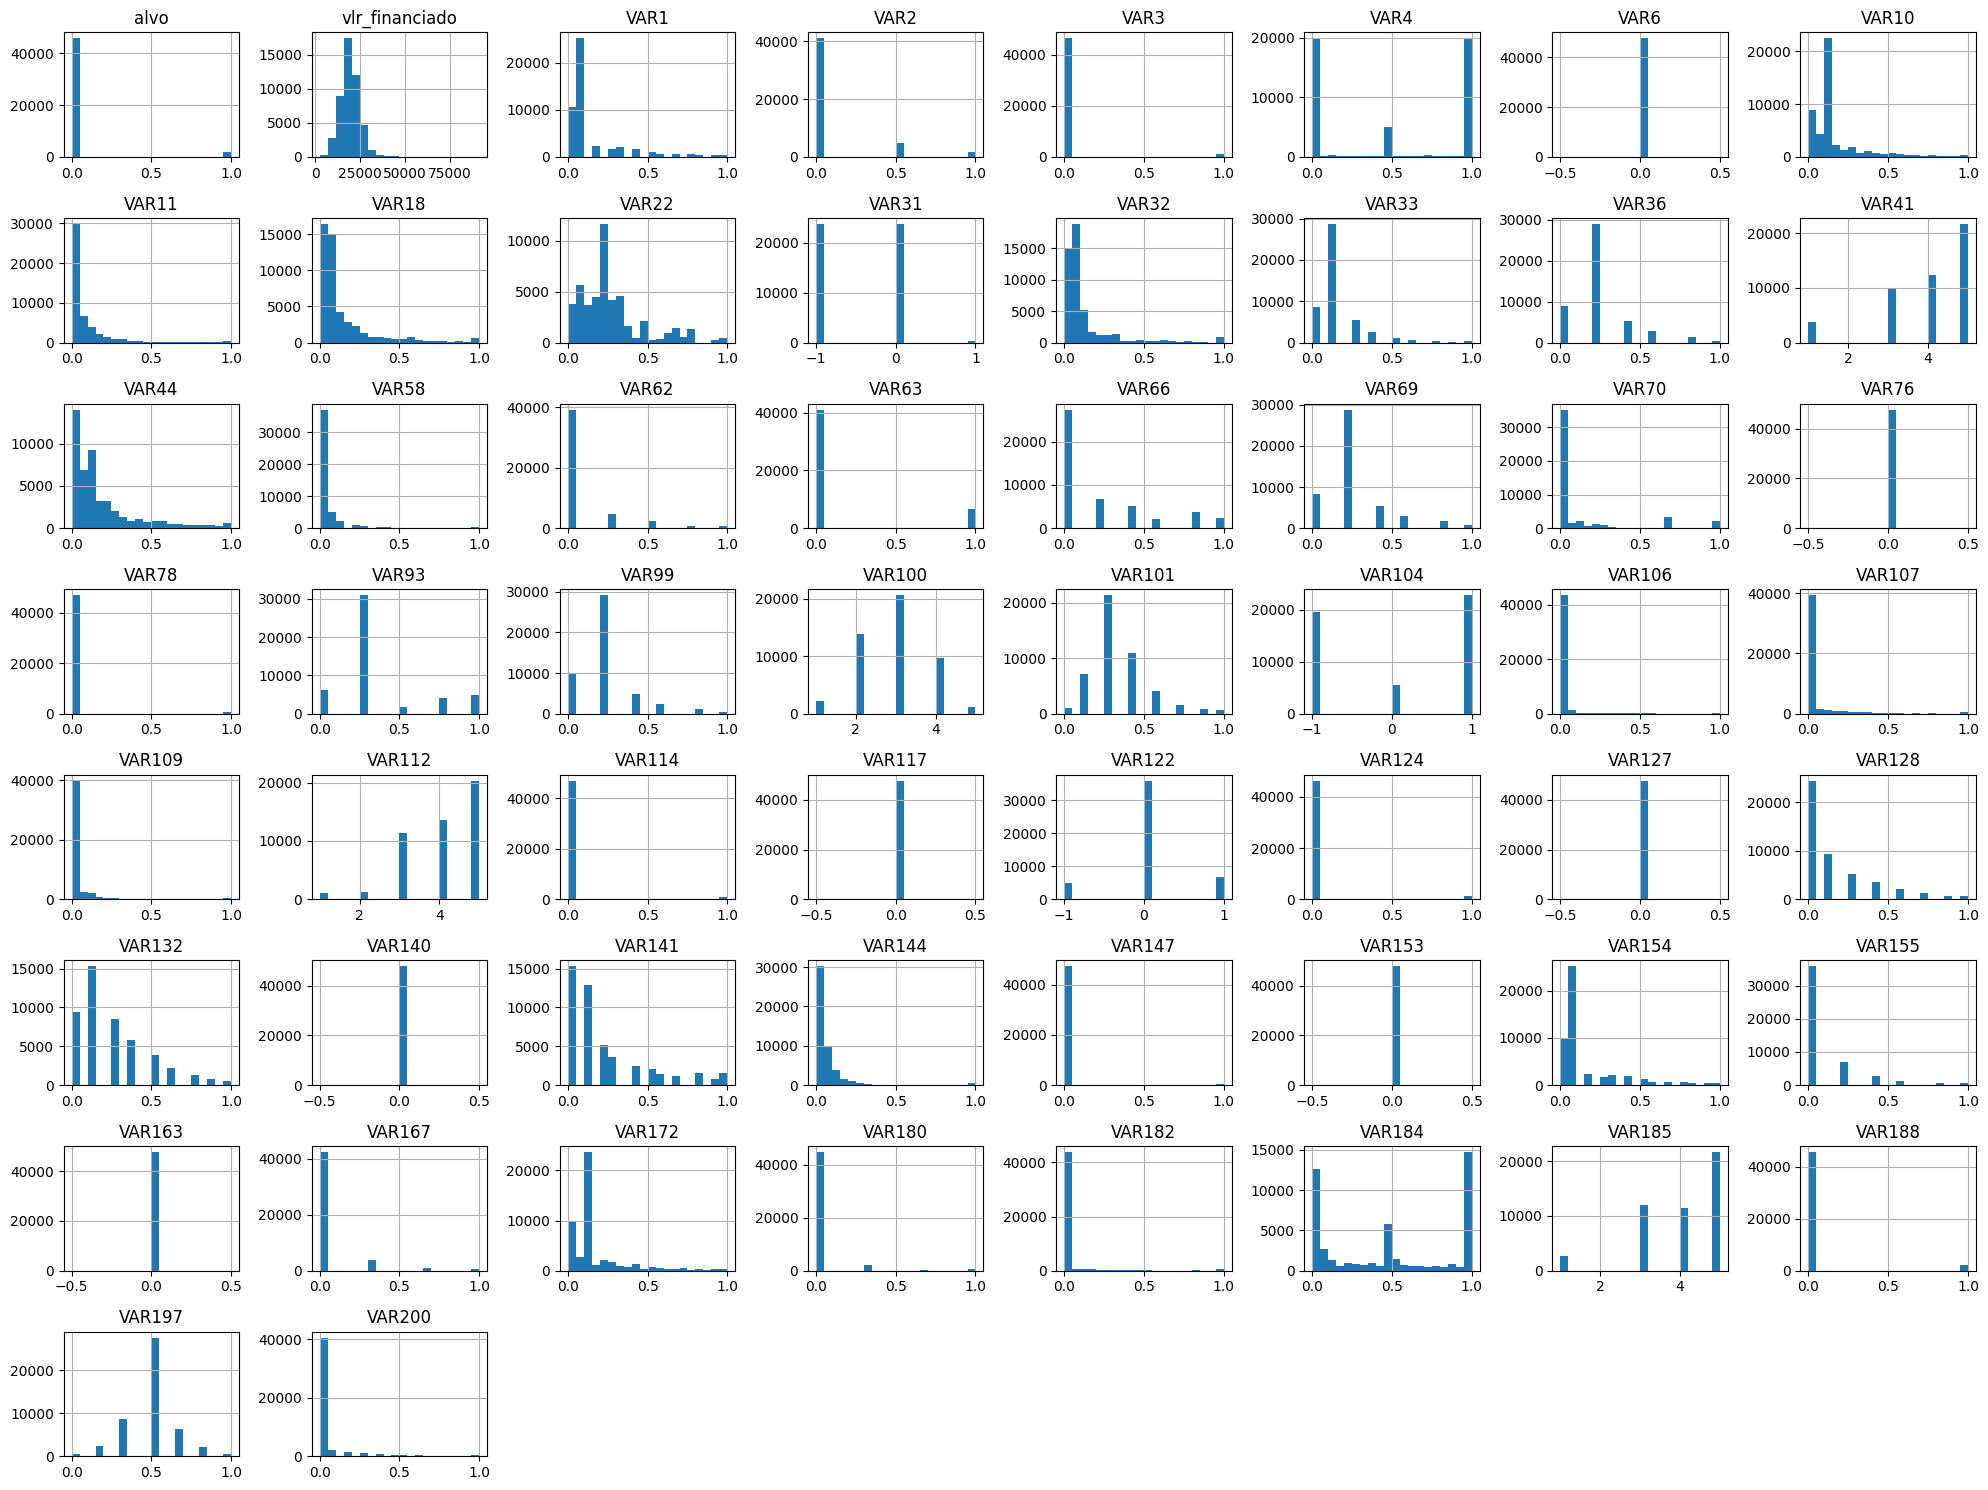

In [39]:
num_cols = df.select_dtypes(include='float64').columns

df[num_cols].hist(figsize=(20,15), bins=20)
plt.tight_layout()
plt.show()

In [40]:
# Selecionando colunas com apenas um valor único
const_cols = [col for col in df.columns if df[col].nunique() == 1]
print("Colunas constantes:", const_cols)

Colunas constantes: ['VAR6', 'VAR76', 'VAR117', 'VAR127', 'VAR140', 'VAR153', 'VAR163']


In [41]:
# Removendo essas colunas
df.drop(columns=const_cols, inplace=True)

In [42]:
# Verificando quantidade de duplicadas
print("Linhas duplicadas:", df.duplicated().sum())

Linhas duplicadas: 2


In [43]:
# Removendo duplicadas
df.drop_duplicates(inplace=True)

In [44]:
print("Nova dimensão da base:", df.shape)

Nova dimensão da base: (47730, 62)


## Análise Exploratória

In [45]:
# Vendo ocmo ficou a base
print("Dimensão da base:", df.shape)
print("\nTipos de dados:\n", df.dtypes.value_counts())
print("\nResumo estatístico das numéricas:\n", df.describe().T)

Dimensão da base: (47730, 62)

Tipos de dados:
 float64           51
int64              6
object             4
datetime64[ns]     1
Name: count, dtype: int64

Resumo estatístico das numéricas:
                      count                           mean  \
mes_ref              47730  2023-09-09 08:56:14.179760896   
alvo               47730.0                       0.041609   
vlr_financiado     47730.0                   19182.876149   
VAR1               47730.0                       0.149843   
VAR2               47730.0                       0.088372   
VAR3               47730.0                       0.026964   
VAR4               47730.0                       0.498814   
VAR10              47730.0                       0.167646   
VAR11              47730.0                       0.085744   
VAR18              47730.0                       0.137185   
VAR22              47730.0                       0.267132   
VAR31              47730.0                      -0.489671   
VAR32        

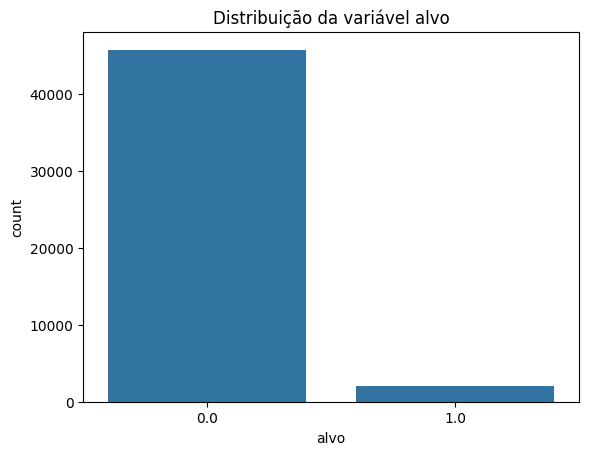

alvo
0.0    0.958391
1.0    0.041609
Name: proportion, dtype: float64


In [46]:
sns.countplot(x='alvo', data=df)
plt.title("Distribuição da variável alvo")
plt.show()

print(df['alvo'].value_counts(normalize=True))

In [47]:
# Análise de outliers
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [48]:
# Lista para armazenar estatísticas
outlier_list = []

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    outliers_low = (df[col] < lower_bound).sum()
    outliers_high = (df[col] > upper_bound).sum()

    outlier_list.append({
        'coluna': col,
        'min': df[col].min(),
        '1%': df[col].quantile(0.01),
        '25%': Q1,
        '50%': df[col].median(),
        '75%': Q3,
        '99%': df[col].quantile(0.99),
        'max': df[col].max(),
        'outliers_low': outliers_low,
        'outliers_high': outliers_high
    })

# Transformand lista em DataFrame
outlier_stats = pd.DataFrame(outlier_list)

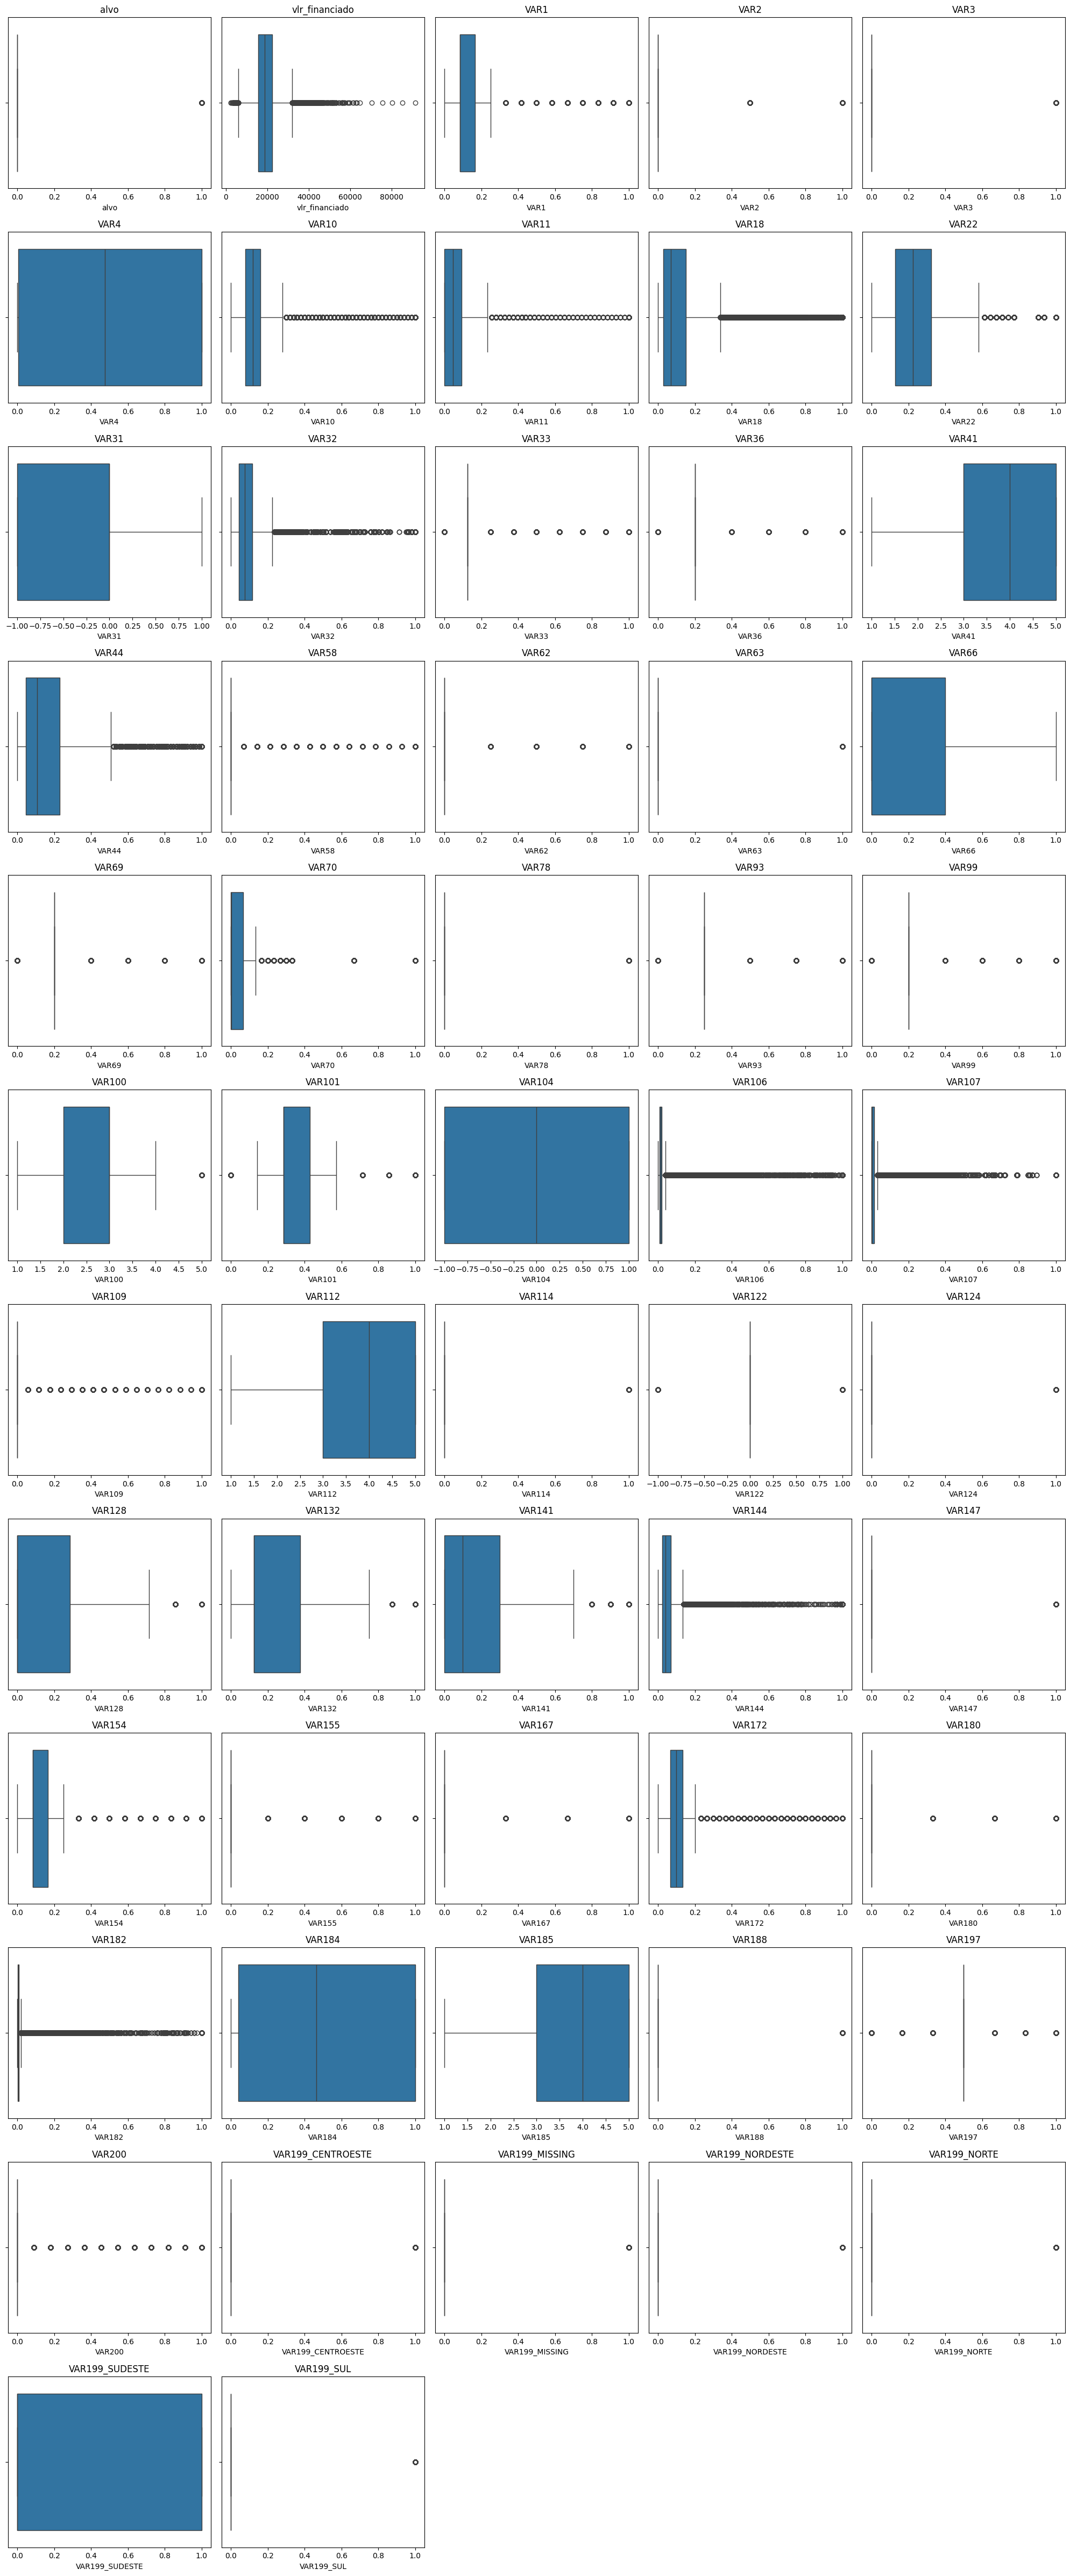

In [49]:
# Outliers
n_cols = 5
n_rows = math.ceil(len(num_cols) / n_cols)

plt.figure(figsize=(n_cols*4, n_rows*4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.tight_layout()

plt.show()

In [50]:
vlr_stats = df['vlr_financiado'].describe()
print("Estatísticas básicas da coluna 'vlr_financiado':")
print(vlr_stats)

Estatísticas básicas da coluna 'vlr_financiado':
count    47730.000000
mean     19182.876149
std       5527.586293
min       2427.880000
25%      15756.697500
50%      18836.810000
75%      22265.402500
max      91283.650000
Name: vlr_financiado, dtype: float64


Analisando possíveis outliers, todos estão dentro de intervalos bem definidos, e os pontos de outliers parecem ser apenas valores distantes da mediana devido a distribuição assimétrica.

A coluna vlr_financiado me chamou a atenção mas olhando o describe dela não achei nada de anormal.

In [51]:
# Análise de correlação
corr_matrix = df[num_cols].corr()

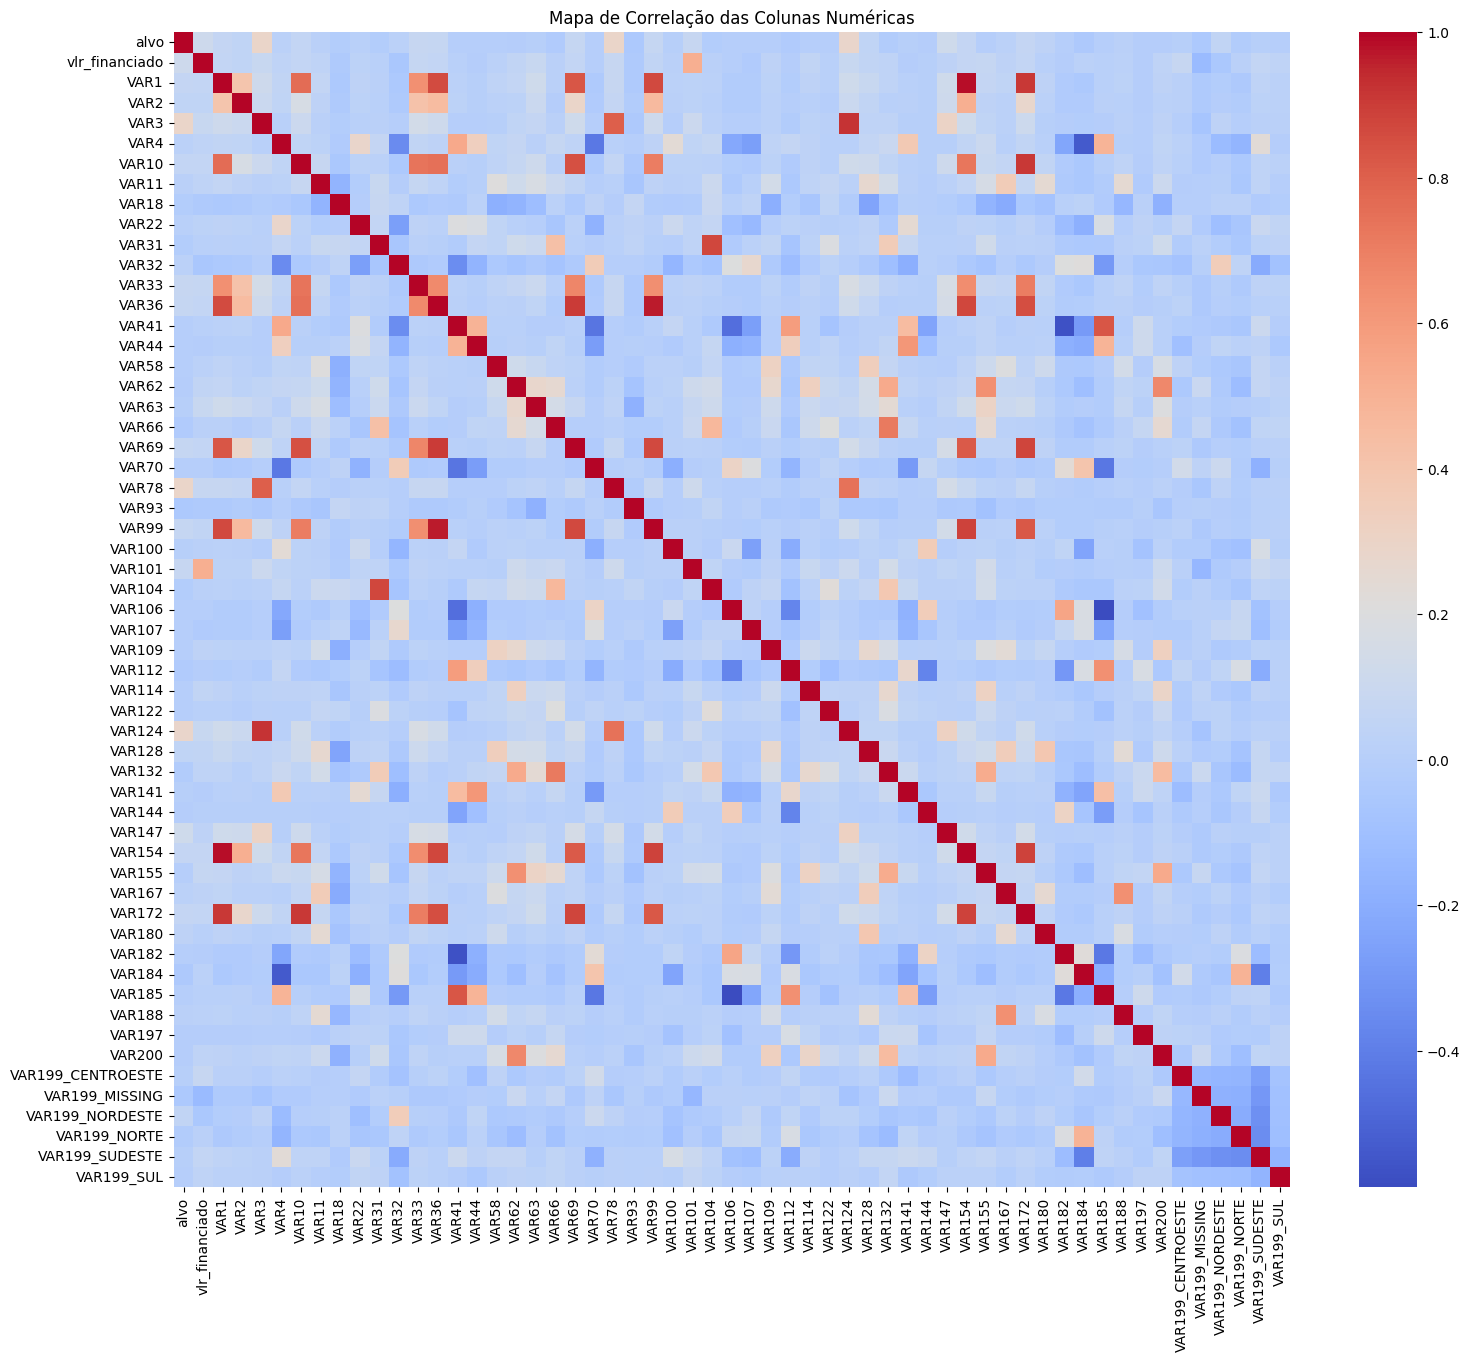

In [52]:
# Plot
plt.figure(figsize=(18,15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Mapa de Correlação das Colunas Numéricas")
plt.show()

Ficou uma imagem enorme e praticamente ilegível, vamos analisar os dados numéricos e selecionar as 15 mais bem correlacionadas

In [53]:
# Correlação da variável alvo com as numéricas
corr_target = corr_matrix['alvo'].sort_values(ascending=False)
print("Correlação das colunas numéricas com o alvo:")
print(corr_target)

Correlação das colunas numéricas com o alvo:
alvo                 1.000000
VAR3                 0.291116
VAR78                0.290276
VAR124               0.283281
VAR147               0.124421
vlr_financiado       0.116523
VAR33                0.080153
VAR101               0.079429
VAR69                0.073234
VAR36                0.072620
VAR99                0.072403
VAR154               0.068054
VAR1                 0.065217
VAR172               0.064300
VAR10                0.057595
VAR199_NORDESTE      0.056882
VAR2                 0.048189
VAR128               0.045585
VAR180               0.034060
VAR167               0.025719
VAR4                 0.021898
VAR32                0.020657
VAR11                0.016938
VAR188               0.014265
VAR22                0.011493
VAR63                0.007585
VAR199_SUDESTE       0.007378
VAR100               0.005298
VAR199_CENTROESTE    0.002894
VAR141               0.001505
VAR58                0.000433
VAR41                0.00

In [54]:
# Pegando as 15 mais bem correlacionadas
top_corr_cols = corr_matrix['alvo'].abs().sort_values(ascending=False).iloc[1:16].index.tolist()
top_corr_cols.append('alvo')

# Subset da matriz de correlação
corr_top = corr_matrix.loc[top_corr_cols, top_corr_cols]

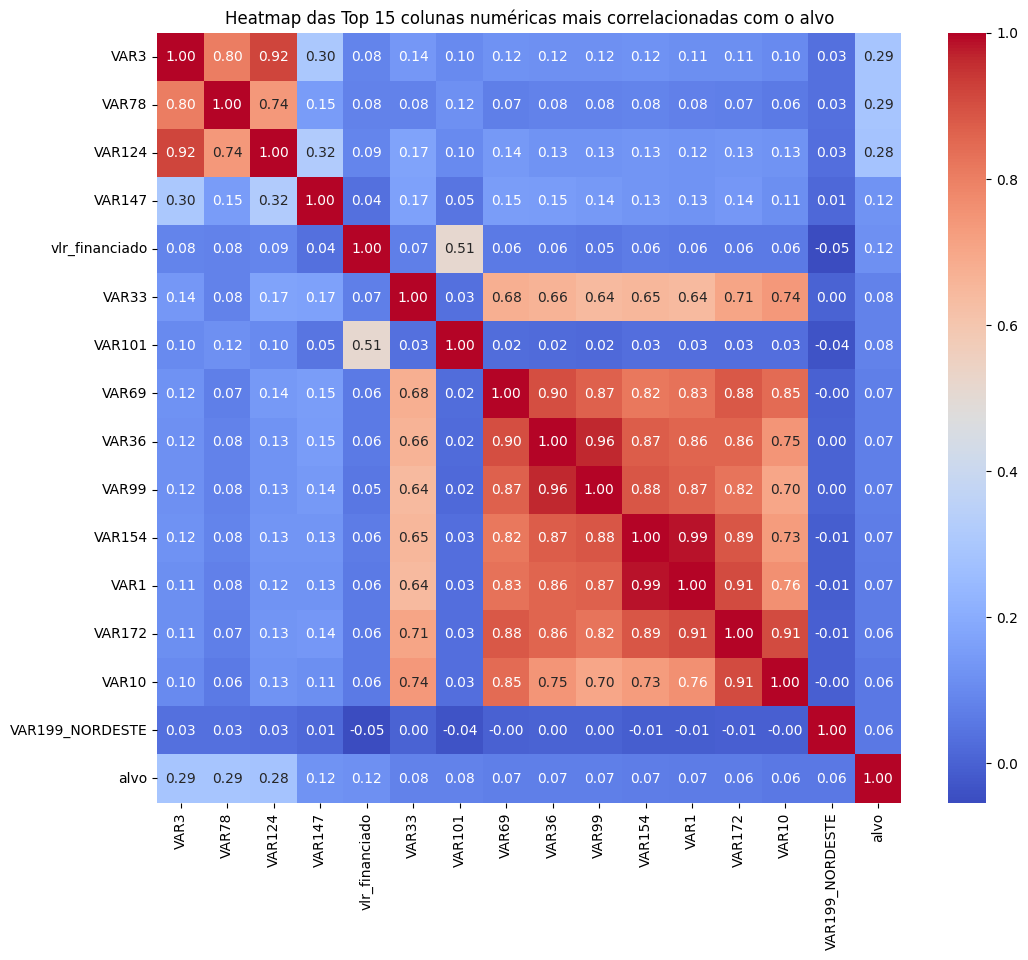

In [55]:
# Plot do heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_top, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Heatmap das Top 15 colunas numéricas mais correlacionadas com o alvo")
plt.show()

In [56]:
corr_target = corr_matrix['alvo']
top15_corr = corr_target.abs().sort_values(ascending=False).iloc[1:16]
top15_corr_table = pd.DataFrame({
    'coluna': top15_corr.index,
    'correlacao': corr_target[top15_corr.index]
}).reset_index(drop=True)
print(top15_corr_table)

             coluna  correlacao
0              VAR3    0.291116
1             VAR78    0.290276
2            VAR124    0.283281
3            VAR147    0.124421
4    vlr_financiado    0.116523
5             VAR33    0.080153
6            VAR101    0.079429
7             VAR69    0.073234
8             VAR36    0.072620
9             VAR99    0.072403
10           VAR154    0.068054
11             VAR1    0.065217
12           VAR172    0.064300
13            VAR10    0.057595
14  VAR199_NORDESTE    0.056882


Nota-se uma alta correlação de algumas variáveis entre si, mas não tão alta assim com a variável alvo.

In [57]:
# Criação e teste de hipóteses
df_fraude = df[df["alvo"] == 1]
df_nao_fraude = df[df["alvo"] == 0]

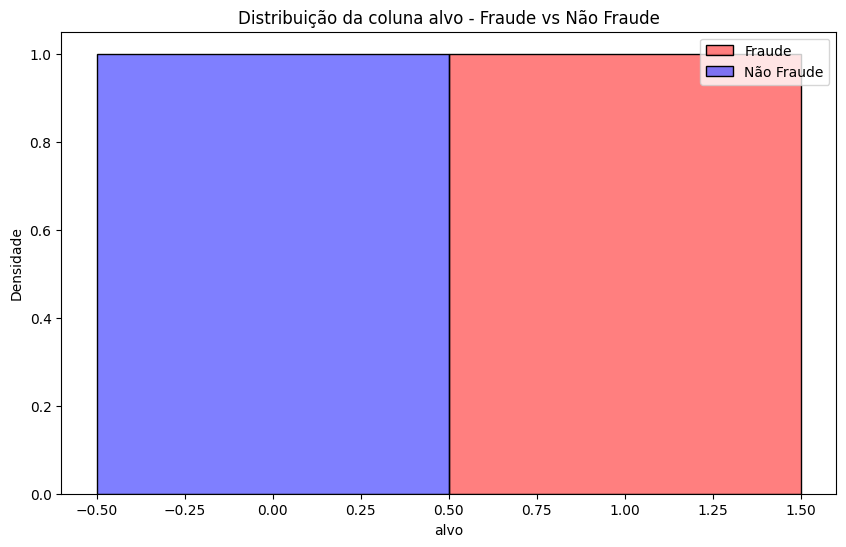

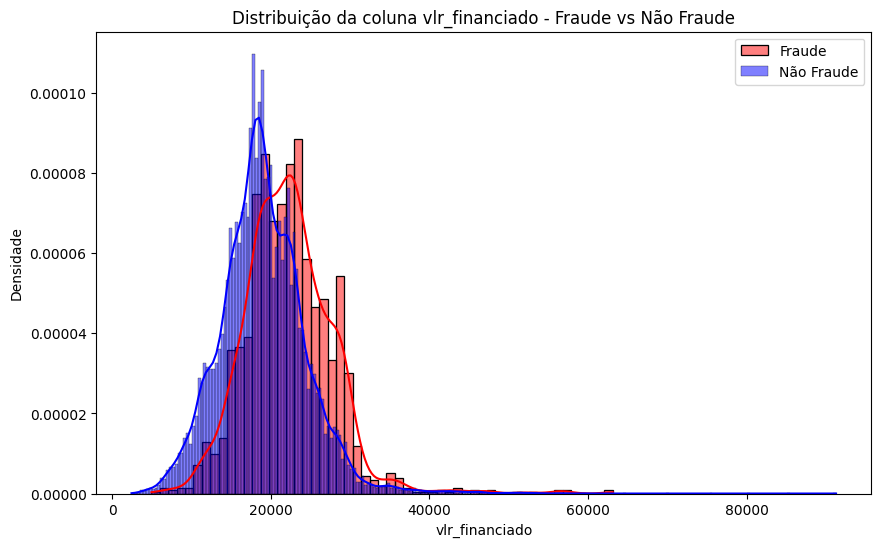

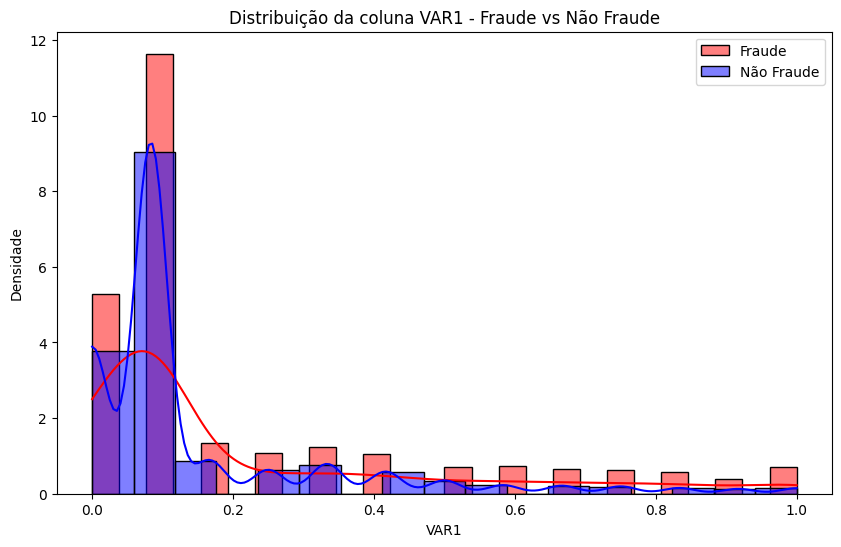

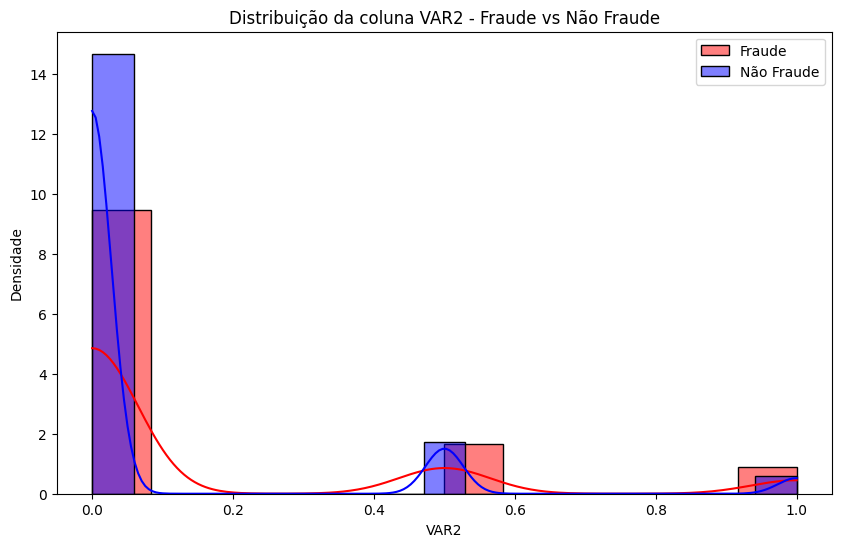

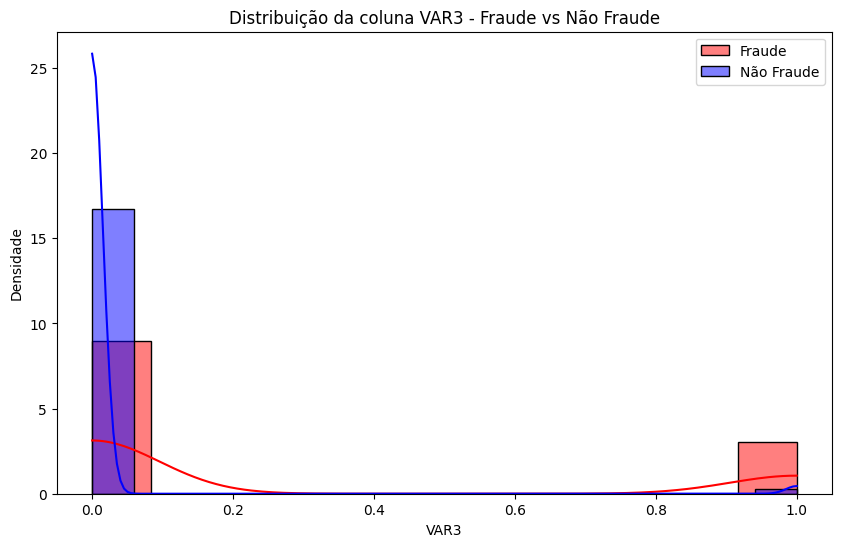

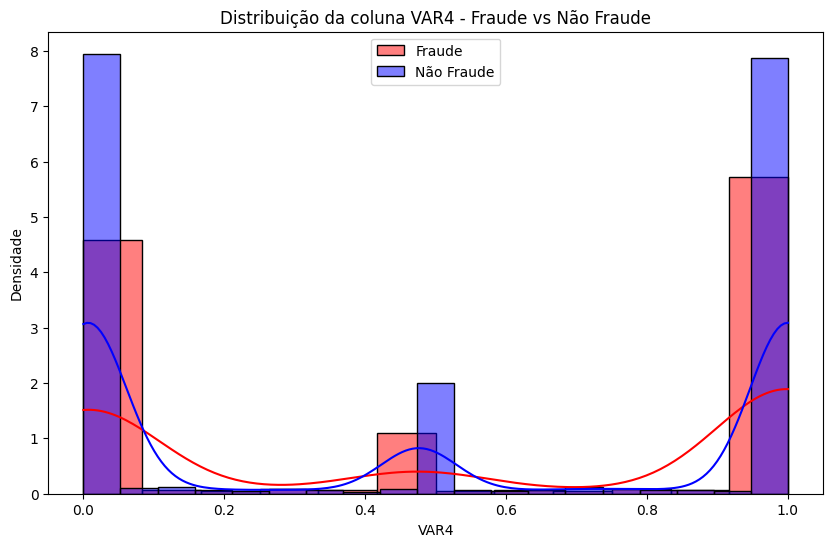

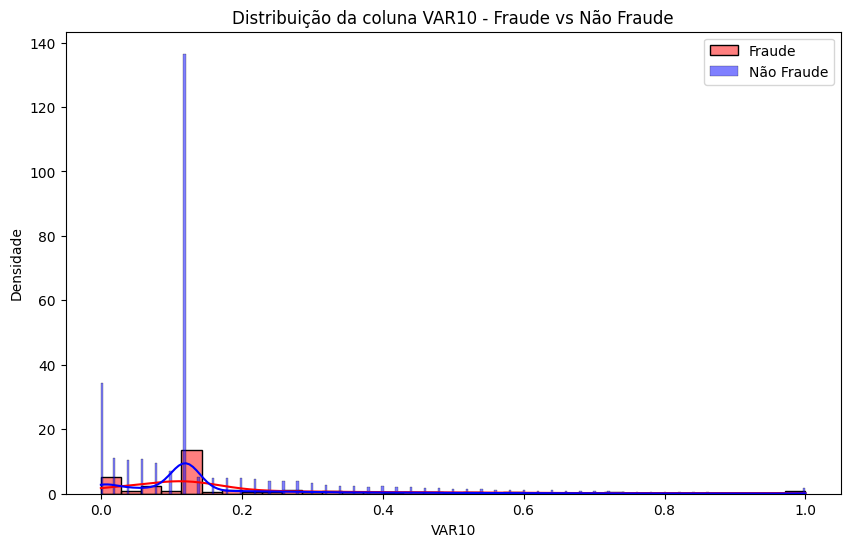

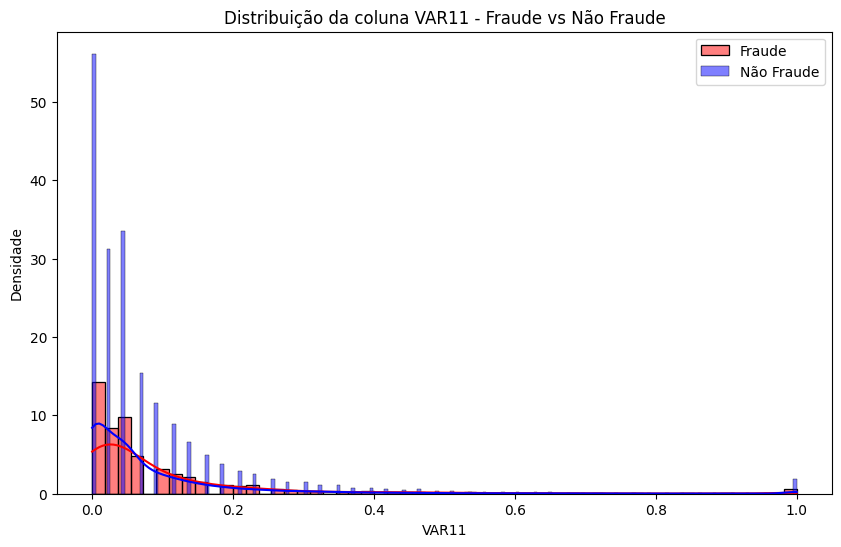

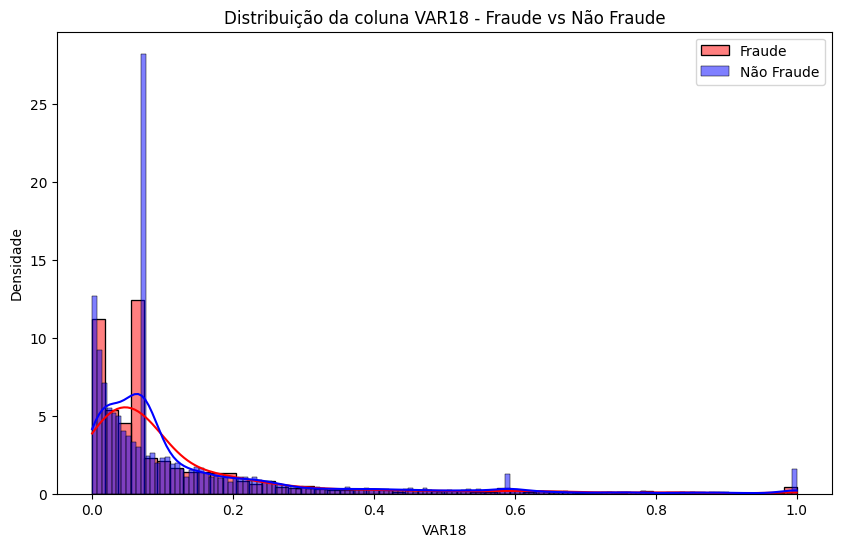

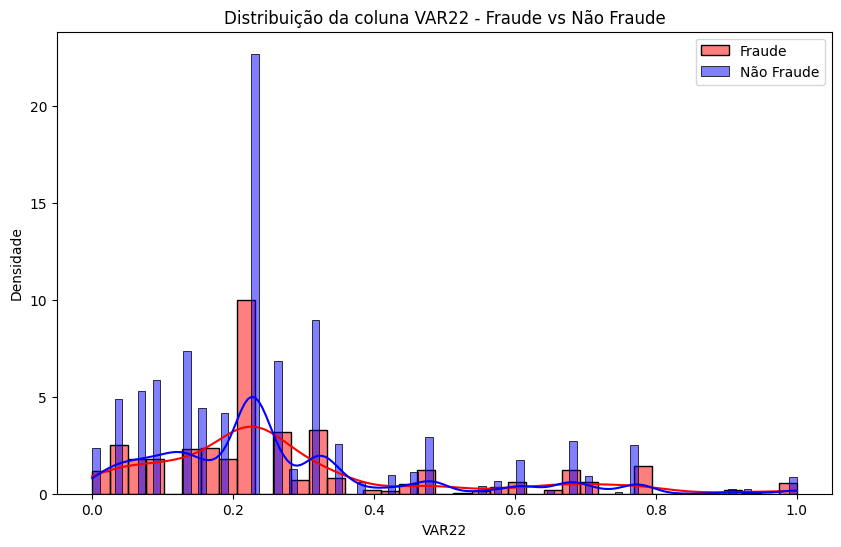

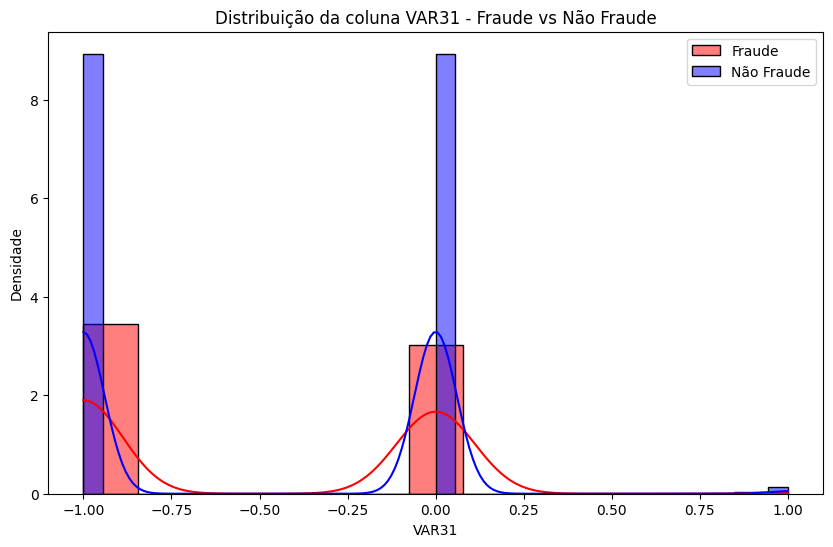

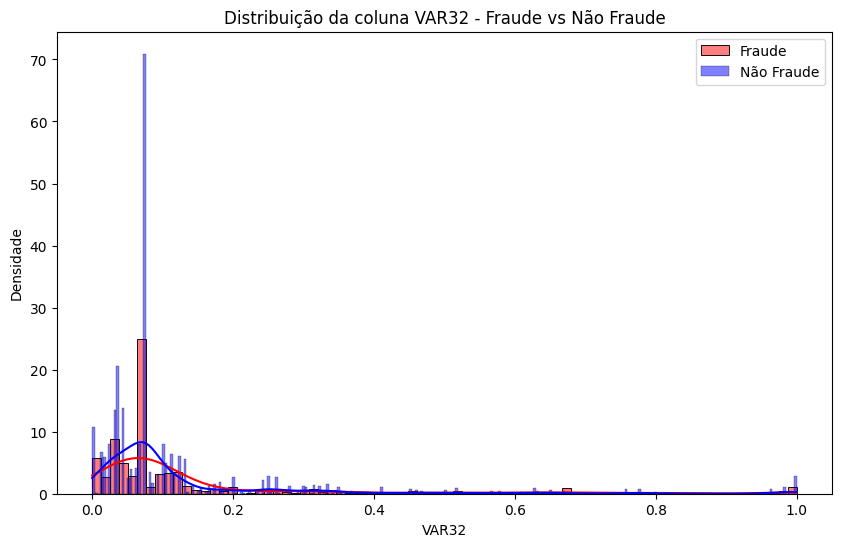

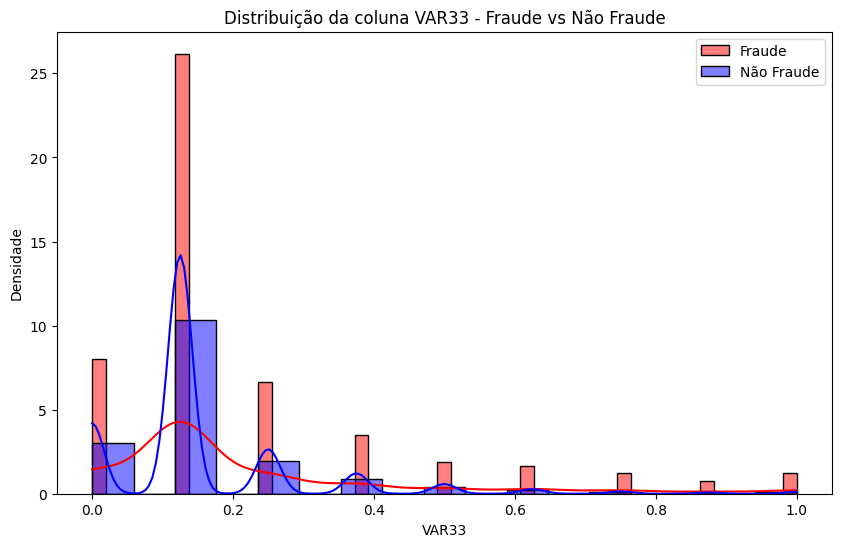

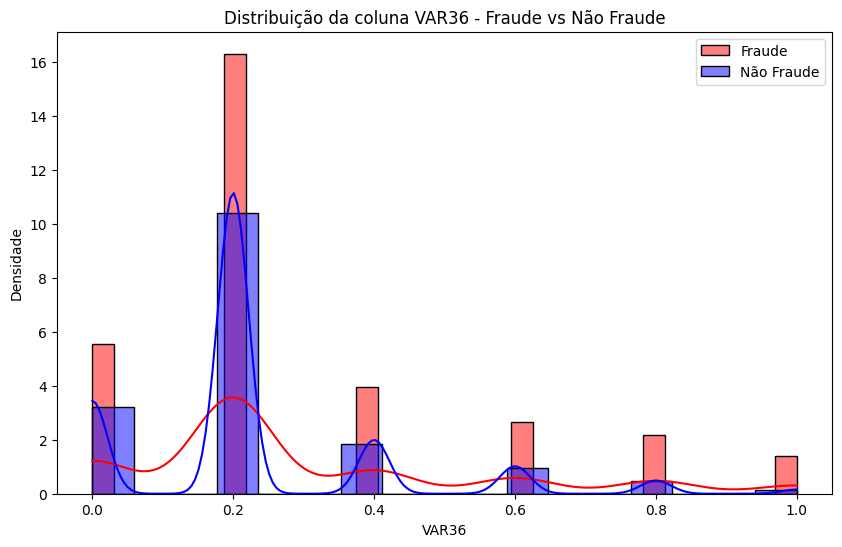

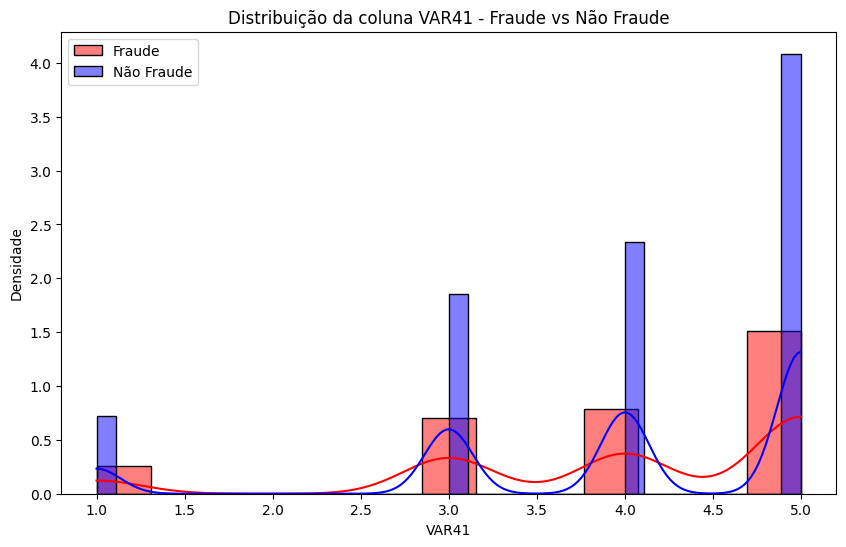

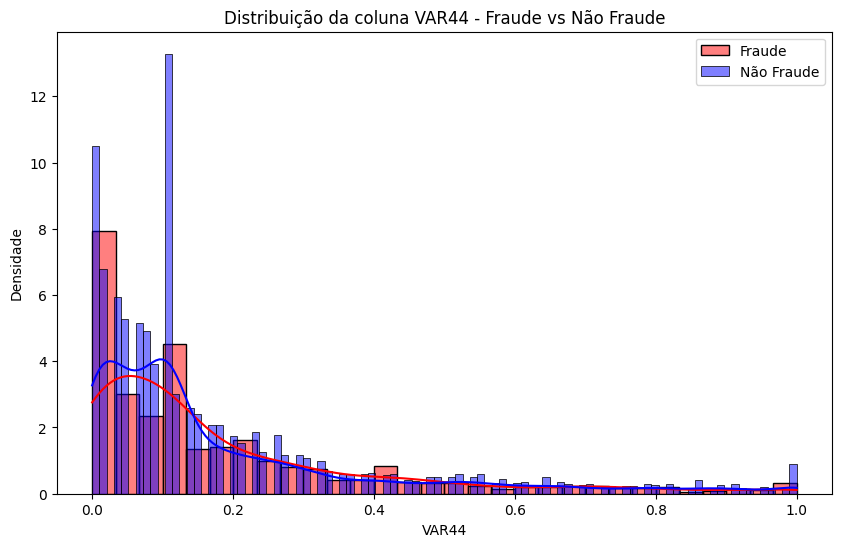

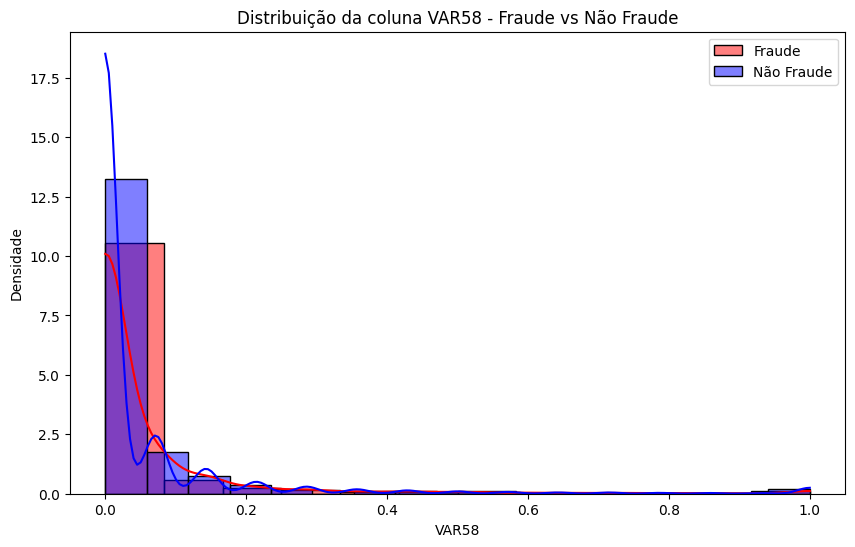

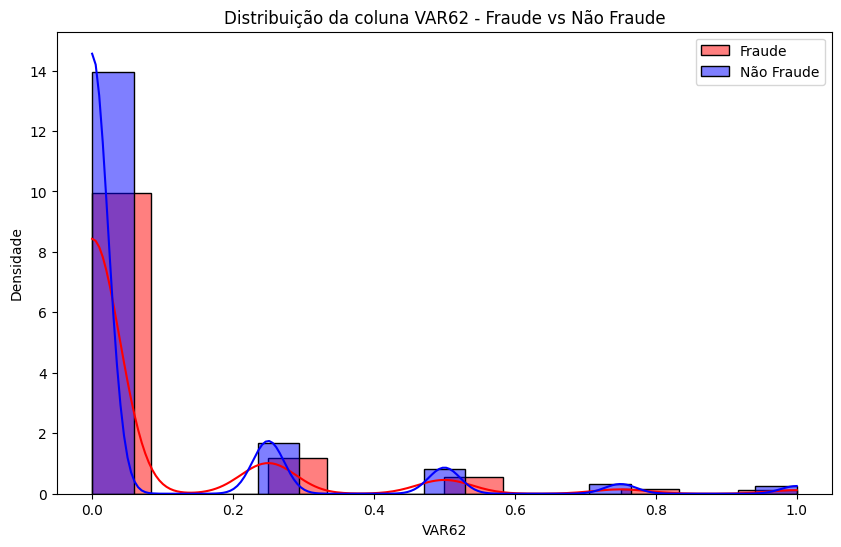

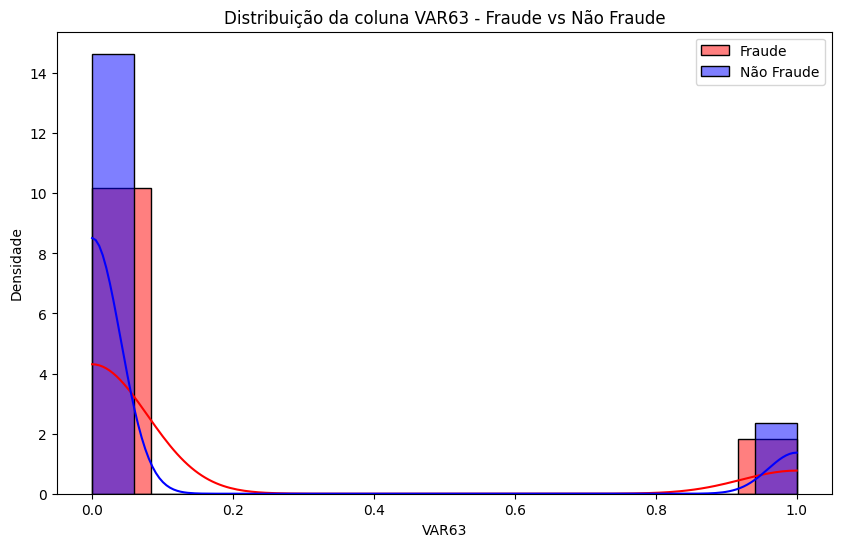

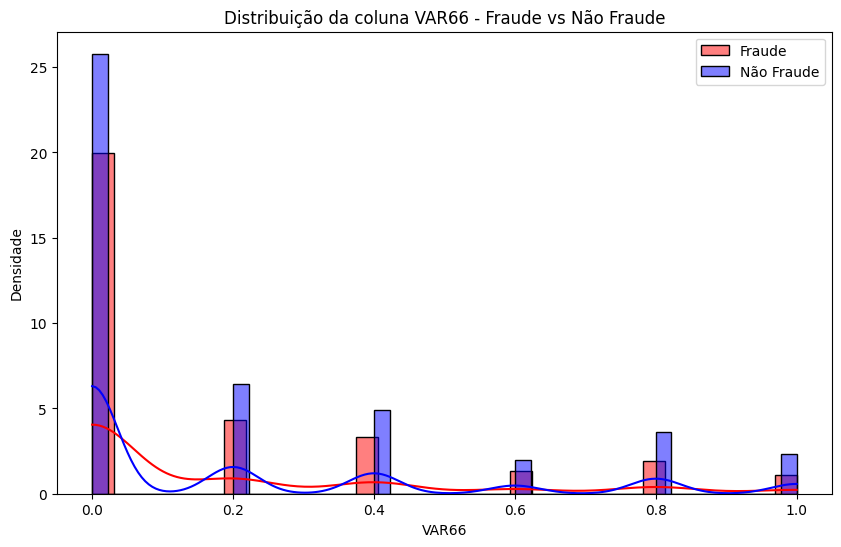

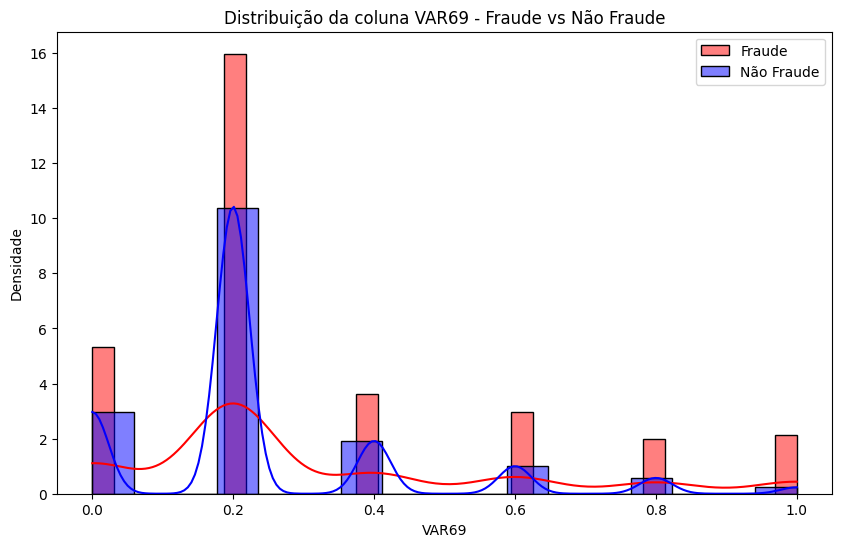

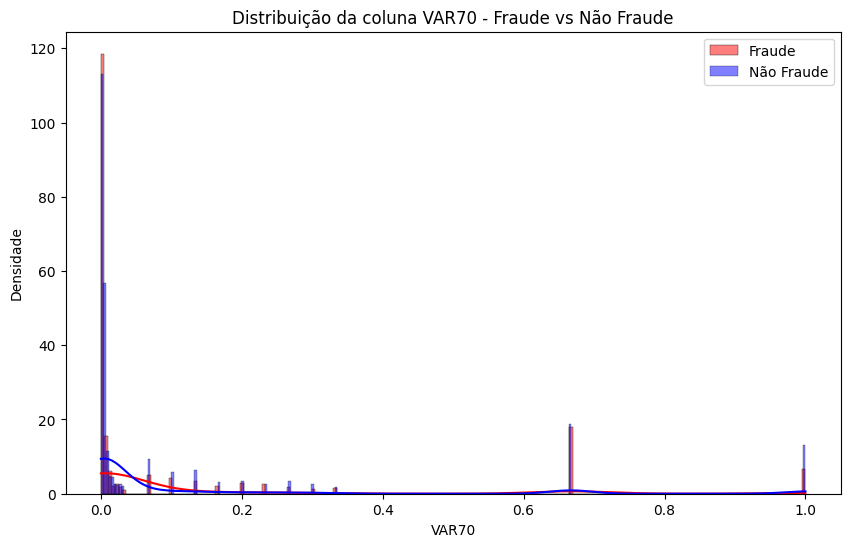

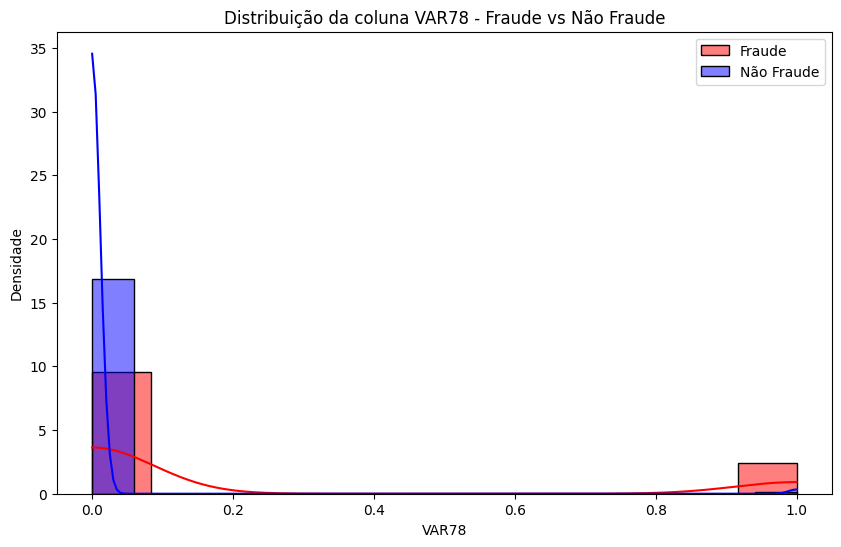

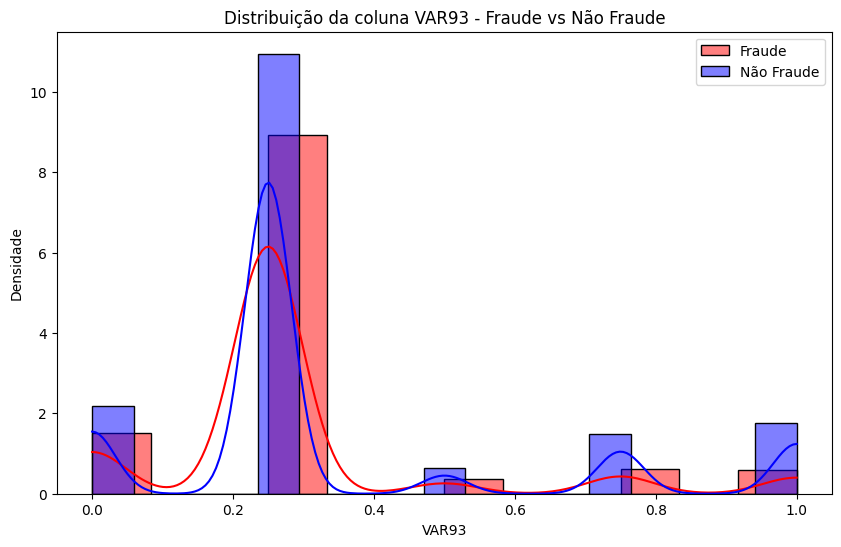

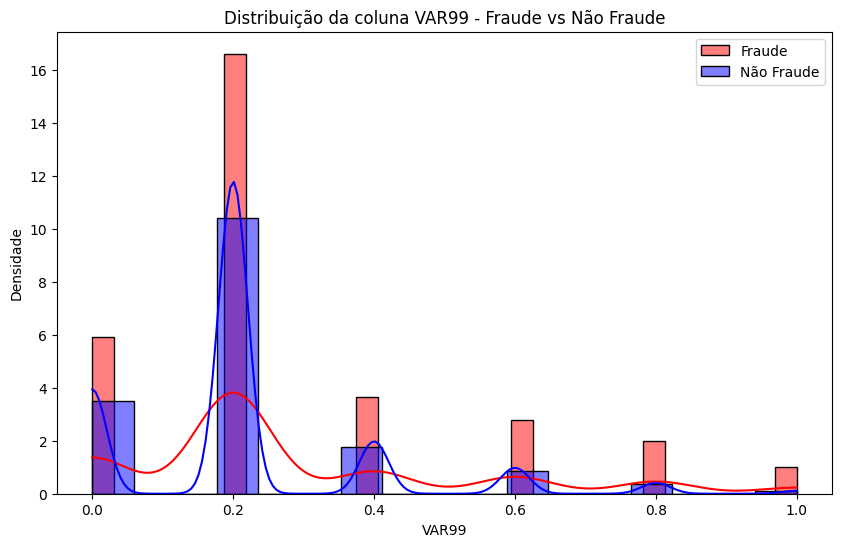

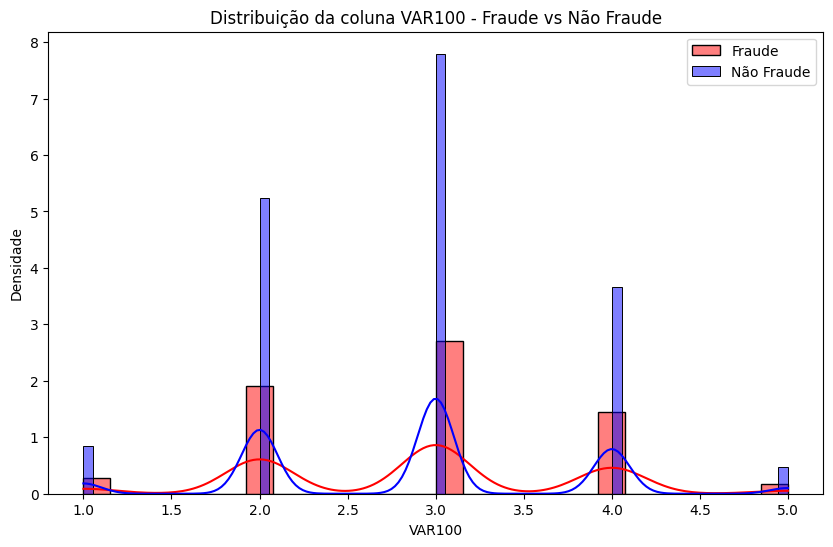

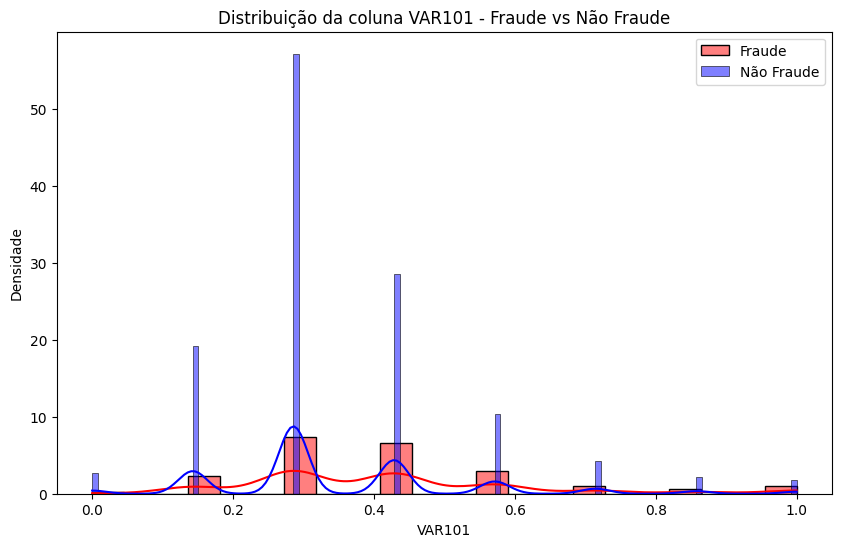

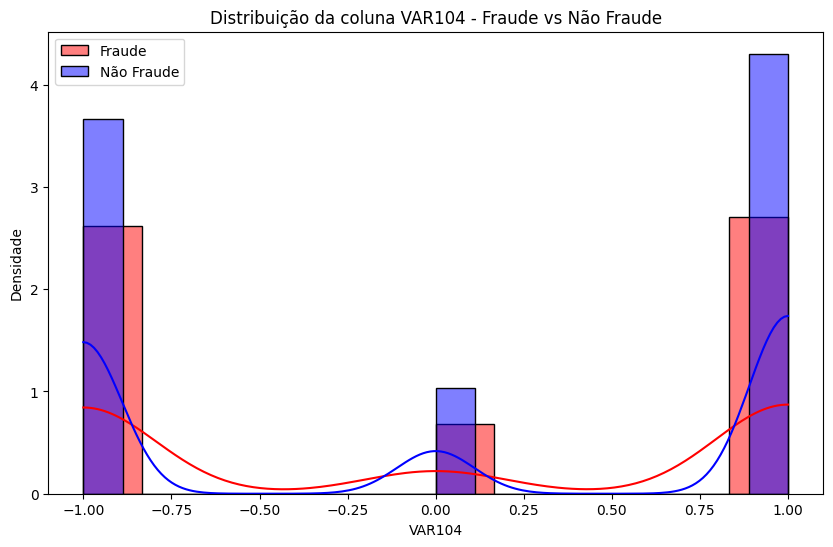

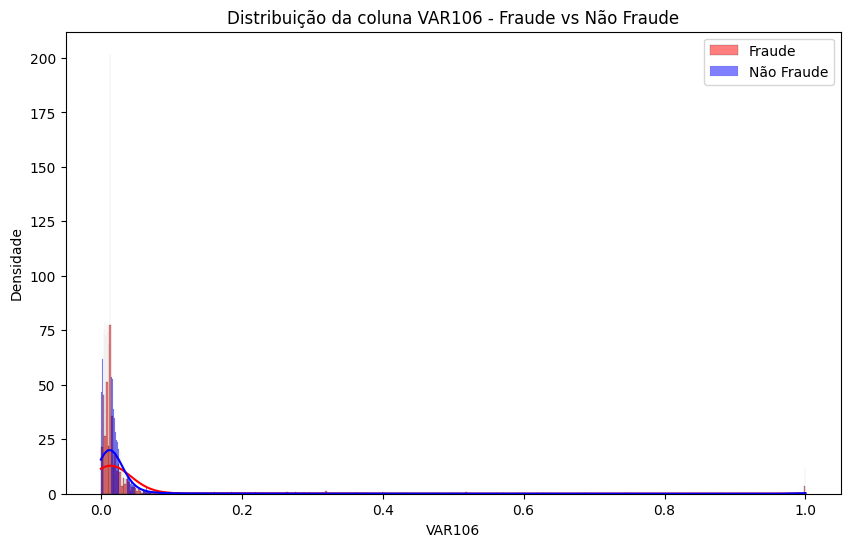

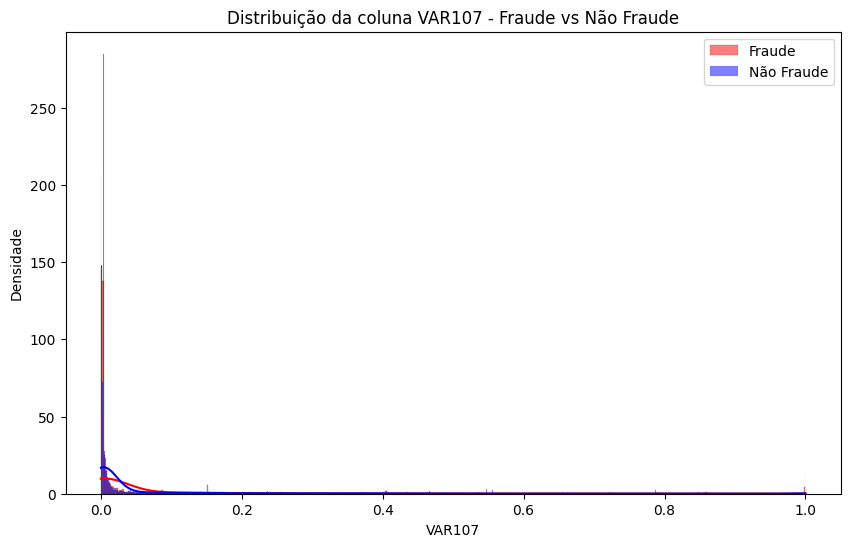

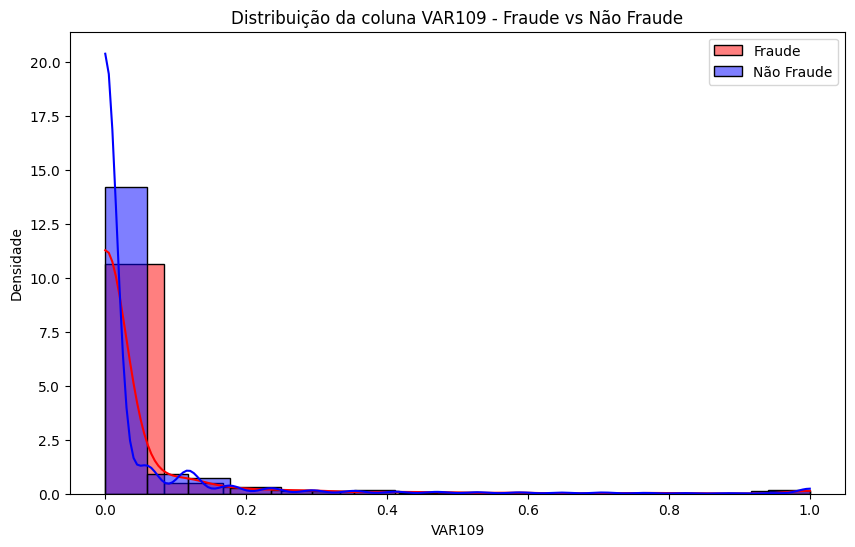

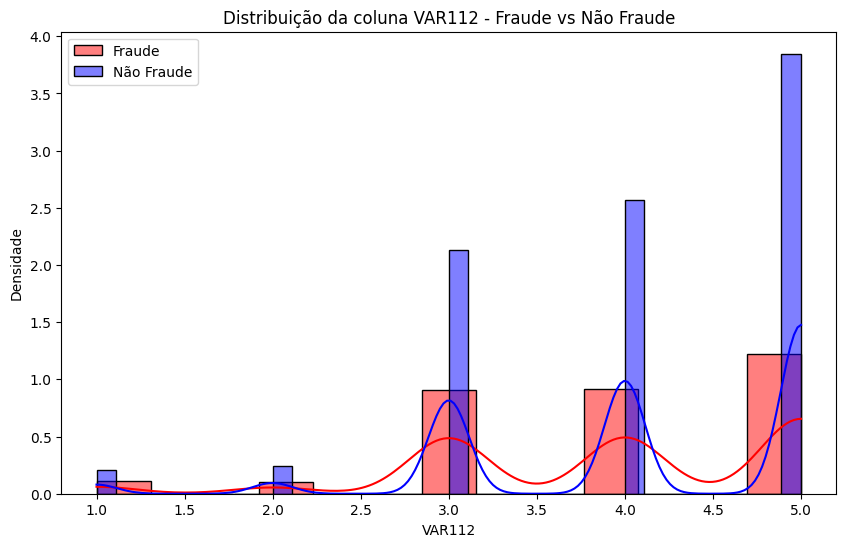

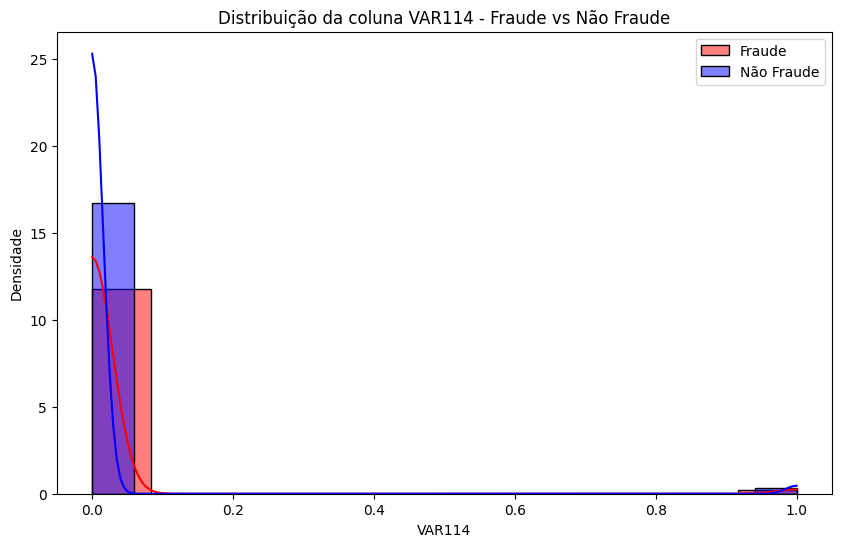

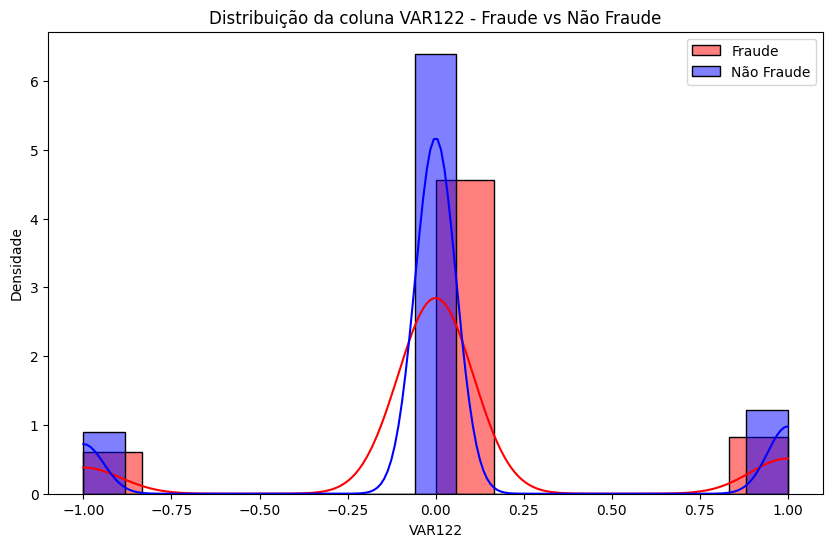

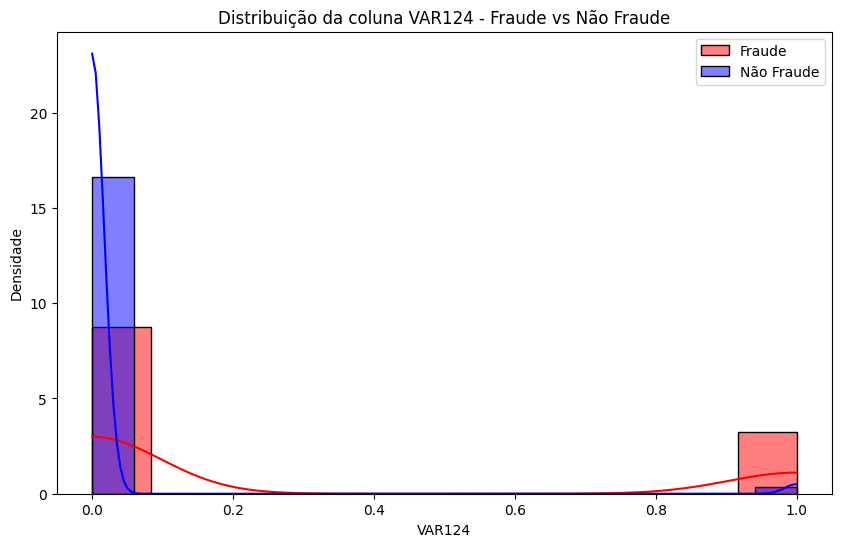

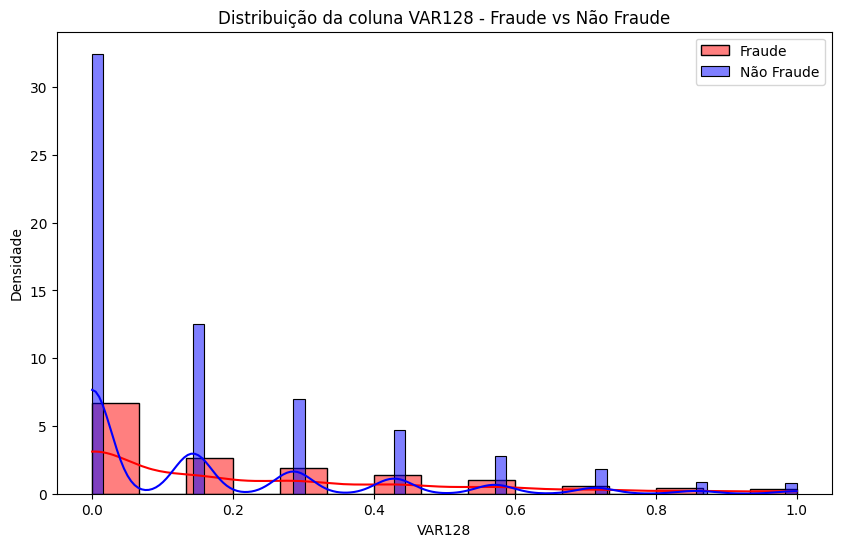

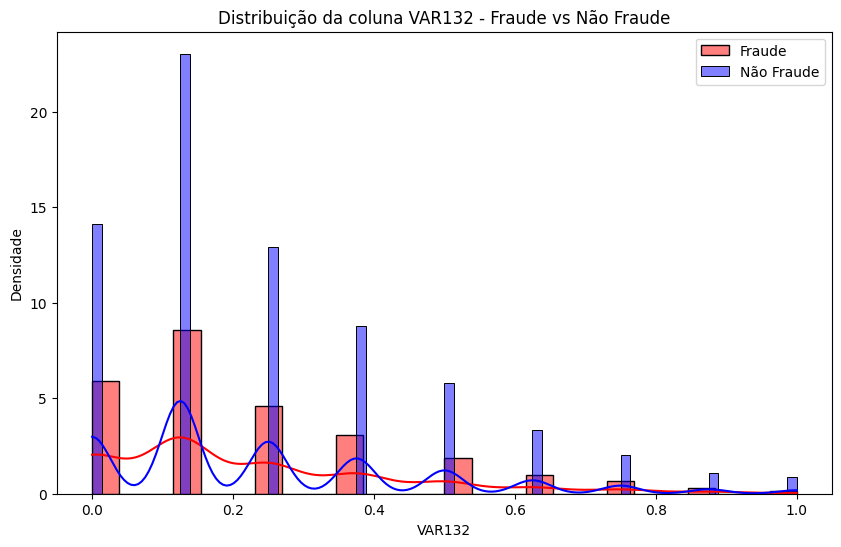

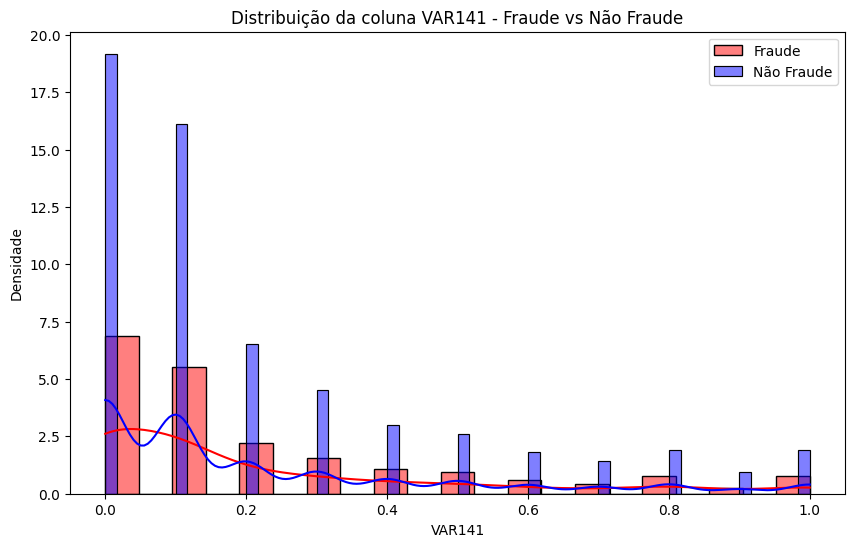

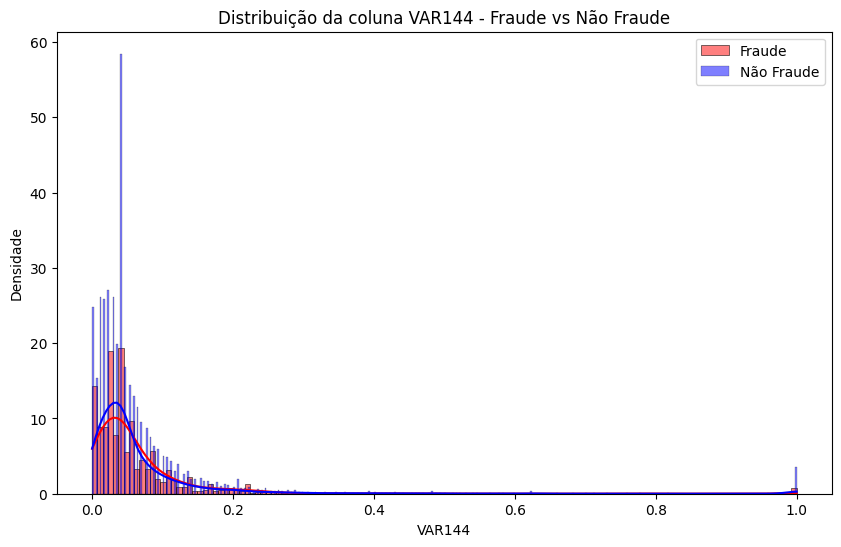

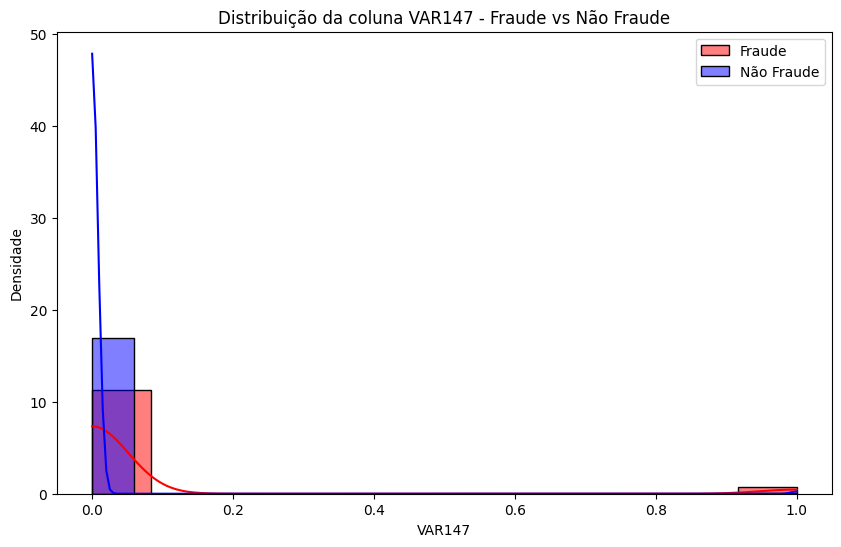

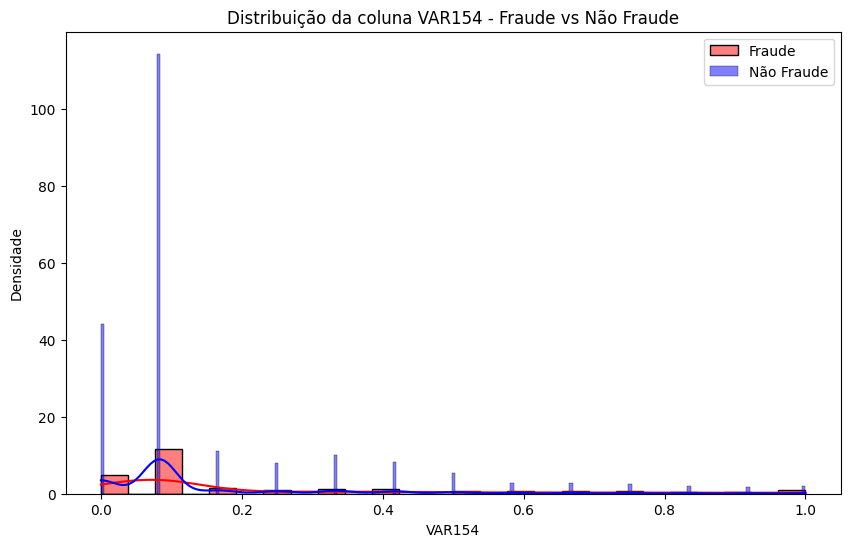

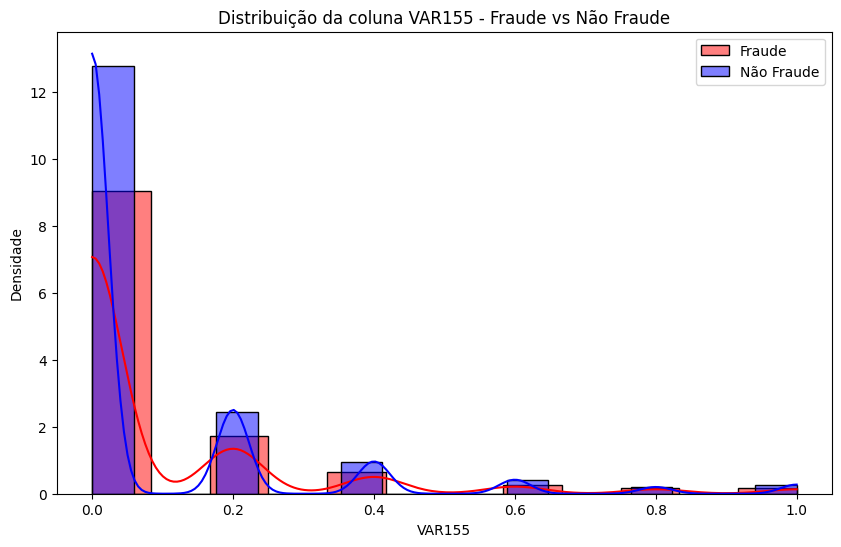

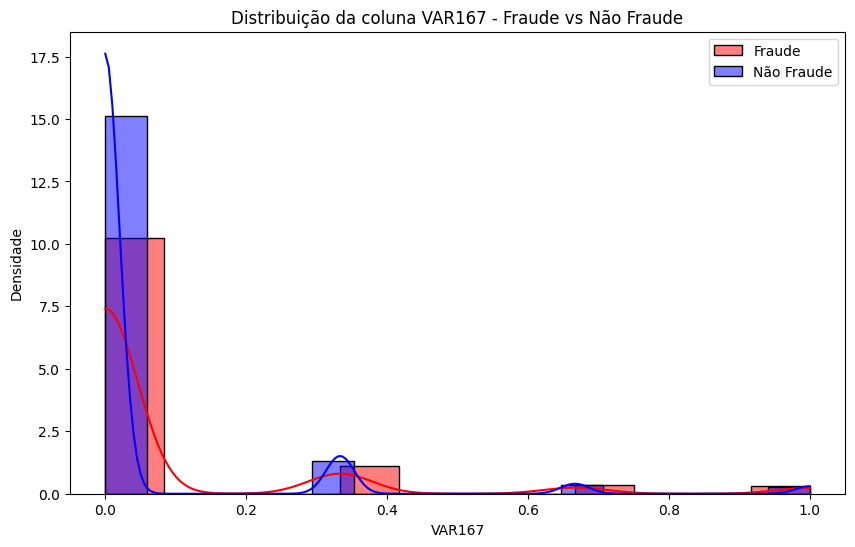

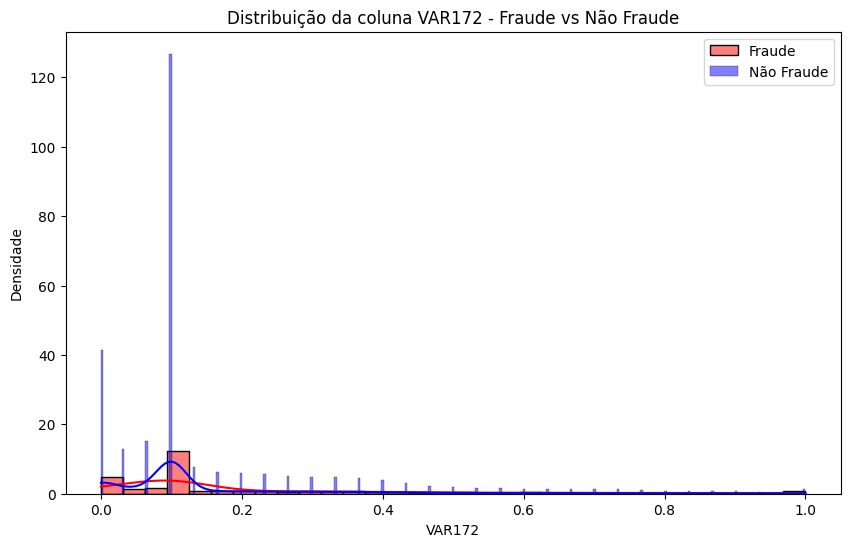

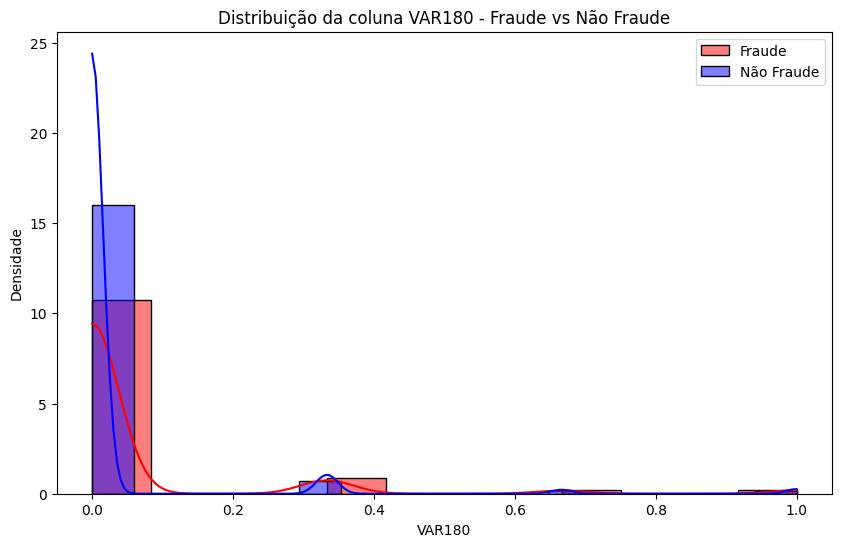

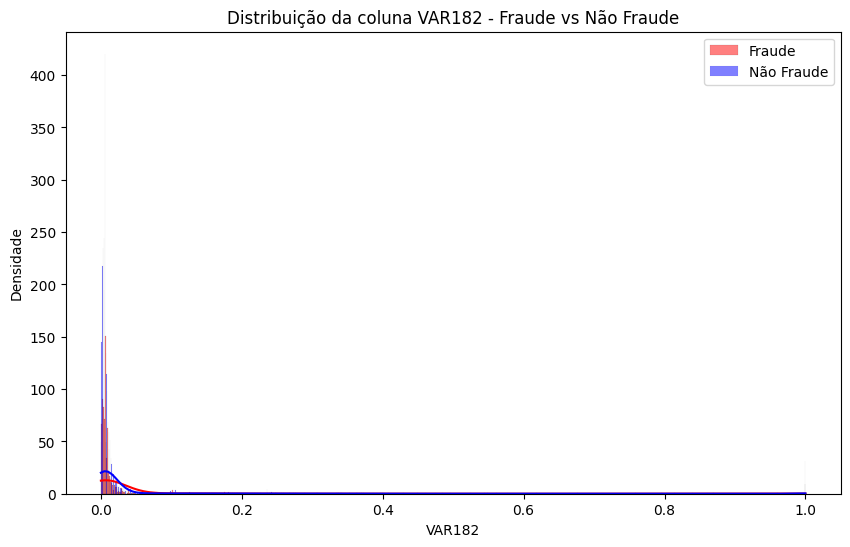

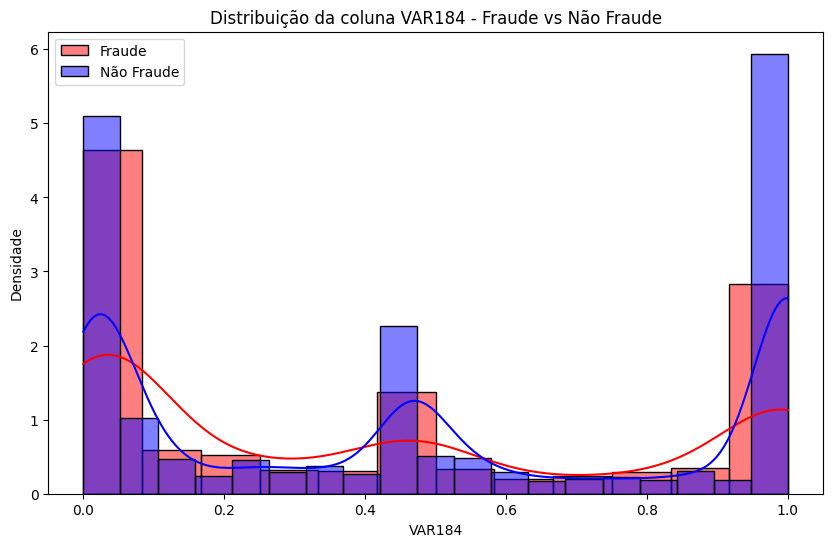

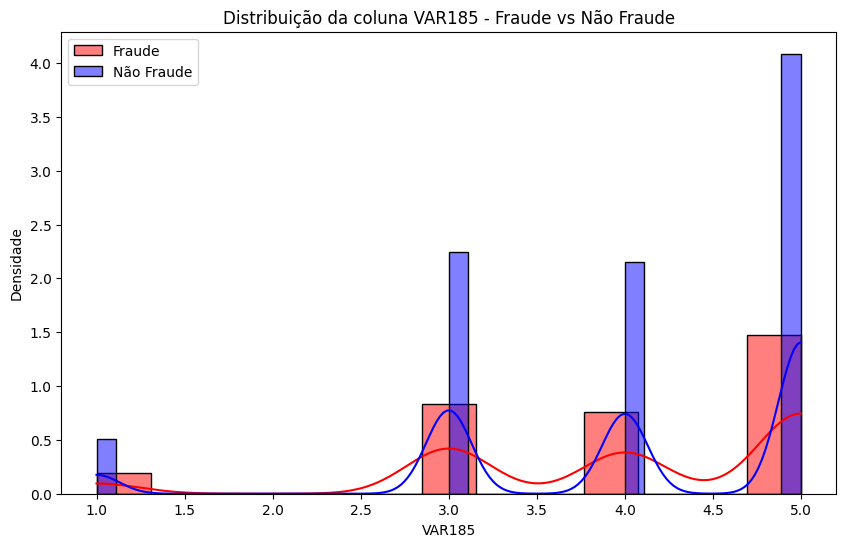

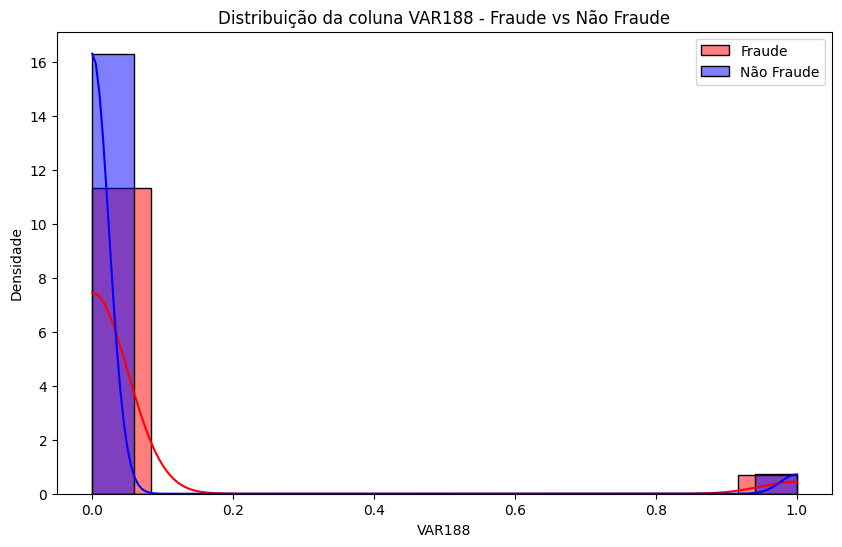

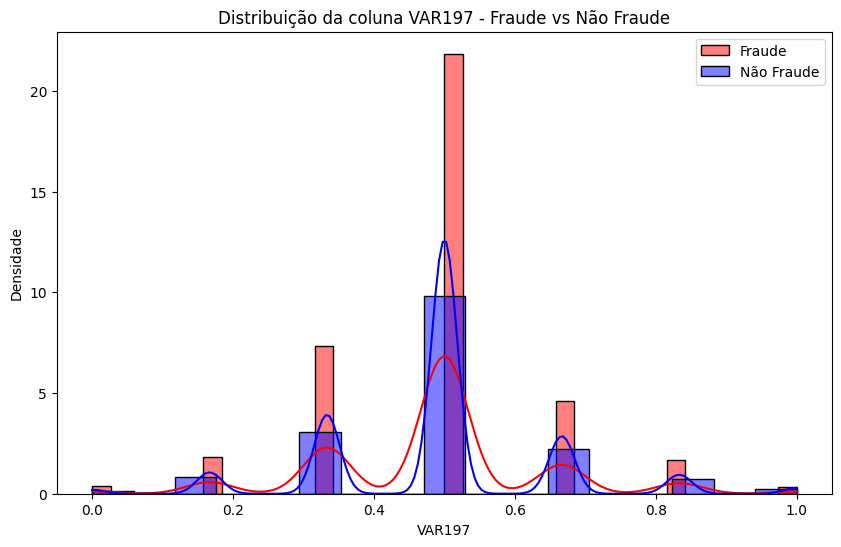

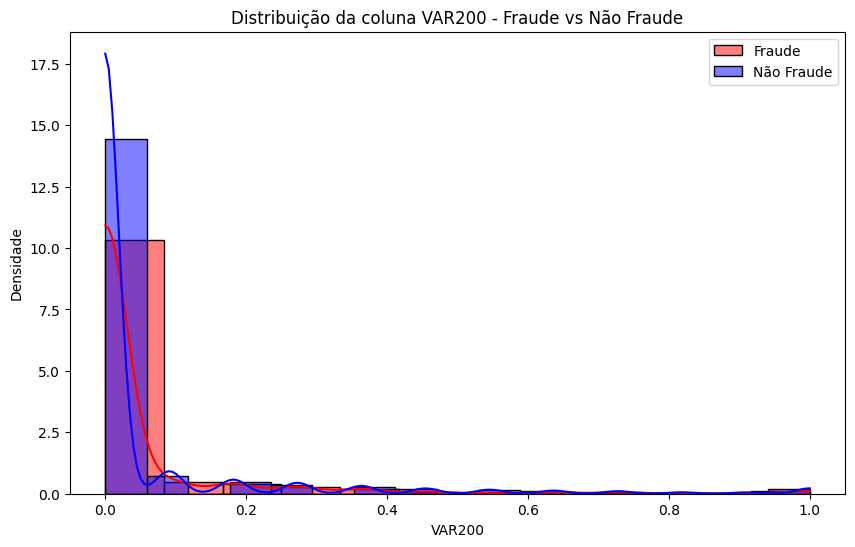

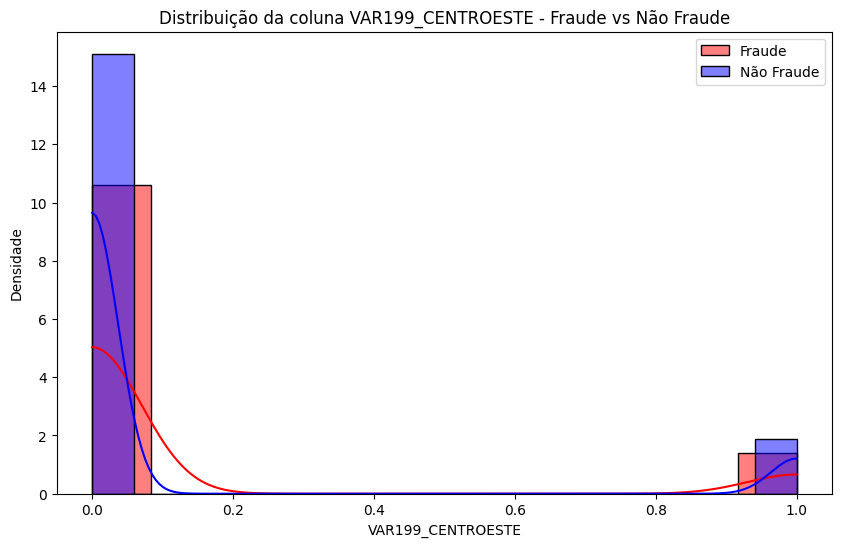

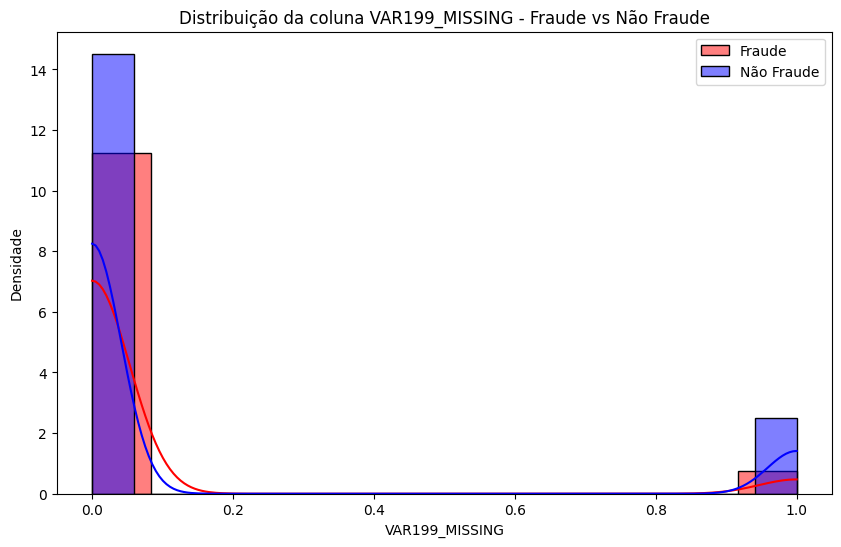

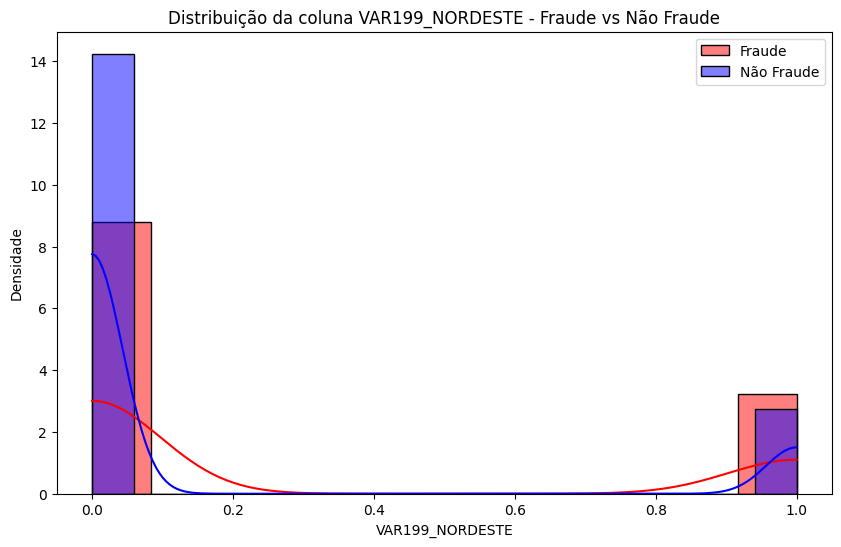

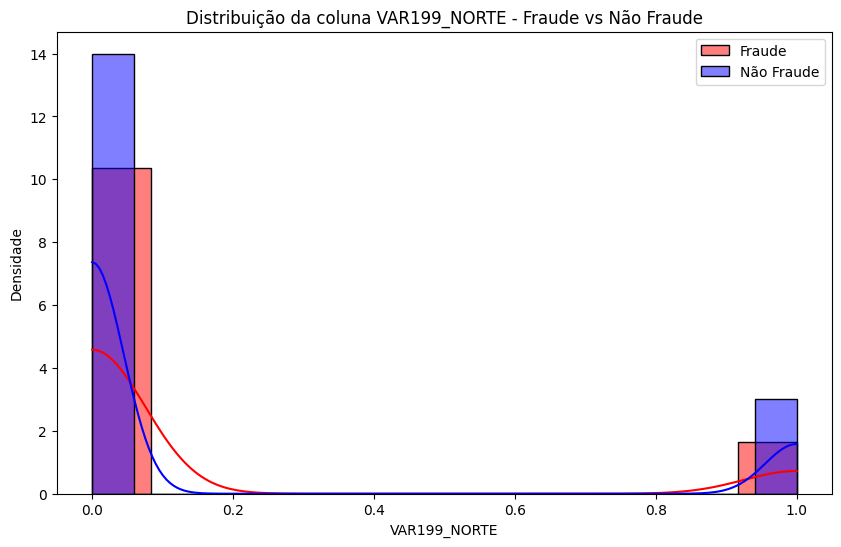

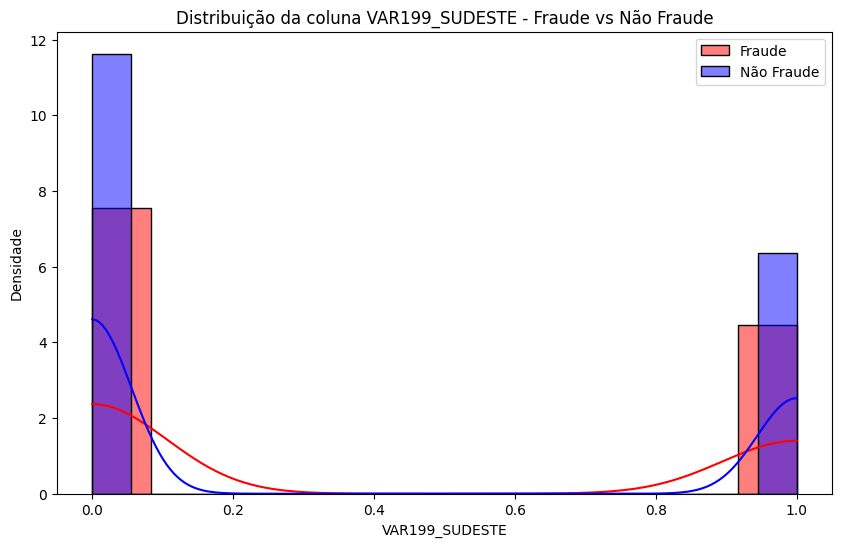

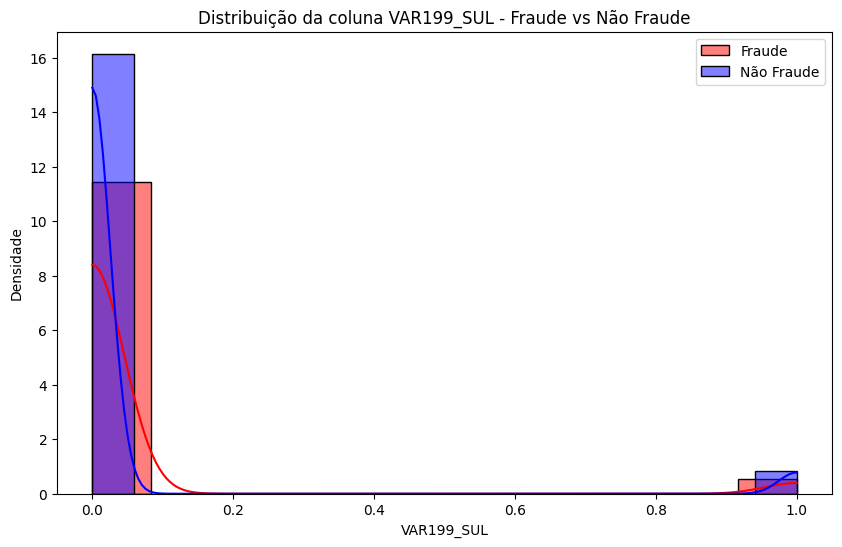

In [58]:
numerics = df.select_dtypes(include=["float64", "int64"]).columns

for col in numerics:
    plt.figure(figsize=(10,6))
    sns.histplot(df_fraude[col], color="red", label="Fraude", kde=True, stat="density", alpha=0.5)
    sns.histplot(df_nao_fraude[col], color="blue", label="Não Fraude", kde=True, stat="density", alpha=0.5)
    plt.title(f"Distribuição da coluna {col} - Fraude vs Não Fraude")
    plt.xlabel(col)
    plt.ylabel("Densidade")
    plt.legend()
    plt.show()

O intuito da análise acima foi procurar pontos de corte em variáveis indicando comportamentos que agreguem valor, criando novas variáveis de maior correlação.

Além disso, identificar variáveis binárias que possam apresentar comportamento de flag como o caso da VAR3 e VAR124, onde com o valor 1 apresenta uma alta densidade de casos de fraude.

Foi identificada uma correlação das variáveis VAR1, VAR33 e VAR99 com o alvo, que a partir de um determinado parâmetro aumenta consideravelmente a quantidade de fraudes presentes.

Também foi identificado o fato de que caso a VAR11 for maior que 0.2 podemos ignorar, e focar apenas nos valores menores ou iguais a 0.2, com uma densidade alta para casos de não fraude.

In [59]:
df_fraude["VAR78xVAR124"] = (df_fraude["VAR78"] * df_fraude['VAR124']).astype(float)
df_nao_fraude["VAR78xVAR124"] = (df_nao_fraude["VAR78"] * df_nao_fraude['VAR124']).astype(float)

/tmp/ipython-input-584728622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fraude["VAR78xVAR124"] = (df_fraude["VAR78"] * df_fraude['VAR124']).astype(float)
/tmp/ipython-input-584728622.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_fraude["VAR78xVAR124"] = (df_nao_fraude["VAR78"] * df_nao_fraude['VAR124']).astype(float)


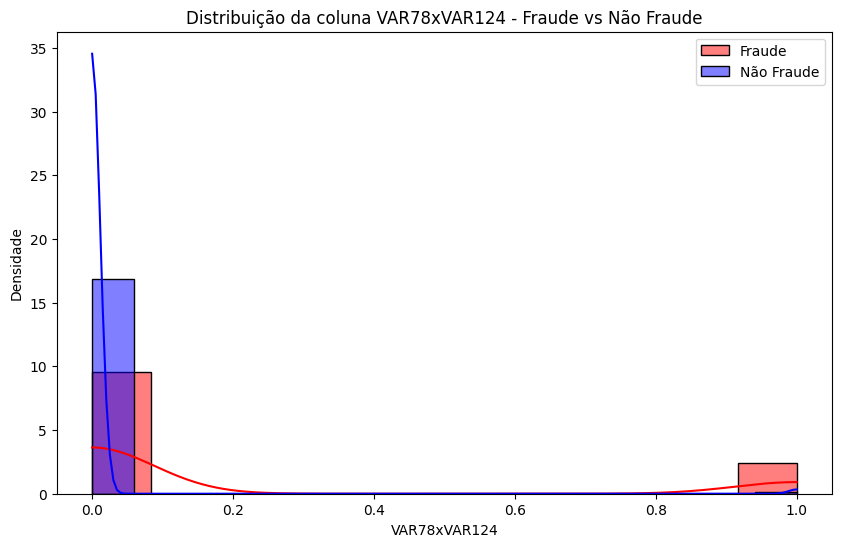

In [60]:
plt.figure(figsize=(10,6))
sns.histplot(df_fraude['VAR78xVAR124'], color="red", label="Fraude", kde=True, stat="density", alpha=0.5)
sns.histplot(df_nao_fraude['VAR78xVAR124'], color="blue", label="Não Fraude", kde=True, stat="density", alpha=0.5)
plt.title(f"Distribuição da coluna VAR78xVAR124 - Fraude vs Não Fraude")
plt.xlabel('VAR78xVAR124')
plt.ylabel("Densidade")
plt.legend()
plt.show()

In [61]:
# Criando as novas variáveis com base nas regras
df["VAR1_MAIOR_07"] = (df["VAR1"] > 0.7).astype(int)
df["VAR33_1_25"] = (df["VAR33"] == 0.125).astype(int)
df["VAR33_MAIOR_07"] = (df["VAR33"] > 0.7).astype(int)
df["VAR99_MAIOR_IGUAL_08"] = (df["VAR99"] >= 0.8).astype(int)
df["VAR11_clip"] = df["VAR11"].clip(upper=0.2)
df["VAR197_05"] = (df["VAR197"] == 0.5).astype(int)
df["VAR78xVAR124"] = (df["VAR78"] * df['VAR124']).astype(float)

In [62]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [63]:
text_cols_remaining

['VAR52', 'VAR103', 'VAR119', 'VAR175']

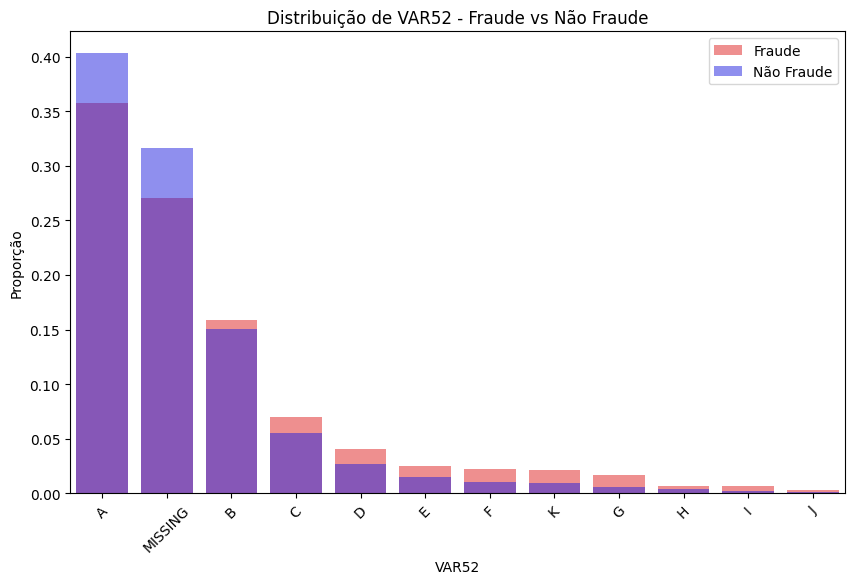

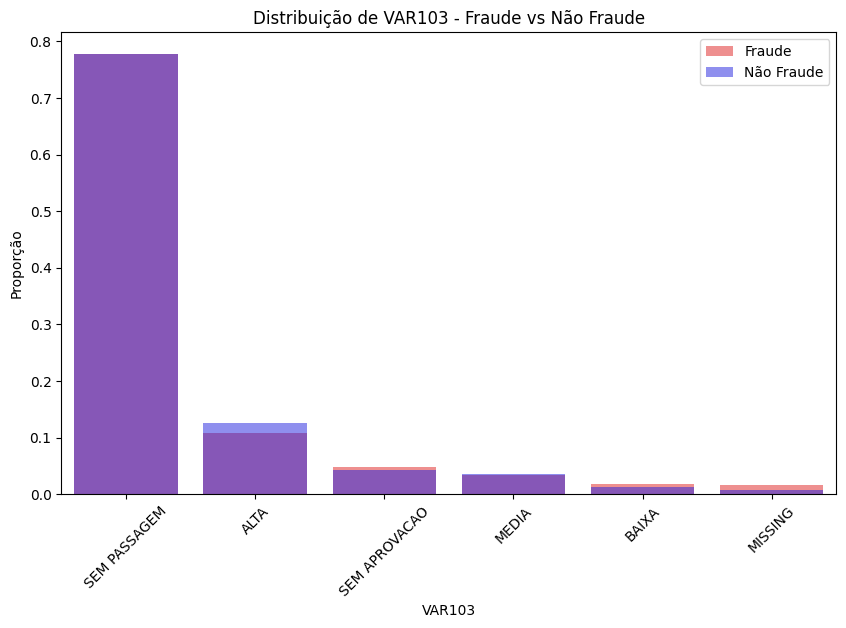

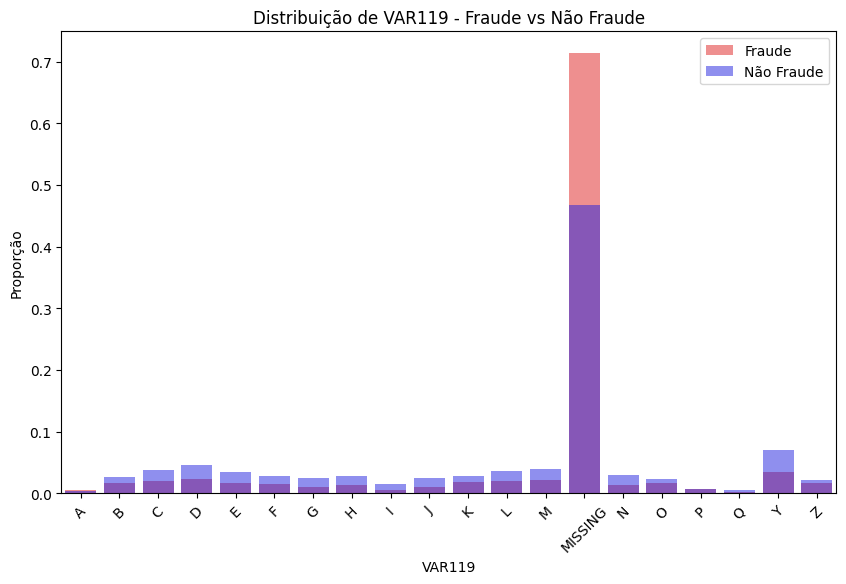

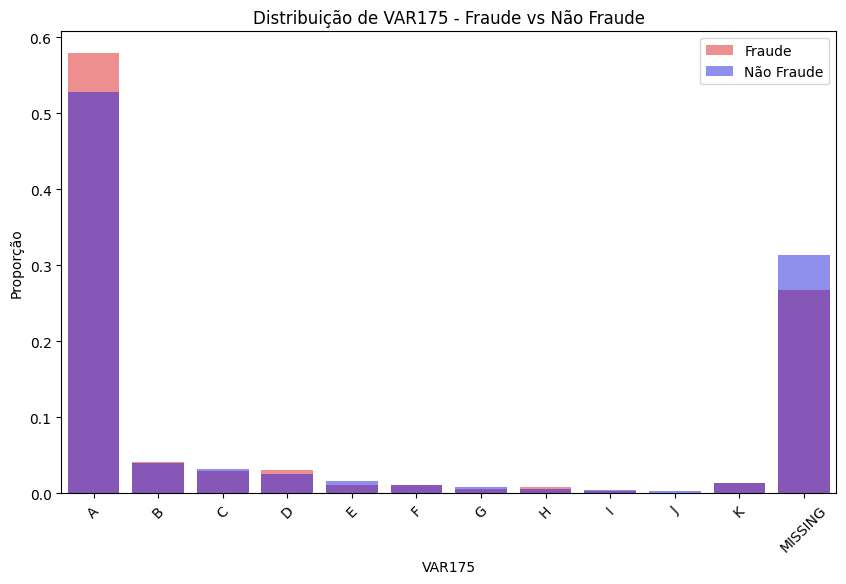

In [64]:
# Analisando o mesmo só que para colunas de categorias, antes de realizar um possível Target Encoding
for col in text_cols_remaining:
    plt.figure(figsize=(10,6))

    # Proporção
    fraude_prop = df_fraude[col].value_counts(normalize=True)
    nao_fraude_prop = df_nao_fraude[col].value_counts(normalize=True)

    plot_df = pd.DataFrame({
        'categoria': fraude_prop.index.union(nao_fraude_prop.index),
        'fraude': fraude_prop.reindex(fraude_prop.index.union(nao_fraude_prop.index), fill_value=0).values,
        'nao_fraude': nao_fraude_prop.reindex(fraude_prop.index.union(nao_fraude_prop.index), fill_value=0).values
    })

    sns.barplot(x='categoria', y='fraude', data=plot_df, color='red', alpha=0.5, label='Fraude')
    sns.barplot(x='categoria', y='nao_fraude', data=plot_df, color='blue', alpha=0.5, label='Não Fraude')

    plt.title(f"Distribuição de {col} - Fraude vs Não Fraude")
    plt.ylabel("Proporção")
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()


Para as variáveis 103, 119 e 175 não foram encontradas diferenças significativas nas proporções dos datasets de fraude e não fraude. Logo, são variáveis a serem descartadas.

Já a variável 52 apresenta um comportamento interessante. Será criada uma coluna binária caso seja uma letra de alto risco (F,G,H,I,J,K) e será feito um target encoding após a separação entre treino e teste.

In [65]:
alto_risco = ['F', 'G', 'H', 'I', 'J', 'K']
df['VAR52_ALTO_RISCO'] = df['VAR52'].isin(alto_risco).astype(int)

In [66]:
print(df[['VAR52', 'VAR52_ALTO_RISCO']].head(10))
print(df['VAR52_ALTO_RISCO'].value_counts())

     VAR52  VAR52_ALTO_RISCO
0        F                 1
1  MISSING                 0
2        A                 0
3        A                 0
4  MISSING                 0
5        B                 0
6  MISSING                 0
7  MISSING                 0
8        A                 0
9        B                 0
VAR52_ALTO_RISCO
0    46060
1     1670
Name: count, dtype: int64


In [67]:
top15_corr

VAR3               0.291116
VAR78              0.290276
VAR124             0.283281
VAR147             0.124421
vlr_financiado     0.116523
VAR33              0.080153
VAR101             0.079429
VAR69              0.073234
VAR36              0.072620
VAR99              0.072403
VAR154             0.068054
VAR1               0.065217
VAR172             0.064300
VAR10              0.057595
VAR199_NORDESTE    0.056882
Name: alvo, dtype: float64

In [68]:
# Mantendo apenas colunas com alta correlação com o alvo, evitando duplicadas entre si
threshold = 0.85

# Lista de colunas que vamos manter
selected_cols = []

# Iterando pelas top_corr_cols (menos o alvo)
for col in top_corr_cols:
    if all(abs(corr_top.loc[col, sel_col]) < threshold for sel_col in selected_cols):
        selected_cols.append(col)

In [69]:
# Mostrando colunas selecionadas
print("Colunas selecionadas da top15_corr, sem alta redundância:")
print(selected_cols)

Colunas selecionadas da top15_corr, sem alta redundância:
['VAR3', 'VAR78', 'VAR147', 'vlr_financiado', 'VAR33', 'VAR101', 'VAR69', 'VAR154', 'VAR10', 'VAR199_NORDESTE', 'alvo']


In [70]:
manual_features = [
    'mes_ref',
    'VAR1_MAIOR_07',
    'VAR33_1_25',
    'VAR33_MAIOR_07',
    'VAR99_MAIOR_IGUAL_08',
    'VAR52_ALTO_RISCO',
    'VAR52',
    'VAR11_clip',
    'VAR197_05',
    'VAR78xVAR124'
]

final_features = manual_features + selected_cols
print("Total de features finais:", len(final_features))
print(final_features)

Total de features finais: 21
['mes_ref', 'VAR1_MAIOR_07', 'VAR33_1_25', 'VAR33_MAIOR_07', 'VAR99_MAIOR_IGUAL_08', 'VAR52_ALTO_RISCO', 'VAR52', 'VAR11_clip', 'VAR197_05', 'VAR78xVAR124', 'VAR3', 'VAR78', 'VAR147', 'vlr_financiado', 'VAR33', 'VAR101', 'VAR69', 'VAR154', 'VAR10', 'VAR199_NORDESTE', 'alvo']


## Modelagem

In [71]:
final_cols = [
    'mes_ref', 'VAR1_MAIOR_07', 'VAR33_1_25', 'VAR33_MAIOR_07', 'VAR99_MAIOR_IGUAL_08',
    'VAR52_ALTO_RISCO', 'VAR52', 'VAR11_clip', 'VAR197_05', 'VAR78xVAR124', 'VAR3',
    'VAR78', 'VAR147', 'vlr_financiado', 'VAR33'
]

In [72]:
# Features e alvo
X = df[final_cols]
y = df['alvo']

Vale notar que, para todos os modelos abaixo, foram realizados testes alterando parâmetros como n_estimators n_leaves, valores manuais no class_weight entre outros para o LightGBM, bem como n_estimators, min_samples_split, min_samples_leaf e class_weight para o Random Forest. Os valores a seguir representam o melhor trade-off de cada caso.

### Teste Temporal LightGBM

In [73]:
valores_unicos = df['mes_ref'].unique()
print(valores_unicos)

<DatetimeArray>
['2023-07-01 00:00:00', '2023-08-01 00:00:00', '2023-09-01 00:00:00',
 '2023-10-01 00:00:00', '2023-11-01 00:00:00', '2023-12-01 00:00:00']
Length: 6, dtype: datetime64[ns]


In [74]:
# Ordenando os meses
meses = sorted(df['mes_ref'].unique())

[LightGBM] [Info] Number of positive: 343, number of negative: 8049
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 307
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.468779
[100]	valid_0's binary_logloss: 0.412856
[150]	valid_0's binary_logloss: 0.381364
[200]	valid_0's binary_logloss: 0.358445
[250]	valid_0's binary_logloss: 0.342984
[300]	valid_0's binary_logloss: 0.327777
[350]	valid_0's binary_logloss: 0.317864
[400]	valid_0's binary_logloss: 0.310327
[450]	valid_0's binary_logloss: 0.305114
[500]	valid_0's bina

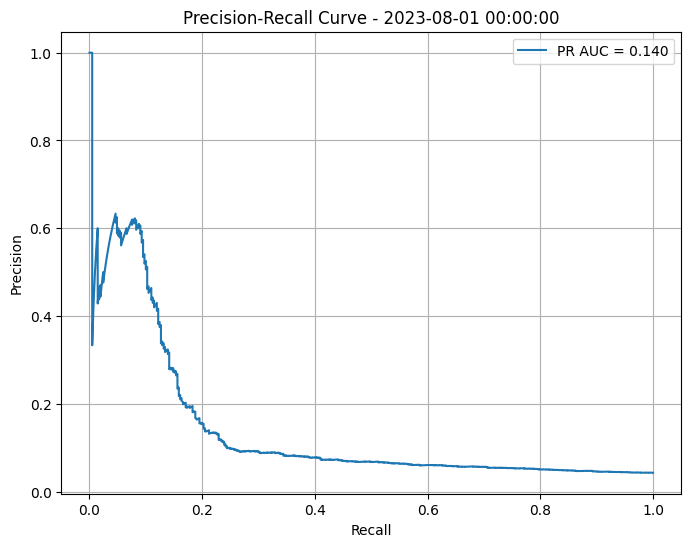

[LightGBM] [Info] Number of positive: 753, number of negative: 17172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 307
[LightGBM] [Info] Number of data points in the train set: 17925, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.533175
[100]	valid_0's binary_logloss: 0.503864
[150]	valid_0's binary_logloss: 0.481409
[200]	valid_0's binary_logloss: 0.462157
[250]	valid_0's binary_logloss: 0.444241
[300]	valid_0's binary_logloss: 0.429513
[350]	valid_0's binary_logloss: 0.415465
[400]	valid_0's binary_logloss: 0.405106
[450]	valid_0's binary_logloss: 0.39647
[500]	valid_0's binary_logloss: 0.384781
Did not meet early stopping. Best iteratio

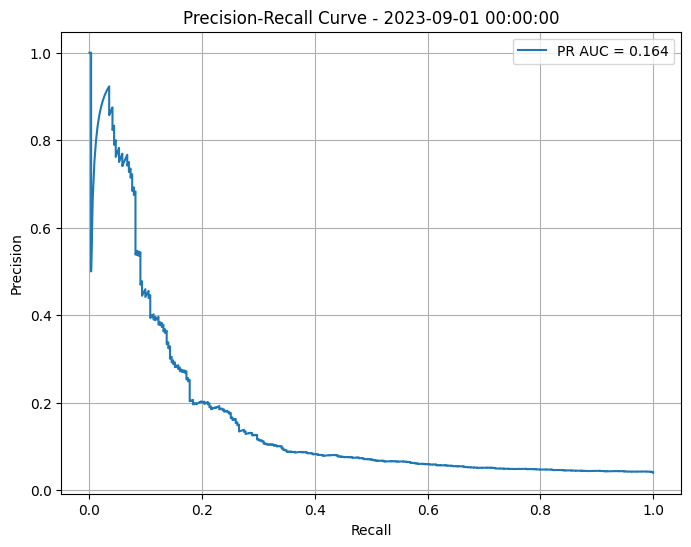

[LightGBM] [Info] Number of positive: 1096, number of negative: 25421
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 307
[LightGBM] [Info] Number of data points in the train set: 26517, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.550911
[100]	valid_0's binary_logloss: 0.526926
[150]	valid_0's binary_logloss: 0.509479
[200]	valid_0's binary_logloss: 0.491282
[250]	valid_0's binary_logloss: 0.473624
[300]	valid_0's binary_logloss: 0.460016
[350]	valid_0's binary_logloss: 0.450987
[400]	valid_0's binary_logloss: 0.441405
[450]	valid_0's binary_logloss: 0.430743
[500]	valid_0's binary_logloss: 0.422319
Did not meet early stopping. Best iterat

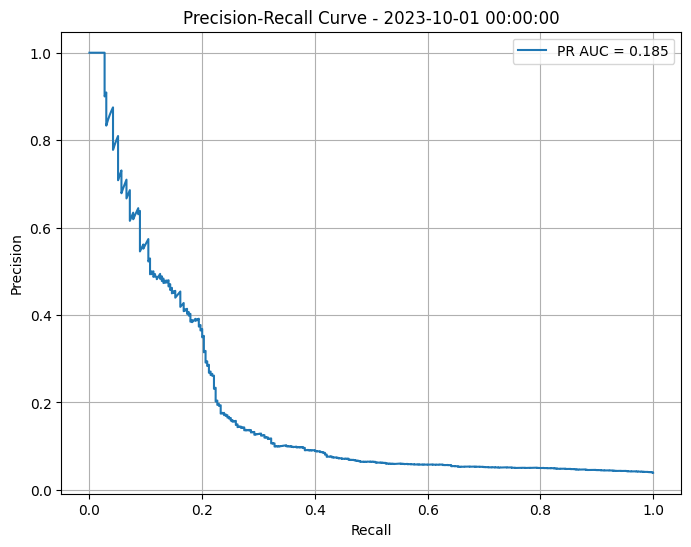

[LightGBM] [Info] Number of positive: 1431, number of negative: 33618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 307
[LightGBM] [Info] Number of data points in the train set: 35049, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.562269
[100]	valid_0's binary_logloss: 0.540839
[150]	valid_0's binary_logloss: 0.527957
[200]	valid_0's binary_logloss: 0.518524
[250]	valid_0's binary_logloss: 0.507775
[300]	valid_0's binary_logloss: 0.497221
[350]	valid_0's binary_logloss: 0.486927
[400]	valid_0's binary_logloss: 0.477226
[450]	valid_0's binary_logloss: 0.468522
[500]	valid_0's binary_logloss: 0.460065
Did not meet early stopping. Best iter

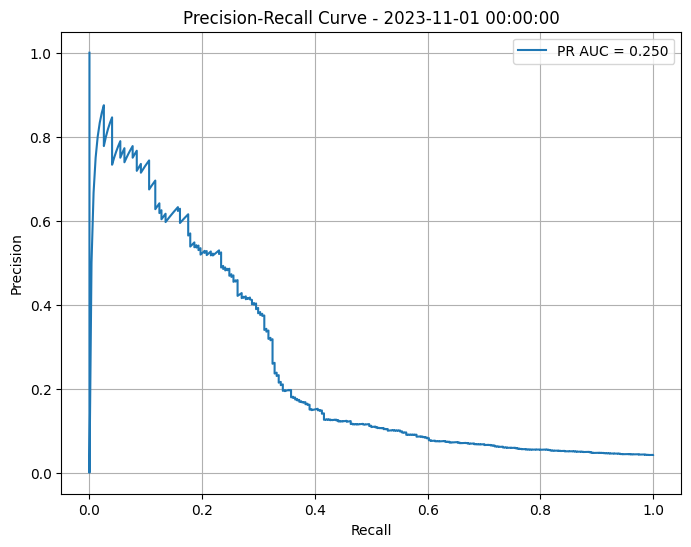

[LightGBM] [Info] Number of positive: 1705, number of negative: 39827
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 307
[LightGBM] [Info] Number of data points in the train set: 41532, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.5726
[100]	valid_0's binary_logloss: 0.555015
[150]	valid_0's binary_logloss: 0.542883
[200]	valid_0's binary_logloss: 0.530442
[250]	valid_0's binary_logloss: 0.51822
[300]	valid_0's binary_logloss: 0.509463
[350]	valid_0's binary_logloss: 0.500074
[400]	valid_0's binary_logloss: 0.492362
[450]	valid_0's binary_logloss: 0.485301
[500]	valid_0's bi

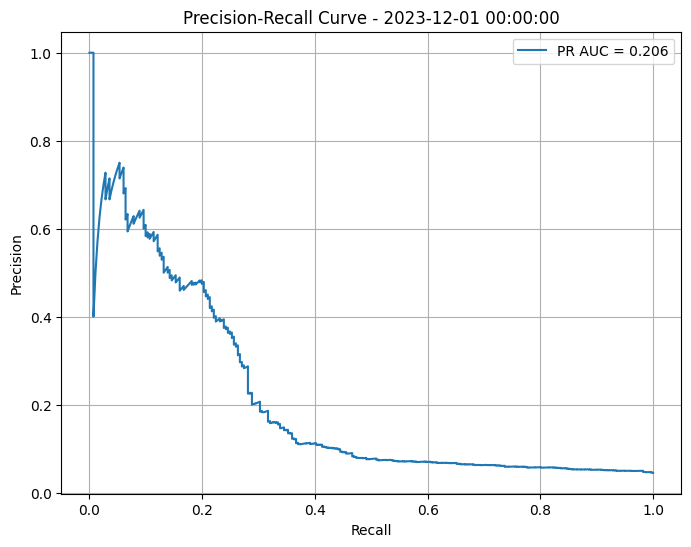

In [78]:
# Loop mês a mês
for i in range(1, len(meses)):
    # Dados de treino até o mês n
    train_mask = df['mes_ref'] < meses[i]
    X_train_lgbm = df.loc[train_mask, final_cols].drop(columns=['mes_ref'])
    y_train_lgbm = df.loc[train_mask, 'alvo']

    # Dados de teste no mês n+1
    test_mask = df['mes_ref'] == meses[i]
    X_test_lgbm = df.loc[test_mask, final_cols].drop(columns=['mes_ref'])
    y_test_lgbm = df.loc[test_mask, 'alvo']

    # Target encoding da VAR52
    te = TargetEncoder(cols=['VAR52'], smoothing=0.3)
    X_train_lgbm['VAR52_TE'] = te.fit_transform(X_train_lgbm['VAR52'], y_train_lgbm)
    X_test_lgbm['VAR52_TE'] = te.transform(X_test_lgbm['VAR52'])
    X_train_lgbm = X_train_lgbm.drop(columns=['VAR52'])
    X_test_lgbm = X_test_lgbm.drop(columns=['VAR52'])

    # Modelo LightGBM
    lgb_model_lgbm = LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        learning_rate=0.05,
        n_estimators=500,
        num_leaves=30,
        max_depth=-1,
        random_state=42,
        class_weight='balanced'
    )

    lgb_model_lgbm.fit(
        X_train_lgbm, y_train_lgbm,
        eval_set=[(X_test_lgbm, y_test_lgbm)],
        eval_metric='binary_logloss',
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
    )

    # Previsão
    y_pred_prob_lgbm = lgb_model_lgbm.predict_proba(X_test_lgbm)[:,1]
    y_pred_lgbm = (y_pred_prob_lgbm >= 0.15).astype(int)

    # Métricas clássicas
    precision_lgbm = precision_score(y_test_lgbm, y_pred_lgbm)
    recall_lgbm = recall_score(y_test_lgbm, y_pred_lgbm)
    f1_lgbm = f1_score(y_test_lgbm, y_pred_lgbm)
    cm_lgbm = confusion_matrix(y_test_lgbm, y_pred_lgbm)

    # Precision-Recall AUC
    precision_curve_lgbm, recall_curve_lgbm, _ = precision_recall_curve(y_test_lgbm, y_pred_prob_lgbm)
    pr_auc_lgbm = auc(recall_curve_lgbm, precision_curve_lgbm)

    # Print das métricas
    print(f"\n===== Mês de Teste: {meses[i]} =====")
    print("Precision:", precision_lgbm)
    print("Recall:", recall_lgbm)
    print("F1-score:", f1_lgbm)
    print("Confusion Matrix:\n", cm_lgbm)
    print("PR AUC:", pr_auc_lgbm)

    # Plot da curva Precision-Recall
    plt.figure(figsize=(8,6))
    plt.plot(recall_curve_lgbm, precision_curve_lgbm, label=f'PR AUC = {pr_auc_lgbm:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {meses[i]}')
    plt.legend()
    plt.grid(True)
    plt.show()

Como é uma despreporção extrema não adianta ajustar o threshold pelo F1

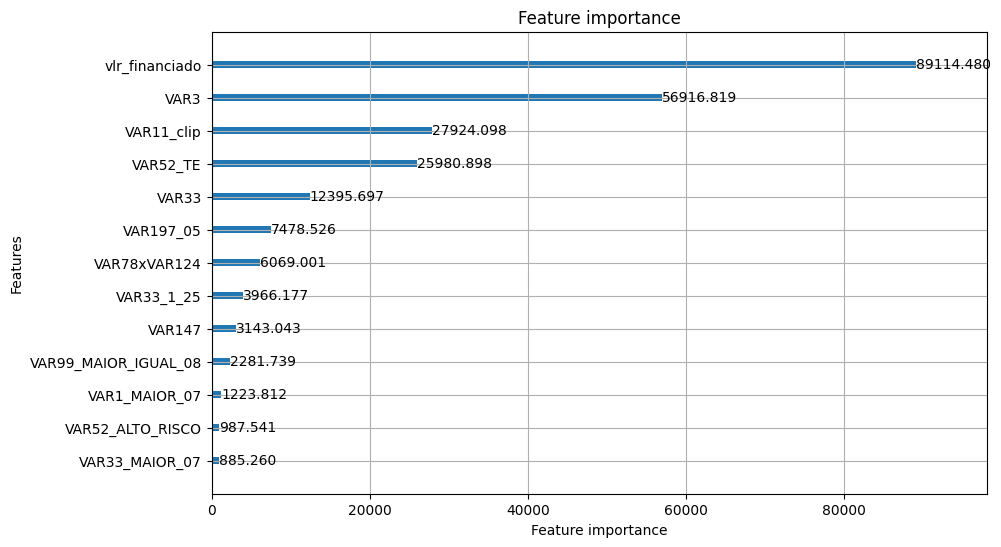

In [959]:
# Feature importance
lgb.plot_importance(lgb_model_lgbm, max_num_features=20, importance_type='gain', figsize=(10,6))
plt.show()

Melhor resultado:

Precision Score: 5.12%

Recall Score: 91.81%

Confusion Matrix:

 [1137 4780]

 [  23  258]

 Modelo bastante agressivo, capturando quase todas as fraudes mas gerando  falso positivos.

### Teste Temporal LightGBM com SMOTE

In [896]:
# Loop mês a mês
for i in range(1, len(meses)):
    # Dados de treino até o mês n
    train_mask = df['mes_ref'] < meses[i]
    X_train = df.loc[train_mask, final_cols].drop(columns=['mes_ref'])
    y_train = df.loc[train_mask, 'alvo']

    # Dados de teste no mês n+1
    test_mask = df['mes_ref'] == meses[i]
    X_test = df.loc[test_mask, final_cols].drop(columns=['mes_ref'])
    y_test = df.loc[test_mask, 'alvo']

    # Target encoding da VAR52
    te = TargetEncoder(cols=['VAR52'], smoothing=0.3)
    X_train['VAR52_TE'] = te.fit_transform(X_train['VAR52'], y_train)
    X_test['VAR52_TE'] = te.transform(X_test['VAR52'])
    X_train = X_train.drop(columns=['VAR52'])
    X_test = X_test.drop(columns=['VAR52'])

    # Aplicando SMOTE
    smote_sampler = SMOTE(sampling_strategy=0.3, random_state=42)
    X_train_res, y_train_res = smote_sampler.fit_resample(X_train, y_train)

    # Modelo LightGBM
    lgb_model = LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        learning_rate=0.05,
        n_estimators=500,
        num_leaves=40,
        max_depth=-2,
        random_state=42,
        class_weight='balanced'
    )

    # Treinando
    lgb_model.fit(
        X_train_res, y_train_res,
        eval_set=[(X_test, y_test)],
        eval_metric='binary_logloss',
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
    )

    # Previsão
    y_pred_prob = lgb_model.predict_proba(X_test)[:,1]
    y_pred = (y_pred_prob >= 0.2).astype(int)

    # Métricas
    print(f"\n===== Mês de Teste: {meses[i]} =====")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Precision Score:", precision_score(y_test, y_pred))
    print("Recall Score:", recall_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")

[LightGBM] [Info] Number of positive: 2414, number of negative: 8049
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1866
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.244707
[100]	valid_0's binary_logloss: 0.206398
[150]	valid_0's binary_logloss: 0.198082
[200]	valid_0's binary_logloss: 0.197112
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 0.196718

===== Mês de Teste: 2023-08-01 00:00:00 =====
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94      9123
         1.0       0.13      0

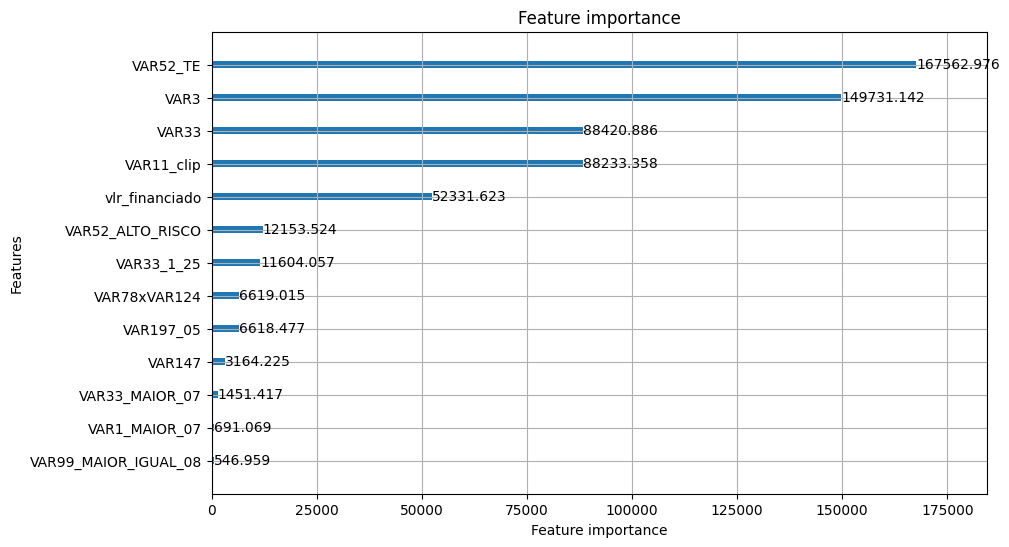

In [897]:
# Feature importance
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain', figsize=(10,6))
plt.show()

Resultado:

Precision Score: 14.65%

Recall Score: 34.88%

Confusion Matrix:

 [5346  571]

 [ 183  98]

 Modelo não muito interessante, baixa precisão e recall, matriz de cunfusão ruim.

### LightGBM Temporal com ADASYN

[LightGBM] [Info] Number of positive: 7973, number of negative: 8049
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2047
[LightGBM] [Info] Number of data points in the train set: 16022, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497628 -> initscore=-0.009487
[LightGBM] [Info] Start training from score -0.009487
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.199298
[100]	valid_0's binary_logloss: 0.16766
[150]	valid_0's binary_logloss: 0.166951
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.166097

===== Mês de Teste: 2023-08-01 00:00:00 =====
Precision: 0.19168173598553345
Recall: 0.25853658536585367
F1-score: 0.2201453790238837
Confusion Matrix:
 [[8676  447]
 [ 304  106]]
PR AU

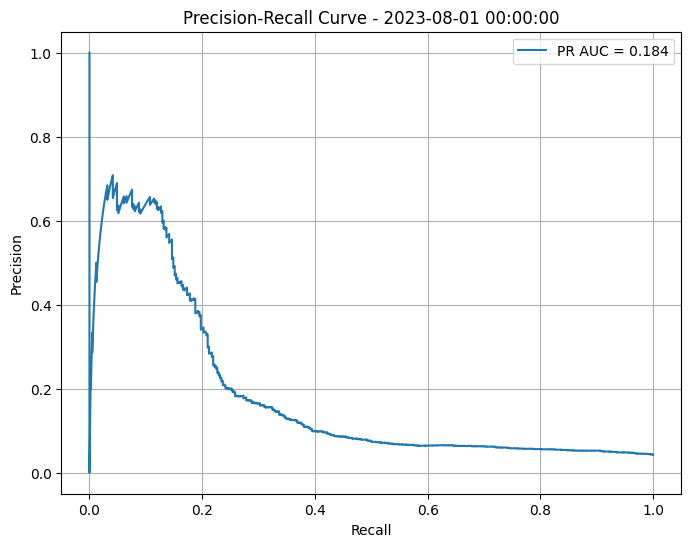

[LightGBM] [Info] Number of positive: 17193, number of negative: 17172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 34365, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500306 -> initscore=0.001222
[LightGBM] [Info] Start training from score 0.001222
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.201231
[100]	valid_0's binary_logloss: 0.160822
[150]	valid_0's binary_logloss: 0.154958
[200]	valid_0's binary_logloss: 0.154221
Early stopping, best iteration is:
[198]	valid_0's binary_logloss: 0.154215

===== Mês de Teste: 2023-09-01 00:00:00 =====
Precision: 0.22413793103448276
Recall: 0.3032069970845481
F1-score: 0.2577447335811648
Confusion Matrix:
 [[7889  360]
 [ 239  104]]
PR AUC: 0.1972209996137903


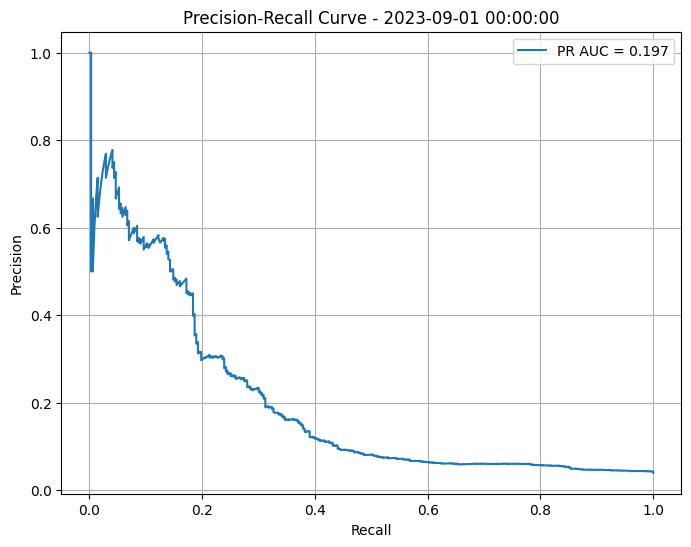

[LightGBM] [Info] Number of positive: 25337, number of negative: 25421
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2047
[LightGBM] [Info] Number of data points in the train set: 50758, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499173 -> initscore=-0.003310
[LightGBM] [Info] Start training from score -0.003310
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.202776
[100]	valid_0's binary_logloss: 0.162745
[150]	valid_0's binary_logloss: 0.156555
[200]	valid_0's binary_logloss: 0.155638
[250]	valid_0's binary_logloss: 0.156063
Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.155569

===== Mês de Teste: 2023-10-01 00:00:00 =====
Precision: 0.1934782608695652
Recall: 0.2656716417910448
F1-score: 0.2238993710691824
Confusion Matrix:
 [[7826  371]


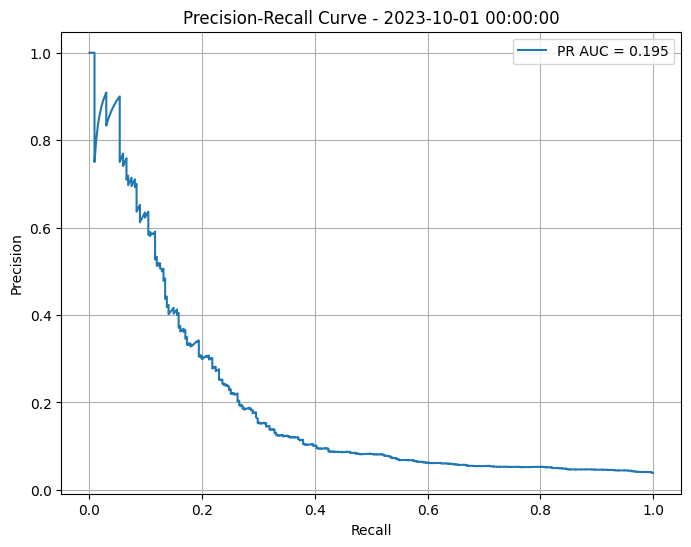

[LightGBM] [Info] Number of positive: 33297, number of negative: 33618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2047
[LightGBM] [Info] Number of data points in the train set: 66915, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497601 -> initscore=-0.009594
[LightGBM] [Info] Start training from score -0.009594
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.200106
[100]	valid_0's binary_logloss: 0.161638
[150]	valid_0's binary_logloss: 0.155014
[200]	valid_0's binary_logloss: 0.154105
[250]	valid_0's binary_logloss: 0.154005
[300]	valid_0's binary_logloss: 0.15402
Early stopping, best iteration is:
[261]	valid_0's binary_logloss: 0.153869

===== Mês de Teste: 2023-11-01 00:00:00 =====
Precision: 0.278125
Recall: 0.3248175182481752
F1-score: 0.2996632996632997
Co

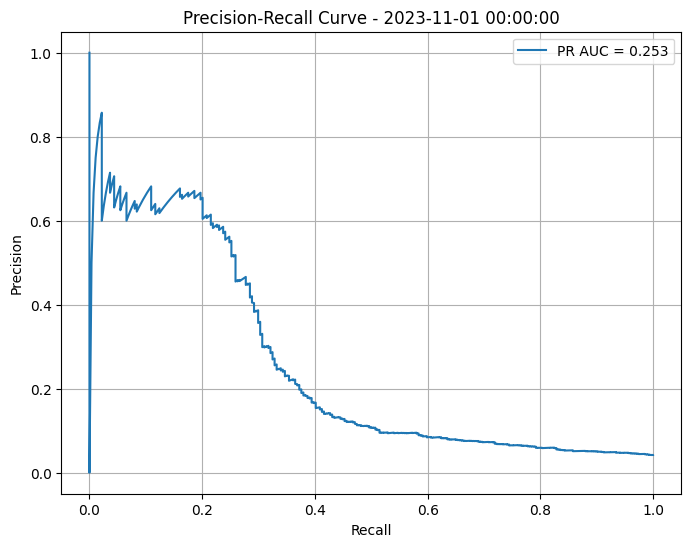

[LightGBM] [Info] Number of positive: 39577, number of negative: 39827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2047
[LightGBM] [Info] Number of data points in the train set: 79404, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498426 -> initscore=-0.006297
[LightGBM] [Info] Start training from score -0.006297
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.219502
[100]	valid_0's binary_logloss: 0.180515
[150]	valid_0's binary_logloss: 0.173575
[200]	valid_0's binary_logloss: 0.172097
[250]	valid_0's binary_logloss: 0.171675
[300]	valid_0's binary_logloss: 0.171758
Early stopping, best iteration is:
[265]	valid_0's binary_logloss: 0.171535

===== Mês de Teste: 2023-12-01 00:00:00 =====
Precision: 0.2245508982035928
Recall: 0.2669039145907473
F1-score: 0.24390243

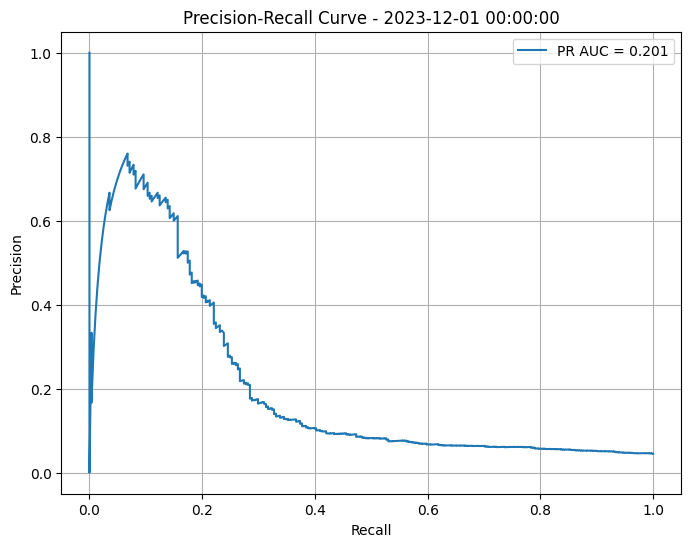

In [934]:
# Loop mês a mês
for i in range(1, len(meses)):
    # Dados de treino até o mês n
    train_mask = df['mes_ref'] < meses[i]
    X_train = df.loc[train_mask, final_cols].drop(columns=['mes_ref'])
    y_train = df.loc[train_mask, 'alvo']

    # Dados de teste no mês n+1
    test_mask = df['mes_ref'] == meses[i]
    X_test = df.loc[test_mask, final_cols].drop(columns=['mes_ref'])
    y_test = df.loc[test_mask, 'alvo']

    # Target encoding da VAR52
    te = TargetEncoder(cols=['VAR52'], smoothing=0.3)
    X_train['VAR52_TE'] = te.fit_transform(X_train['VAR52'], y_train)
    X_test['VAR52_TE'] = te.transform(X_test['VAR52'])
    X_train = X_train.drop(columns=['VAR52'])
    X_test = X_test.drop(columns=['VAR52'])

    sampler = ADASYN(random_state=42, n_neighbors=5)

    X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)

    # Modelo LightGBM
    lgb_model = LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        learning_rate=0.05,
        n_estimators=500,
        num_leaves=30,
        max_depth=-1,
        random_state=42,
        class_weight=None
    )

    lgb_model.fit(
        X_train_res, y_train_res,
        eval_set=[(X_test, y_test)],
        eval_metric='binary_logloss',
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
    )

    # Previsão
    y_pred_prob = lgb_model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob >= 0.15).astype(int)

    # Métricas clássicas
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Precision-Recall AUC
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall_curve, precision_curve)

    # Print das métricas
    print(f"\n===== Mês de Teste: {meses[i]} =====")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("Confusion Matrix:\n", cm)
    print("PR AUC:", pr_auc)

    # Plot da curva Precision-Recall
    plt.figure(figsize=(8,6))
    plt.plot(recall_curve, precision_curve, label=f'PR AUC = {pr_auc:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {meses[i]}')
    plt.legend()
    plt.grid(True)
    plt.show()

Resultado:

Precision Score: 27.81%

Recall Score: 32.48%

Confusion Matrix:

 [5978  231]

 [ 185  89]

Baixos valores de precisão e Recall

### LightGBM Temporal com BORDERLINE-SMOTE

[LightGBM] [Info] Number of positive: 8049, number of negative: 8049
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 16098, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.203061
[100]	valid_0's binary_logloss: 0.170965
[150]	valid_0's binary_logloss: 0.170304
Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.169469

===== Mês de Teste: 2023-08-01 00:00:00 =====
Precision: 0.184
Recall: 0.2804878048780488
F1-score: 0.2222222222222222
Confusion Matrix:
 [[8613  510]
 [ 295  115]]
PR AUC: 0.1778330349568475


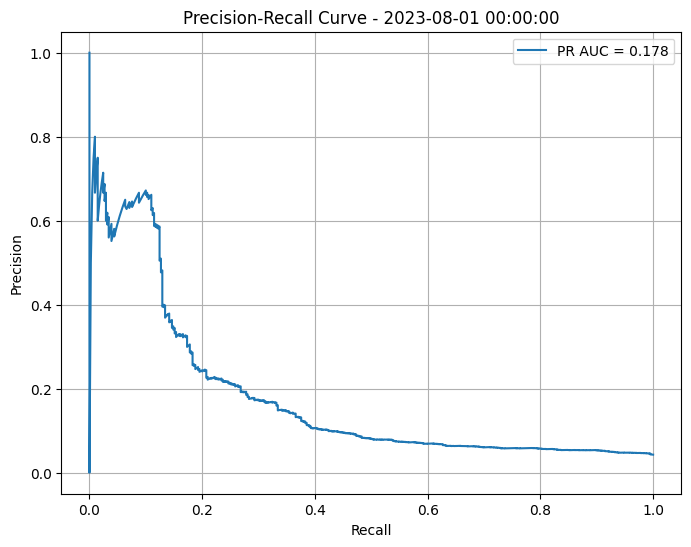

[LightGBM] [Info] Number of positive: 17172, number of negative: 17172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 34344, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.206406
[100]	valid_0's binary_logloss: 0.162762
[150]	valid_0's binary_logloss: 0.155718
[200]	valid_0's binary_logloss: 0.15501
Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 0.154919

===== Mês de Teste: 2023-09-01 00:00:00 =====
Precision: 0.21951219512195122
Recall: 0.2886297376093295
F1-score: 0.24937027707808565
Confusion Matrix:
 [[7897  352]
 [ 244   99]]
PR AUC: 0.1918477

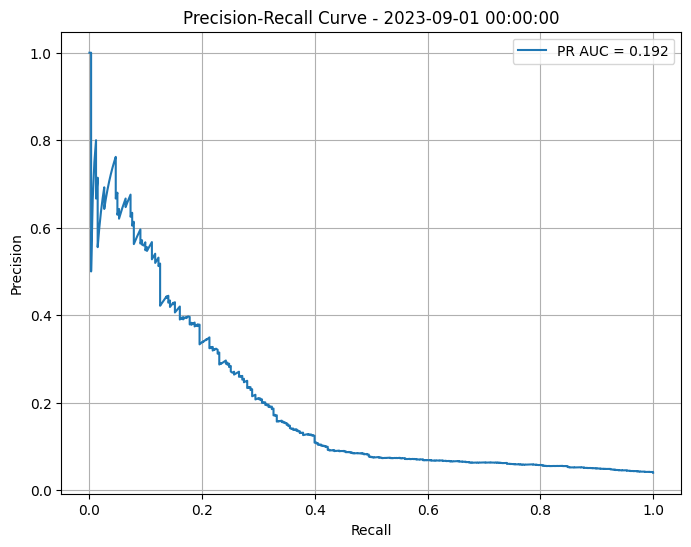

[LightGBM] [Info] Number of positive: 25421, number of negative: 25421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 50842, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.215324
[100]	valid_0's binary_logloss: 0.16174
[150]	valid_0's binary_logloss: 0.155181
[200]	valid_0's binary_logloss: 0.153944
[250]	valid_0's binary_logloss: 0.153822
Early stopping, best iteration is:
[224]	valid_0's binary_logloss: 0.153769

===== Mês de Teste: 2023-10-01 00:00:00 =====
Precision: 0.21518987341772153
Recall: 0.2537313432835821
F1-score: 0.2328767123287671
Confusion Matrix:
 [[78

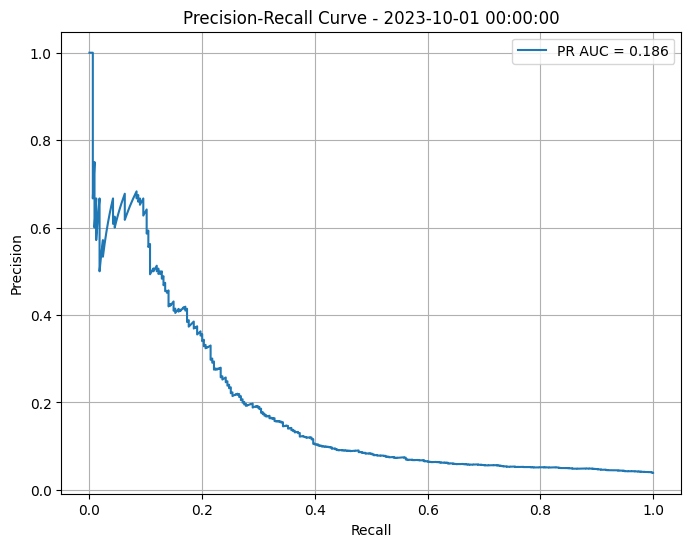

[LightGBM] [Info] Number of positive: 33618, number of negative: 33618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 67236, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.210418
[100]	valid_0's binary_logloss: 0.162262
[150]	valid_0's binary_logloss: 0.154904
[200]	valid_0's binary_logloss: 0.15397
Early stopping, best iteration is:
[188]	valid_0's binary_logloss: 0.153909

===== Mês de Teste: 2023-11-01 00:00:00 =====
Precision: 0.275
Recall: 0.32116788321167883
F1-score: 0.2962962962962963
Confusion Matrix:
 [[5977  232]
 [ 186   88]]
PR AUC: 0.24233723598325121


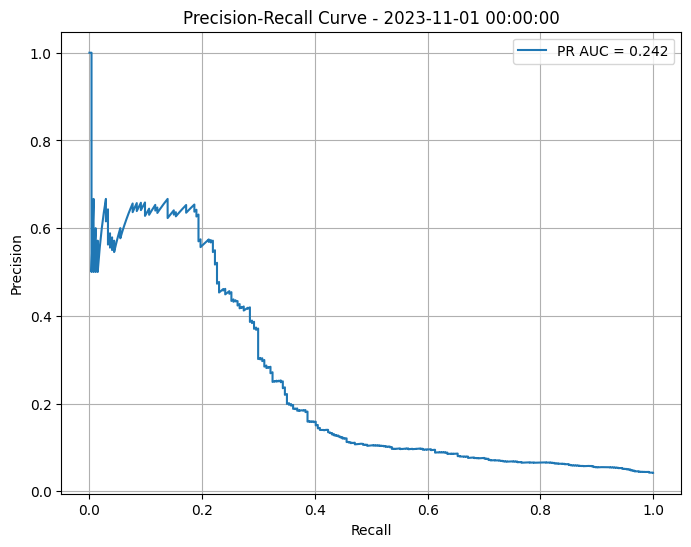

[LightGBM] [Info] Number of positive: 39827, number of negative: 39827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 79654, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.234359
[100]	valid_0's binary_logloss: 0.181152
[150]	valid_0's binary_logloss: 0.172905
[200]	valid_0's binary_logloss: 0.170867
[250]	valid_0's binary_logloss: 0.170107
[300]	valid_0's binary_logloss: 0.169557
[350]	valid_0's binary_logloss: 0.169459
Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.169433

===== Mês de Teste: 2023-12-01 00:00:00 =====
Precision: 0.23885350318471338
Recall: 0.2669039145907473
F1-score: 0.25210084033613445
Con

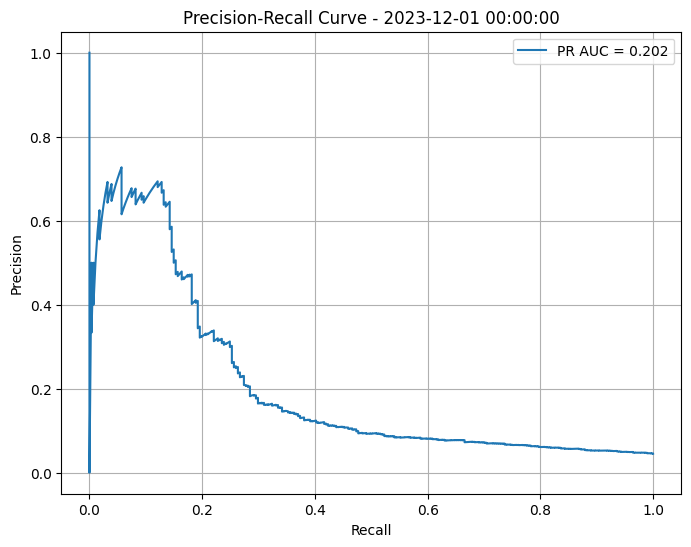

In [935]:
# Loop mês a mês
for i in range(1, len(meses)):
    # Dados de treino até o mês n
    train_mask = df['mes_ref'] < meses[i]
    X_train = df.loc[train_mask, final_cols].drop(columns=['mes_ref'])
    y_train = df.loc[train_mask, 'alvo']

    # Dados de teste no mês n+1
    test_mask = df['mes_ref'] == meses[i]
    X_test = df.loc[test_mask, final_cols].drop(columns=['mes_ref'])
    y_test = df.loc[test_mask, 'alvo']

    # Target encoding da VAR52
    te = TargetEncoder(cols=['VAR52'], smoothing=0.3)
    X_train['VAR52_TE'] = te.fit_transform(X_train['VAR52'], y_train)
    X_test['VAR52_TE'] = te.transform(X_test['VAR52'])
    X_train = X_train.drop(columns=['VAR52'])
    X_test = X_test.drop(columns=['VAR52'])

    sampler = BorderlineSMOTE(kind="borderline-1", random_state=42, k_neighbors=5)

    X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)

    # Modelo LightGBM
    lgb_model = LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        learning_rate=0.05,
        n_estimators=500,
        num_leaves=30,
        max_depth=-1,
        random_state=42,
        class_weight=None
    )

    lgb_model.fit(
        X_train_res, y_train_res,
        eval_set=[(X_test, y_test)],
        eval_metric='binary_logloss',
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
    )

    # Previsão
    y_pred_prob = lgb_model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob >= 0.15).astype(int)

    # Métricas clássicas
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Precision-Recall AUC
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall_curve, precision_curve)

    # Print das métricas
    print(f"\n===== Mês de Teste: {meses[i]} =====")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("Confusion Matrix:\n", cm)
    print("PR AUC:", pr_auc)

    # Plot da curva Precision-Recall
    plt.figure(figsize=(8,6))
    plt.plot(recall_curve, precision_curve, label=f'PR AUC = {pr_auc:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {meses[i]}')
    plt.legend()
    plt.grid(True)
    plt.show()

Resultado:

Precision Score: 27.50%

Recall Score: 32.11%

Confusion Matrix:

 [5977  232]

 [ 186  88]

Baixa precisão e recall, matriz de cunfusão ruim.

### Teste Temporal com Radom Forest

In [936]:
# Lista final de features (excluindo 'mes_ref' do treino)
final_cols = [
    'VAR1_MAIOR_07', 'VAR33_1_25', 'VAR33_MAIOR_07', 'VAR99_MAIOR_IGUAL_08',
    'VAR52_ALTO_RISCO', 'VAR52', 'VAR3', 'VAR78', 'VAR147', 'vlr_financiado',
    'VAR33', 'VAR101', 'VAR69', 'VAR154', 'VAR10', 'VAR199_NORDESTE'
]

# Meses únicos ordenados
meses = sorted(df['mes_ref'].unique())

In [937]:
# Loop mês a mês
for i in range(1, len(meses)):
    print(f"\n===== Mês de Teste: {meses[i]} =====")

    # Dados de treino até o mês n
    mask_train = df['mes_ref'] < meses[i]
    X_train_rf = df.loc[mask_train, final_cols].drop(columns=['VAR52'])
    y_train_rf = df.loc[mask_train, 'alvo']

    # Dados de teste no mês n+1
    mask_test = df['mes_ref'] == meses[i]
    X_test_rf = df.loc[mask_test, final_cols].drop(columns=['VAR52'])
    y_test_rf = df.loc[mask_test, 'alvo']

    # Target encoding da VAR52
    te_rf = TargetEncoder(cols=['VAR52'], smoothing=0.3)
    X_train_rf['VAR52_TE'] = te_rf.fit_transform(df.loc[mask_train, 'VAR52'], y_train_rf)
    X_test_rf['VAR52_TE'] = te_rf.transform(df.loc[mask_test, 'VAR52'])

    # Criando modelo Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    )

    # Treinando
    rf_model.fit(X_train_rf, y_train_rf)

    # Previsão
    y_pred_prob_rf = rf_model.predict_proba(X_test_rf)[:,1]
    threshold_rf = 0.15
    y_pred_rf = (y_pred_prob_rf >= threshold_rf).astype(int)

    # Métricas
    print("Classification Report:\n", classification_report(y_test_rf, y_pred_rf))
    print("Precision Score:", precision_score(y_test_rf, y_pred_rf))
    print("Recall Score:", recall_score(y_test_rf, y_pred_rf))
    print("Confusion Matrix:\n", confusion_matrix(y_test_rf, y_pred_rf))
    print("\n")


===== Mês de Teste: 2023-08-01 00:00:00 =====
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      9123
         1.0       0.18      0.26      0.21       410

    accuracy                           0.92      9533
   macro avg       0.57      0.60      0.59      9533
weighted avg       0.93      0.92      0.93      9533

Precision Score: 0.1826086956521739
Recall Score: 0.25609756097560976
Confusion Matrix:
 [[8653  470]
 [ 305  105]]



===== Mês de Teste: 2023-09-01 00:00:00 =====
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.95      8249
         1.0       0.16      0.30      0.21       343

    accuracy                           0.91      8592
   macro avg       0.57      0.62      0.58      8592
weighted avg       0.94      0.91      0.92      8592

Precision Score: 0.1640378548895899
Recall Score: 0.3032069970845481
Confusion Matrix:

In [938]:
prec, rec, thresholds = precision_recall_curve(y_test_rf, y_pred_prob_rf)
f1_scores = 2*prec*rec/(prec+rec)
best_thresh = thresholds[f1_scores.argmax()]
print("Melhor threshold:", best_thresh)

Melhor threshold: 0.214


Resultado:

Precision Score: 18.36%

Recall Score: 34.30%

Confusion Matrix:

 [5791  418]

 [ 180  94]

 Modelo também não muito interessante.

Como o LightGBM lida melhor com desbalanceamentos na base de dados, e devido ao prazo, o projeto não irá mais abordar Random Forest.

### LightGBM sem variação temporal

In [939]:
# Splitando treino/teste (70/30) com stratify por conta do desbalanceamento absurdo de 4% de fraude só
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [940]:
X_train = X_train.drop(columns=['mes_ref'])
X_test = X_test.drop(columns=['mes_ref'])

In [941]:
print("Dimensão treino:", X_train.shape, y_train.shape)
print("Dimensão teste:", X_test.shape, y_test.shape)

Dimensão treino: (33411, 14) (33411,)
Dimensão teste: (14319, 14) (14319,)


In [942]:
# Fazendo o prometido target encoding
te = TargetEncoder(cols=['VAR52'], smoothing=0.3)
X_train['VAR52_TE'] = te.fit_transform(X_train['VAR52'], y_train)
X_test['VAR52_TE'] = te.transform(X_test['VAR52'])
X_train = X_train.drop(columns=['VAR52'])
X_test = X_test.drop(columns=['VAR52'])

In [943]:
# Criando dataset para LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [944]:
# Criando o modelo
lgb_model_sem_tempo = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    learning_rate=0.05,
    n_estimators=500,
    num_leaves=31,
    max_depth=-1,
    random_state=42,
    class_weight='balanced'
)

In [945]:
# Treinando
lgb_model_sem_tempo.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='binary_logloss',
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
)

[LightGBM] [Info] Number of positive: 1390, number of negative: 32021
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 307
[LightGBM] [Info] Number of data points in the train set: 33411, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.54029
[100]	valid_0's binary_logloss: 0.517841
[150]	valid_0's binary_logloss: 0.503461
[200]	valid_0's binary_logloss: 0.490601
[250]	valid_0's binary_logloss: 0.478716
[300]	valid_0's binary_logloss: 0.468259
[350]	valid_0's binary_logloss: 0.459209
[400]	valid_0's binary_logloss: 0.449981
[450]	valid_0's binary_logloss: 0.442261
[500]	valid_0's 

LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=500,
               objective='binary', random_state=42)

In [946]:
# Previsão no teste
y_pred_prob = lgb_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= 0.72).astype(int)

# Métricas principais
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred))
print("Recall Score:", recall_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.28      0.44     13723
         1.0       0.05      0.86      0.09       596

    accuracy                           0.31     14319
   macro avg       0.51      0.57      0.27     14319
weighted avg       0.94      0.31      0.43     14319

Precision Score: 0.04938988959907031
Recall Score: 0.8557046979865772
Confusion Matrix:
 [[3907 9816]
 [  86  510]]


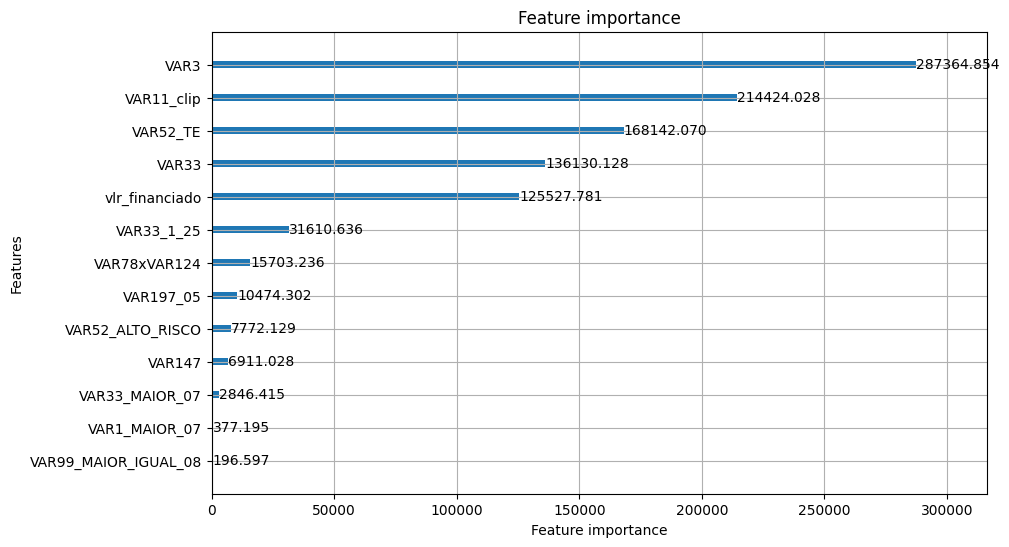

In [947]:
# Feature importance
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain', figsize=(10,6))
plt.show()

Resultado:

Precision Score: 30.54%

Recall Score: 20.81%

Confusion Matrix:

 [13441  282]

 [ 472  124]

 Modelo com precisão relativamente baixa e recall muito abaixo do aceitável.

### Conclusão das modelagens

Dos modelos testados, o LightGBM com variação temporal alcançou um melhor resultado.

Devido ao prazo, esse será o modelo final a ser utilizado no projeto.

In [960]:
# Top 10% casos de fraude
top_pct = 0.10
n_top = int(len(y_test_lgbm) * top_pct)

# Ordenando pelo score
top_idx = np.argsort(y_pred_prob_lgbm)[-n_top:]

# Calcula a precision apenas nesse top X%
precision_top = y_test_lgbm.iloc[top_idx].mean()
print(f"Precision @ top {int(top_pct*100)}%: {precision_top:.2%}")

Precision @ top 10%: 15.35%


In [961]:
fraudes_capturadas = y_test_lgbm.iloc[top_idx].sum()
total_fraudes = y_test_lgbm.sum()
reducao = fraudes_capturadas / total_fraudes
print(f"Fraudes capturadas analisando top {int(top_pct*100)}%: {reducao:.2%}")

Fraudes capturadas analisando top 10%: 33.81%


In [963]:
threshold_top = np.percentile(y_pred_prob, 100*(1-top_pct))
top_risk_mask = y_pred_prob_lgbm >= threshold_top

# Clientes do top 10%
top_risk_customers = X_test_lgbm[top_risk_mask].copy()
top_risk_customers['alvo'] = y_test_lgbm[top_risk_mask]

# Apenas fraudes
fraudes_no_top = top_risk_customers[top_risk_customers['alvo'] == 1]

valor_recuperado = fraudes_no_top['vlr_financiado'].sum()
print(f"Valor estimado capturado: R$ {valor_recuperado:,.2f}")

Valor estimado capturado: R$ 482,996.25


### Análise de impacto de variáveis

In [974]:
# Criando o explainer
explainer = shap.Explainer(lgb_model_lgbm)
shap_values = explainer(X_test_lgbm)

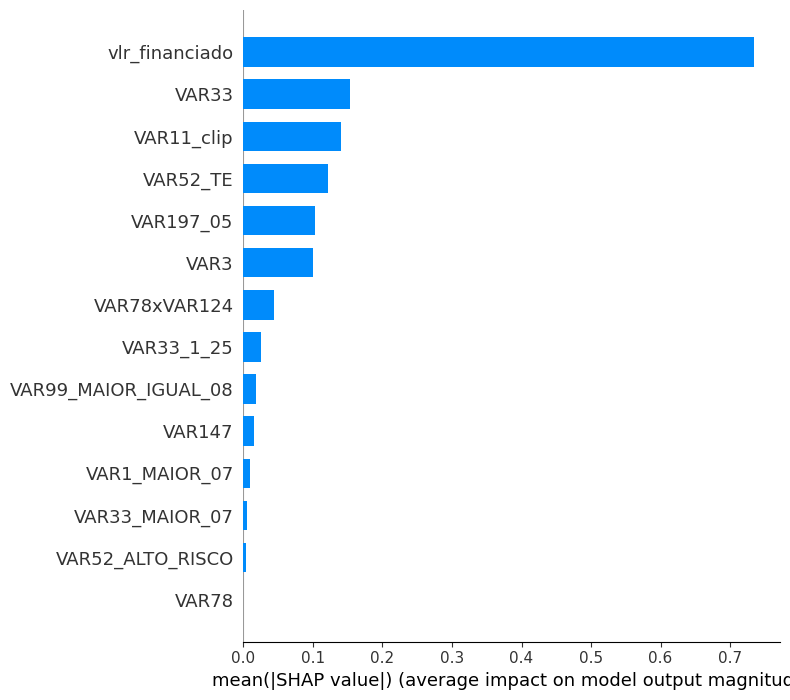

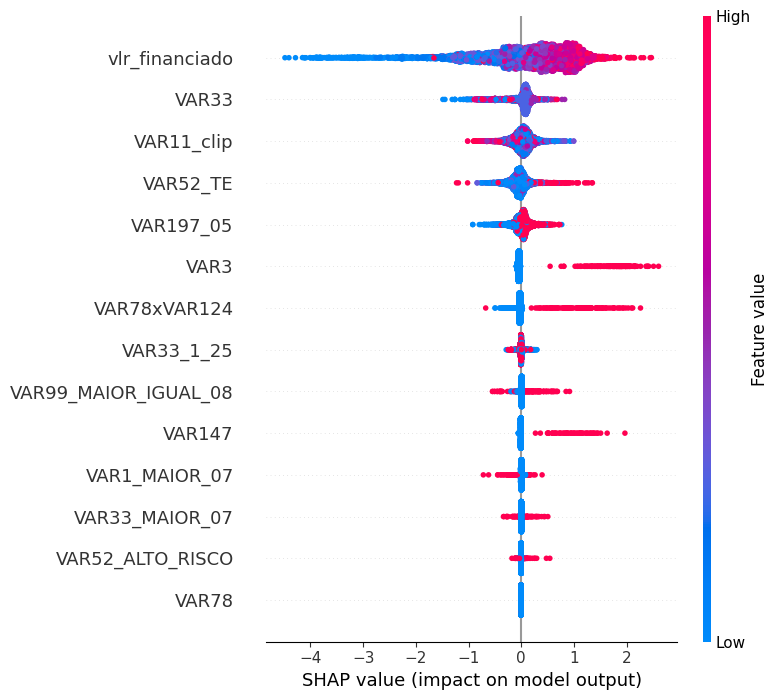

In [971]:
# Plot da importância das features
shap.summary_plot(shap_values, X_test_lgbm, plot_type="bar")
shap.summary_plot(shap_values, X_test_lgbm)

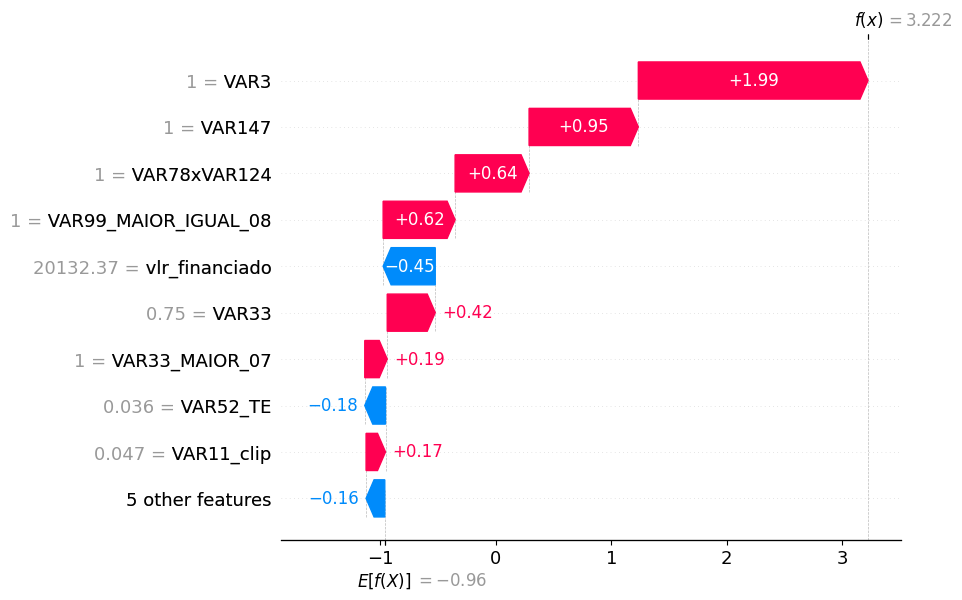

In [972]:
# Plot explicativo
cliente_idx = 0
shap.waterfall_plot(shap_values[cliente_idx])

Para esse caso, podemos perceber o impacto considerável que a variável VAR3 tem no resultado final, seguido da VAR147 e VAR78xVAR124.

## Finalização do Projeto proposto

Com esse projeto pude colocar em prática coonceitos de análise exploratória, feature engineering e modelagem de dados alcançando um resultado, diante do prazo proposto, até que satisfatório.

Como próximos passos:

- Otimização do modelo variando thresholds

- Aumentar a robustez da validação temporal

- Análise mais completa das features no SHAP

- Simulação de impacto financeiro para estimar custo de falsos positivos e perda evitada

- Melhorar a documentação sobre tomadas de decisões

- Exploração de outros modelos e outras técnicas para melhorar o desbalanceamento

- Refinamento de mensagem de probabilidade e valor da operação

In [967]:
X_test_mensagem = X_test_lgbm.copy()
X_test_mensagem['vlr_financiado'] = df.loc[X_test_mensagem.index, 'vlr_financiado']
X_test_mensagem['prob_fraude'] = y_pred_prob_lgbm

# Calculando o valor em risco
X_test_mensagem['valor_em_risco'] = X_test_mensagem['prob_fraude'] * X_test_mensagem['vlr_financiado']

# Criando a mensagem para cada cliente
X_test_mensagem['mensagem'] = X_test_mensagem.apply(
    lambda row: f"O cliente tem {row['prob_fraude']*100:.2f}% de chance de ser fraude e o risco da operação é de R$ {row['valor_em_risco']:,.2f}",
    axis=1
)


In [968]:
# Visualizando
X_test_mensagem[['mensagem']].head(10)

mensagem
34015  O cliente tem 96.17% de chance de ser fraude e...
34408  O cliente tem 38.55% de chance de ser fraude e...
35146  O cliente tem 41.09% de chance de ser fraude e...
35147  O cliente tem 52.25% de chance de ser fraude e...
35148  O cliente tem 28.84% de chance de ser fraude e...
35149  O cliente tem 29.71% de chance de ser fraude e...
35150  O cliente tem 29.12% de chance de ser fraude e...
35151  O cliente tem 13.74% de chance de ser fraude e...
35152  O cliente tem 11.79% de chance de ser fraude e...
35153  O cliente tem 21.91% de chance de ser fraude e...

- Adição de features no modelo para coleta de informações em PRD a fim de melhorar o estudo para as próximas modelagens do artefato

- Investigar concept drift e data drift

- Criação de score baseado no valor da probabilidade utilizando uma equação
- Exemplo: Score = 1 + 999x(1-p)

### Cálculo de métricas para apresentação

In [977]:
print("Dimensão da base:", df.shape)
print("Dimensão da base:", df_fraude.shape)

Dimensão da base: (47730, 70)
Dimensão da base: (1986, 63)


In [978]:
# Agrupando por mês e contando registros
fraude_por_mes = df_fraude.groupby('mes_ref').size().reset_index(name='qtd_fraudes')

# Mostrando o resultado
print(fraude_por_mes)

     mes_ref  qtd_fraudes
0 2023-07-01          343
1 2023-08-01          410
2 2023-09-01          343
3 2023-10-01          335
4 2023-11-01          274
5 2023-12-01          281
